In [3]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import sys
import os
sys.path.append(os.path.dirname(os.path.abspath('/home/oscar/code/RDMC/rdmc')))

import itertools
import pickle

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set_context('talk')

from joblib import Parallel, delayed

from rdmc import RDKitMol
from rdmc.ts import examine_normal_mode, get_formed_and_broken_bonds, guess_rxn_from_normal_mode
from rdmc.utils import PERIODIC_TABLE as PT
from rdmc.ts import get_all_changing_bonds

from scipy import signal

## Load the dataframe PKL file

In [10]:
cwd = os.getcwd()
print(cwd)

/home/oscar/Documents/brute_force_h/analyse


In [11]:
df = pd.read_pickle('step4_ts_db.pkl')

In [12]:
df

rxn_smi  \
fingerprint                                                                           
4f71ab1f82840959f6aa17f8b99ec99b  [C:8]1([C:9]([C:11]([H:20])([H:21])[H:22])([H:...   
85c621648191d5fe312c71a80a1ff7e7  [C:8]([C:9]1([C:10]([O:11][H:21])([H:19])[H:20...   
b98e3d9f994aa513bc22ebd7fd460897  [C:8]12([O:16][H:30])[C:9]([H:20])([C:11]1([C:...   
77b826e8e05e121e55791040915c7690  [N:8]#[C:9][C:10]1=[N:11][C:12]2([H:17])[C:13]...   
fc8665b128792aea3c45caba17986915  [C:8]1([H:16])([H:17])[C:9](=[O:10])[C:11]2([H...   
...                                                                             ...   
eeefaf28ac3b51e8e310c0368bcb4b6a  [C:8]1([C:13](=[O:22])[H:23])([H:16])[C:9]([H:...   
c6bd02658cb2589f7fbdfc479927acd5  [C:8]1([C:9]([C:11]([O:15][C:12]([H:23])([H:24...   
51cbba276976d263b5baf322b0a835a0  [C:8]1([C:9]([C:11]([O:15][C:12]([H:23])([H:24...   
7a1d9db1343f335415b2cc23e869b269  [C:8]1([C:9]([C:12]([H:23])([H:24])[H:25])([O:...   
161a068f4f1544b3d3b3c1e8e53ea4fb  [C:8]([C:9]([C:12]([C:10]([C:13]([N:14]([H:26]...   

                                                                           dft_freq  \
fingerprint                                                                           
4f71ab1f82840959f6aa17f8b99ec99b  [-1900.4363, 35.9935, 54.1616, 87.2508, 100.48...   
85c621648191d5fe312c71a80a1ff7e7  [-1749.4013, 43.4999, 54.013, 82.7785, 94.5891...   
b98e3d9f994aa513bc22ebd7fd460897  [-1614.4102, 37.4894, 53.2702, 61.5089, 97.713...   
77b826e8e05e121e55791040915c7690  [-1899.7358, 25.4507, 63.9529, 73.9892, 80.988...   
fc8665b128792aea3c45caba17986915  [-1777.5428, 47.6571, 64.7836, 89.5448, 110.94...   
...                                                                             ...   
eeefaf28ac3b51e8e310c0368bcb4b6a  [-1671.9901, 21.0302, 43.4679, 58.2334, 72.026...   
c6bd02658cb2589f7fbdfc479927acd5  [-1870.7227, 42.313, 57.7791, 78.7094, 85.2732...   
51cbba276976d263b5baf322b0a835a0  [-1919.5231, 36.1924, 60.3242, 88.1534, 95.23,...   
7a1d9db1343f335415b2cc23e869b269  [-2008.0304, 28.4777, 37.462, 46.4149, 64.0102...   
161a068f4f1544b3d3b3c1e8e53ea4fb  [-1941.0657, 32.0665, 38.4957, 43.7243, 52.809...   

                                  dft_freq_neg  \
fingerprint                                      
4f71ab1f82840959f6aa17f8b99ec99b    -1900.4363   
85c621648191d5fe312c71a80a1ff7e7    -1749.4013   
b98e3d9f994aa513bc22ebd7fd460897    -1614.4102   
77b826e8e05e121e55791040915c7690    -1899.7358   
fc8665b128792aea3c45caba17986915    -1777.5428   
...                                        ...   
eeefaf28ac3b51e8e310c0368bcb4b6a    -1671.9901   
c6bd02658cb2589f7fbdfc479927acd5    -1870.7227   
51cbba276976d263b5baf322b0a835a0    -1919.5231   
7a1d9db1343f335415b2cc23e869b269    -2008.0304   
161a068f4f1544b3d3b3c1e8e53ea4fb    -1941.0657   

                                                                            dft_xyz  \
fingerprint                                                                           
4f71ab1f82840959f6aa17f8b99ec99b  O   0.7013150000   0.7007130000   1.4393920000...   
85c621648191d5fe312c71a80a1ff7e7  O  -0.2376420000  -0.9338260000  -1.1349210000...   
b98e3d9f994aa513bc22ebd7fd460897  O  -0.5498650000  -0.3839770000  -0.1407540000...   
77b826e8e05e121e55791040915c7690  O   0.9859070000  -1.0768770000  -0.5057530000...   
fc8665b128792aea3c45caba17986915  O   0.3510250000   1.2836160000  -0.7819580000...   
...                                                                             ...   
eeefaf28ac3b51e8e310c0368bcb4b6a  O  -0.1554810000  -0.0387190000  -0.7641870000...   
c6bd02658cb2589f7fbdfc479927acd5  O   1.9078730000   0.6858570000   2.9789250000...   
51cbba276976d263b5baf322b0a835a0  O   2.9818130000   1.3221830000  -3.5796340000...   
7a1d9db1343f335415b2cc23e869b269  O   2.9400420000   4.0005040000  -0.5726850000...   
161a068f4f1544b3d3b3c1e8e53ea4fb  O   3.9296380000   2.8717870000   0.4602210000...   

                             

In [13]:
def get_neighbour_atom(mol, center_atom_idx, exlude_atom_idx_list=None):
    
    # only works for non-ts
    
    neighbour = {nb.GetIdx():mol.GetAtomWithIdx(nb.GetIdx()).GetSymbol() for nb in mol.GetAtomWithIdx(center_atom_idx).GetNeighbors()}
    
    if exlude_atom_idx_list:
        for x in exlude_atom_idx_list:
            try:
                del neighbour[x]
            except:
                pass
            
    return neighbour

In [14]:
def find_fragment(mol, center_atom_idx, exlude_atom_idx_list):
    frag = dict()
    max_frag_size = len(mol.GetAtomicNumbers())
    center_atom = {center_atom_idx: mol.GetAtomWithIdx(center_atom_idx).GetSymbol()}
    
    frag = get_neighbour_atom(mol, center_atom_idx, exlude_atom_idx_list)
    
    search_list = list(frag.keys())
    to_exlude = list()
    to_exlude.append(center_atom_idx)
#     print(to_exlude)
        
    while search_list:
        for k in search_list:
            if mol.GetAtomWithIdx(k).GetSymbol() == 'H':
                to_exlude.append(k)
                search_list = list(set([x for x in search_list if x not in to_exlude]))
            neighbour = get_neighbour_atom(mol, k, to_exlude)
            search_list.extend(list(neighbour.keys()))
            to_exlude.append(k)
            search_list = list(set([x for x in search_list if x not in to_exlude]))
            frag.update(neighbour)
#             print(search_list)
#             print(frag)
            if len(frag.keys()) >= max_frag_size:
                frag.update(center_atom)
                return frag
    else:
        frag.update(center_atom)
        return frag

In [15]:
atomic_num_to_symbol_dict = {i: PT.GetElementSymbol(i) for i in range(1, 50)}
def process_entry(row):
    """
    r2_end_bulky_atom - ts_r2_atom --- ts_h_atom --- ts_r1oo_atom - r1oo_o2_atom - r1oo_end_atom
    
            R2X       -    R2E     ---    TS     ---    R1O       -      R1OO    -     R1X   
    """
    row = row.copy(deep=True)
#     row_id = row.fingerprint

    r_smi, p_smi = row['rxn_smi'].split('>>')
    _r1_smi, _r2_smi = r_smi.split('.')
    _p1_smi, _p2_smi = p_smi.split('.')

    r_mol, p_mol = RDKitMol.FromSmiles(r_smi), RDKitMol.FromSmiles(p_smi)
    _r1_mol, _r2_mol = RDKitMol.FromSmiles(_r1_smi), RDKitMol.FromSmiles(_r2_smi)
    _p1_mol, _p2_mol = RDKitMol.FromSmiles(_p1_smi), RDKitMol.FromSmiles(_p2_smi)
    
    r_mol_idx, p_mol_idx = r_mol.GetMolFrags(), p_mol.GetMolFrags()
    _r1_mol_idx, _r2_mol_idx = _r1_mol.GetAtomMapNumbers(), _r2_mol.GetAtomMapNumbers()
    _p1_mol_idx, _p2_mol_idx = _p1_mol.GetAtomMapNumbers(), _p2_mol.GetAtomMapNumbers()
    
    # perceive TS geometry
    formed, broken = get_formed_and_broken_bonds(r_mol, p_mol)
    ts_h_atom = list(set(formed[0])&set(broken[0]))[0]
    end_atoms = list(set(formed[0])^set(broken[0]))
    
    # determine atoms next to the ts_h_atom
    neighbors = [[nb.GetIdx() for nb in r_mol.GetAtomWithIdx(end_atom).GetNeighbors() if nb.GetIdx() != ts_h_atom] for end_atom in end_atoms]
    neighbors_symbol = [[r_mol.GetAtomWithIdx(a).GetSymbol() for a in x] for x in neighbors]
    end_atoms_symbol = [r_mol.GetAtomWithIdx(a).GetSymbol() for a in end_atoms]    
    
    # make roo the reactant 1 (note: this assumes at least one reactant is ROO, otherwise check will fail)
    if 'O' not in end_atoms_symbol[0]:
        end_atoms = end_atoms[::-1]
    else:
        if 'O' not in neighbors_symbol[0]:
            end_atoms = end_atoms[::-1]
        
    ts_r1oo_atom_idx, ts_r2_atom_idx = end_atoms
    
    if ts_r1oo_atom_idx not in _r1_mol_idx:
        r1_mol = _r2_mol
        r2_mol = _r1_mol
        
        r1_smi = _r2_smi
        r2_smi = _r1_smi
    else:
        r1_mol = _r1_mol
        r2_mol = _r2_mol
        
        r1_smi = _r1_smi
        r2_smi = _r2_smi
        
    if ts_r1oo_atom_idx not in _p1_mol_idx:
        p1_mol = _p2_mol
        p2_mol = _p1_mol
        
        p1_smi = _p2_smi
        p2_smi = _p1_smi
    else:
        p1_mol = _p1_mol
        p2_mol = _p2_mol
        
        p1_smi = _p1_smi
        p2_smi = _p2_smi
        
    r1_mol_idx, r2_mol_idx = r1_mol.GetAtomMapNumbers(), r2_mol.GetAtomMapNumbers()
    p1_mol_idx, p2_mol_idx = p1_mol.GetAtomMapNumbers(), p2_mol.GetAtomMapNumbers()
    
    # save to row
    row['r1_smi'] = r1_smi
    row['r2_smi'] = r2_smi
    row['p1_smi'] = p1_smi
    row['p2_smi'] = p2_smi
    
    # determine key atom index near TS region 
    r1oo_o2_atom_idx = list(get_neighbour_atom(r_mol, center_atom_idx=ts_r1oo_atom_idx, exlude_atom_idx_list=[ts_h_atom]).keys())[0]
    r1oo_end_atom_idx = list(get_neighbour_atom(r_mol, center_atom_idx=r1oo_o2_atom_idx, exlude_atom_idx_list=[ts_r1oo_atom_idx]).keys())[0]
    
    r2_end_atom_all_idx_list = list(get_neighbour_atom(r_mol, center_atom_idx=ts_r2_atom_idx, exlude_atom_idx_list=[ts_h_atom]).keys())
    
    r2_end_atom_all_size = [(x, len(find_fragment(r_mol, center_atom_idx=x, exlude_atom_idx_list=[ts_r2_atom_idx]))) for x in r2_end_atom_all_idx_list]
    r2_end_atom_all_size.sort(key = lambda x: x[1], reverse=True)
    
    r2_end_bulky_atom_idx = r2_end_atom_all_size[0][0]
    
    # save to row
    row['ts_h_atom_idx'] = ts_h_atom
    
    row['ts_r1oo_atom_idx'] = ts_r1oo_atom_idx
    row['ts_r2_atom_idx'] = ts_r2_atom_idx
    
    row['r1oo_o2_atom_idx'] = r1oo_o2_atom_idx
    row['r1oo_end_atom_idx'] = r1oo_end_atom_idx
    
    row['r2_end_bulky_atom_idx'] = r2_end_bulky_atom_idx
    
    # additional chem environemnt info (this could be combined with rmg group analysis later)
    row['ts_r2_atom_symbol'] = r_mol.GetAtomWithIdx(ts_r2_atom_idx).GetSymbol()
    row['r2_end_bulky_atom_symbol'] = r_mol.GetAtomWithIdx(r2_end_bulky_atom_idx).GetSymbol()
    row['r1oo_end_atom_symbol'] = r_mol.GetAtomWithIdx(r1oo_end_atom_idx).GetSymbol()
    
    row['reaction_type'] =  row['ts_r2_atom_symbol'] + '...H...O'

    # embed TS conformer based on different stages of calculations
    ts_dft_opted, ts_xtb_opted, ts_rdmc_guess, ts_am1_opted, ts_pm7_opted = r_mol.Copy(), r_mol.Copy(), r_mol.Copy(), r_mol.Copy(), r_mol.Copy()
    
    ts_dft_opted.SetPositions(row['dft_xyz_std_ori'], header=False)
    ts_xtb_opted.SetPositions(row['xtb_xyz_std_ori'], header=False)
    ts_rdmc_guess.SetPositions(row['rdmc_initial_guess_xyz_std_ori'], header=False)
    ts_am1_opted.SetPositions(row['am1_xyz_std_ori'], header=False)
    ts_pm7_opted.SetPositions(row['pm7_xyz_std_ori'], header=False)
    
    ts_dft_opted_conf = ts_dft_opted.GetConformer()
    ts_xtb_opted_conf = ts_xtb_opted.GetConformer()
    ts_rdmc_guess_conf = ts_rdmc_guess.GetConformer()
    ts_am1_opted_conf = ts_am1_opted.GetConformer()
    ts_pm7_opted_conf = ts_pm7_opted.GetConformer()
    
    
    # test dft ts geometry
    ts_xyz = ts_dft_opted_conf.GetPositions()
    disp = np.array([row['dft_freq_mode'][i][1] for i in range(1, len(row['dft_freq_mode']) + 1)])
    
    # Test 1, Based on bond analysis
    # This test can have false positives for cases include huge O-O bond length change

    row['test_factor'] = examine_normal_mode(r_mol, p_mol, ts_xyz, disp, amplitude=0.01, weights=False, verbose=False)[0]

    # Test 2, Based on molecule perception
    if row['test_factor'] < 5:
        rmols, pmols = guess_rxn_from_normal_mode(ts_xyz,
                                              [atomic_num_to_symbol_dict[an] for an in r_mol.GetAtomicNumbers()],
                                              disp=disp,
                                              amplitude=[0.25, 0.5, 0.75, 1.0],
                                              weights=True,
                                              multiplicity=r_mol.GetSpinMultiplicity())

        row['guess_rxn'] = False
        for rmol_possible in rmols:
            for pmol_possible in pmols:
                if np.all(rmol_possible.GetAdjacencyMatrix() == r_mol.GetAdjacencyMatrix()) and \
                   np.all(pmols[0].GetAdjacencyMatrix() == p_mol.GetAdjacencyMatrix()):
                    row['guess_rxn'] = True
                    break
                elif np.all(rmol_possible.GetAdjacencyMatrix() == p_mol.GetAdjacencyMatrix()) and \
                     np.all(pmols[0].GetAdjacencyMatrix() == r_mol.GetAdjacencyMatrix()):
                    row['guess_rxn'] = True
                    break
            if row['guess_rxn']:
                break
    
    # obtain key geometry info
    
    # r2_end_bulky_atom_idx, ts_r2_atom_idx, ts_h_atom, ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx
    #              R2X       -    R2E     ---    TS     ---    R1O       -      R1OO    -        R1X  
    
    
    # confo.GetBondLength([1, 2])
    # confo.GetAngleDeg([1, 2, 3])
    # confo.GetTorsionDeg([1, 2, 3, 4])
    
    # DFT
    # distance
    row['dft_r_TS_R1O'] = ts_dft_opted_conf.GetBondLength([ts_h_atom, ts_r1oo_atom_idx])
    row['dft_r_TS_R2E'] = ts_dft_opted_conf.GetBondLength([ts_h_atom, ts_r2_atom_idx])
    row['dft_r_R1O_R1OO'] = ts_dft_opted_conf.GetBondLength([ts_r1oo_atom_idx, r1oo_o2_atom_idx])
    row['dft_r_R1OO_R1X'] = ts_dft_opted_conf.GetBondLength([r1oo_o2_atom_idx, r1oo_end_atom_idx])
    row['dft_r_R2E_R2X'] = ts_dft_opted_conf.GetBondLength([ts_r2_atom_idx, r2_end_bulky_atom_idx])
    
    row['dft_r_R2X_R1O'] = ts_dft_opted_conf.GetBondLength([r2_end_bulky_atom_idx, ts_r1oo_atom_idx])
    row['dft_r_R2X_R1OO'] = ts_dft_opted_conf.GetBondLength([r2_end_bulky_atom_idx, r1oo_o2_atom_idx])
    row['dft_r_R2X_R1X'] = ts_dft_opted_conf.GetBondLength([r2_end_bulky_atom_idx, r1oo_end_atom_idx])
    
    row['dft_r_R2E_R1O'] = ts_dft_opted_conf.GetBondLength([ts_r2_atom_idx, ts_r1oo_atom_idx])
    row['dft_r_R2E_R1OO'] = ts_dft_opted_conf.GetBondLength([ts_r2_atom_idx, r1oo_o2_atom_idx])
    row['dft_r_R2E_R1X'] = ts_dft_opted_conf.GetBondLength([ts_r2_atom_idx, r1oo_end_atom_idx])
    
    # angle
    row['dft_a_R2X_R2E_TS'] = ts_dft_opted_conf.GetAngleDeg([r2_end_bulky_atom_idx, ts_r2_atom_idx, ts_h_atom])
    row['dft_a_R2E_TS_R1O'] = ts_dft_opted_conf.GetAngleDeg([ts_r2_atom_idx, ts_h_atom, ts_r1oo_atom_idx])
    row['dft_a_TS_R1O_R1OO'] = ts_dft_opted_conf.GetAngleDeg([ts_h_atom, ts_r1oo_atom_idx, r1oo_o2_atom_idx])
    row['dft_a_R1O_R1OO_R1X'] = ts_dft_opted_conf.GetAngleDeg([ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx])
    
    row['dft_a_R2X_R2E_TS_min'] = min([ts_dft_opted_conf.GetAngleDeg([x, ts_r2_atom_idx, ts_h_atom]) for x in [a[0] for a in r2_end_atom_all_size]])
    row['dft_a_R2X_R2E_TS_max'] = max([ts_dft_opted_conf.GetAngleDeg([x, ts_r2_atom_idx, ts_h_atom]) for x in [a[0] for a in r2_end_atom_all_size]])

    
    # dihedral
    row['dft_d_R2X_R2E_TS_R1O'] = ts_dft_opted_conf.GetTorsionDeg([r2_end_bulky_atom_idx, ts_r2_atom_idx, ts_h_atom, ts_r1oo_atom_idx])
    row['dft_d_R2E_TS_R1O_R1OO'] = ts_dft_opted_conf.GetTorsionDeg([ts_r2_atom_idx, ts_h_atom, ts_r1oo_atom_idx, r1oo_o2_atom_idx])   
    row['dft_d_TS_R1O_R1OO_R1X'] = ts_dft_opted_conf.GetTorsionDeg([ts_h_atom, ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx]) 
    
    row['dft_d_R2X_R2E_R1O_R1OO'] = ts_dft_opted_conf.GetTorsionDeg([r2_end_bulky_atom_idx, ts_r2_atom_idx, ts_r1oo_atom_idx, r1oo_o2_atom_idx])
    row['dft_d_R2X_R2E_R1OO_R1X'] = ts_dft_opted_conf.GetTorsionDeg([r2_end_bulky_atom_idx, ts_r2_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx])
    row['dft_d_R2E_R1O_R1OO_R1X'] = ts_dft_opted_conf.GetTorsionDeg([ts_r2_atom_idx, ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx]) 
    row['dft_d_R2X_R1O_R1OO_R1X'] = ts_dft_opted_conf.GetTorsionDeg([r2_end_bulky_atom_idx, ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx]) 


    # xtb
    # distance
    row['xtb_r_TS_R1O'] = ts_xtb_opted_conf.GetBondLength([ts_h_atom, ts_r1oo_atom_idx])
    row['xtb_r_TS_R2E'] = ts_xtb_opted_conf.GetBondLength([ts_h_atom, ts_r2_atom_idx])
    row['xtb_r_R1O_R1OO'] = ts_xtb_opted_conf.GetBondLength([ts_r1oo_atom_idx, r1oo_o2_atom_idx])
    row['xtb_r_R1OO_R1X'] = ts_xtb_opted_conf.GetBondLength([r1oo_o2_atom_idx, r1oo_end_atom_idx])
    row['xtb_r_R2E_R2X'] = ts_xtb_opted_conf.GetBondLength([ts_r2_atom_idx, r2_end_bulky_atom_idx])
    
    row['xtb_r_R2X_R1O'] = ts_xtb_opted_conf.GetBondLength([r2_end_bulky_atom_idx, ts_r1oo_atom_idx])
    row['xtb_r_R2X_R1OO'] = ts_xtb_opted_conf.GetBondLength([r2_end_bulky_atom_idx, r1oo_o2_atom_idx])
    row['xtb_r_R2X_R1X'] = ts_xtb_opted_conf.GetBondLength([r2_end_bulky_atom_idx, r1oo_end_atom_idx])
    
    row['xtb_r_R2E_R1O'] = ts_xtb_opted_conf.GetBondLength([ts_r2_atom_idx, ts_r1oo_atom_idx])
    row['xtb_r_R2E_R1OO'] = ts_xtb_opted_conf.GetBondLength([ts_r2_atom_idx, r1oo_o2_atom_idx])
    row['xtb_r_R2E_R1X'] = ts_xtb_opted_conf.GetBondLength([ts_r2_atom_idx, r1oo_end_atom_idx])
    
    # angle
    row['xtb_a_R2X_R2E_TS'] = ts_xtb_opted_conf.GetAngleDeg([r2_end_bulky_atom_idx, ts_r2_atom_idx, ts_h_atom])
    row['xtb_a_R2E_TS_R1O'] = ts_xtb_opted_conf.GetAngleDeg([ts_r2_atom_idx, ts_h_atom, ts_r1oo_atom_idx])
    row['xtb_a_TS_R1O_R1OO'] = ts_xtb_opted_conf.GetAngleDeg([ts_h_atom, ts_r1oo_atom_idx, r1oo_o2_atom_idx])
    row['xtb_a_R1O_R1OO_R1X'] = ts_xtb_opted_conf.GetAngleDeg([ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx])
    
    row['xtb_a_R2X_R2E_TS_min'] = min([ts_xtb_opted_conf.GetAngleDeg([x, ts_r2_atom_idx, ts_h_atom]) for x in [a[0] for a in r2_end_atom_all_size]])
    row['xtb_a_R2X_R2E_TS_max'] = max([ts_xtb_opted_conf.GetAngleDeg([x, ts_r2_atom_idx, ts_h_atom]) for x in [a[0] for a in r2_end_atom_all_size]])

    
    # dihedral
    row['xtb_d_R2X_R2E_TS_R1O'] = ts_xtb_opted_conf.GetTorsionDeg([r2_end_bulky_atom_idx, ts_r2_atom_idx, ts_h_atom, ts_r1oo_atom_idx])
    row['xtb_d_R2E_TS_R1O_R1OO'] = ts_xtb_opted_conf.GetTorsionDeg([ts_r2_atom_idx, ts_h_atom, ts_r1oo_atom_idx, r1oo_o2_atom_idx])   
    row['xtb_d_TS_R1O_R1OO_R1X'] = ts_xtb_opted_conf.GetTorsionDeg([ts_h_atom, ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx]) 
    
    row['xtb_d_R2X_R2E_R1O_R1OO'] = ts_xtb_opted_conf.GetTorsionDeg([r2_end_bulky_atom_idx, ts_r2_atom_idx, ts_r1oo_atom_idx, r1oo_o2_atom_idx])
    row['xtb_d_R2X_R2E_R1OO_R1X'] = ts_xtb_opted_conf.GetTorsionDeg([r2_end_bulky_atom_idx, ts_r2_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx])
    row['xtb_d_R2E_R1O_R1OO_R1X'] = ts_xtb_opted_conf.GetTorsionDeg([ts_r2_atom_idx, ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx]) 
    row['xtb_d_R2X_R1O_R1OO_R1X'] = ts_xtb_opted_conf.GetTorsionDeg([r2_end_bulky_atom_idx, ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx]) 
    

    # am1
    # distance
    row['am1_r_TS_R1O'] = ts_am1_opted_conf.GetBondLength([ts_h_atom, ts_r1oo_atom_idx])
    row['am1_r_TS_R2E'] = ts_am1_opted_conf.GetBondLength([ts_h_atom, ts_r2_atom_idx])
    row['am1_r_R1O_R1OO'] = ts_am1_opted_conf.GetBondLength([ts_r1oo_atom_idx, r1oo_o2_atom_idx])
    row['am1_r_R1OO_R1X'] = ts_am1_opted_conf.GetBondLength([r1oo_o2_atom_idx, r1oo_end_atom_idx])
    row['am1_r_R2E_R2X'] = ts_am1_opted_conf.GetBondLength([ts_r2_atom_idx, r2_end_bulky_atom_idx])
    
    row['am1_r_R2X_R1O'] = ts_am1_opted_conf.GetBondLength([r2_end_bulky_atom_idx, ts_r1oo_atom_idx])
    row['am1_r_R2X_R1OO'] = ts_am1_opted_conf.GetBondLength([r2_end_bulky_atom_idx, r1oo_o2_atom_idx])
    row['am1_r_R2X_R1X'] = ts_am1_opted_conf.GetBondLength([r2_end_bulky_atom_idx, r1oo_end_atom_idx])
    
    row['am1_r_R2E_R1O'] = ts_am1_opted_conf.GetBondLength([ts_r2_atom_idx, ts_r1oo_atom_idx])
    row['am1_r_R2E_R1OO'] = ts_am1_opted_conf.GetBondLength([ts_r2_atom_idx, r1oo_o2_atom_idx])
    row['am1_r_R2E_R1X'] = ts_am1_opted_conf.GetBondLength([ts_r2_atom_idx, r1oo_end_atom_idx])
    
    # angle
    row['am1_a_R2X_R2E_TS'] = ts_am1_opted_conf.GetAngleDeg([r2_end_bulky_atom_idx, ts_r2_atom_idx, ts_h_atom])
    row['am1_a_R2E_TS_R1O'] = ts_am1_opted_conf.GetAngleDeg([ts_r2_atom_idx, ts_h_atom, ts_r1oo_atom_idx])
    row['am1_a_TS_R1O_R1OO'] = ts_am1_opted_conf.GetAngleDeg([ts_h_atom, ts_r1oo_atom_idx, r1oo_o2_atom_idx])
    row['am1_a_R1O_R1OO_R1X'] = ts_am1_opted_conf.GetAngleDeg([ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx])
    
    row['am1_a_R2X_R2E_TS_min'] = min([ts_am1_opted_conf.GetAngleDeg([x, ts_r2_atom_idx, ts_h_atom]) for x in [a[0] for a in r2_end_atom_all_size]])
    row['am1_a_R2X_R2E_TS_max'] = max([ts_am1_opted_conf.GetAngleDeg([x, ts_r2_atom_idx, ts_h_atom]) for x in [a[0] for a in r2_end_atom_all_size]])

    
    # dihedral
    row['am1_d_R2X_R2E_TS_R1O'] = ts_am1_opted_conf.GetTorsionDeg([r2_end_bulky_atom_idx, ts_r2_atom_idx, ts_h_atom, ts_r1oo_atom_idx])
    row['am1_d_R2E_TS_R1O_R1OO'] = ts_am1_opted_conf.GetTorsionDeg([ts_r2_atom_idx, ts_h_atom, ts_r1oo_atom_idx, r1oo_o2_atom_idx])   
    row['am1_d_TS_R1O_R1OO_R1X'] = ts_am1_opted_conf.GetTorsionDeg([ts_h_atom, ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx]) 
    
    row['am1_d_R2X_R2E_R1O_R1OO'] = ts_am1_opted_conf.GetTorsionDeg([r2_end_bulky_atom_idx, ts_r2_atom_idx, ts_r1oo_atom_idx, r1oo_o2_atom_idx])
    row['am1_d_R2X_R2E_R1OO_R1X'] = ts_am1_opted_conf.GetTorsionDeg([r2_end_bulky_atom_idx, ts_r2_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx])
    row['am1_d_R2E_R1O_R1OO_R1X'] = ts_am1_opted_conf.GetTorsionDeg([ts_r2_atom_idx, ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx]) 
    row['am1_d_R2X_R1O_R1OO_R1X'] = ts_am1_opted_conf.GetTorsionDeg([r2_end_bulky_atom_idx, ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx]) 
    
    
    # pm7
    # distance
    row['pm7_r_TS_R1O'] = ts_pm7_opted_conf.GetBondLength([ts_h_atom, ts_r1oo_atom_idx])
    row['pm7_r_TS_R2E'] = ts_pm7_opted_conf.GetBondLength([ts_h_atom, ts_r2_atom_idx])
    row['pm7_r_R1O_R1OO'] = ts_pm7_opted_conf.GetBondLength([ts_r1oo_atom_idx, r1oo_o2_atom_idx])
    row['pm7_r_R1OO_R1X'] = ts_pm7_opted_conf.GetBondLength([r1oo_o2_atom_idx, r1oo_end_atom_idx])
    row['pm7_r_R2E_R2X'] = ts_pm7_opted_conf.GetBondLength([ts_r2_atom_idx, r2_end_bulky_atom_idx])
    
    row['pm7_r_R2X_R1O'] = ts_pm7_opted_conf.GetBondLength([r2_end_bulky_atom_idx, ts_r1oo_atom_idx])
    row['pm7_r_R2X_R1OO'] = ts_pm7_opted_conf.GetBondLength([r2_end_bulky_atom_idx, r1oo_o2_atom_idx])
    row['pm7_r_R2X_R1X'] = ts_pm7_opted_conf.GetBondLength([r2_end_bulky_atom_idx, r1oo_end_atom_idx])
    
    row['pm7_r_R2E_R1O'] = ts_pm7_opted_conf.GetBondLength([ts_r2_atom_idx, ts_r1oo_atom_idx])
    row['pm7_r_R2E_R1OO'] = ts_pm7_opted_conf.GetBondLength([ts_r2_atom_idx, r1oo_o2_atom_idx])
    row['pm7_r_R2E_R1X'] = ts_pm7_opted_conf.GetBondLength([ts_r2_atom_idx, r1oo_end_atom_idx])
    
    # angle
    row['pm7_a_R2X_R2E_TS'] = ts_pm7_opted_conf.GetAngleDeg([r2_end_bulky_atom_idx, ts_r2_atom_idx, ts_h_atom])
    row['pm7_a_R2E_TS_R1O'] = ts_pm7_opted_conf.GetAngleDeg([ts_r2_atom_idx, ts_h_atom, ts_r1oo_atom_idx])
    row['pm7_a_TS_R1O_R1OO'] = ts_pm7_opted_conf.GetAngleDeg([ts_h_atom, ts_r1oo_atom_idx, r1oo_o2_atom_idx])
    row['pm7_a_R1O_R1OO_R1X'] = ts_pm7_opted_conf.GetAngleDeg([ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx])
    
    row['pm7_a_R2X_R2E_TS_min'] = min([ts_pm7_opted_conf.GetAngleDeg([x, ts_r2_atom_idx, ts_h_atom]) for x in [a[0] for a in r2_end_atom_all_size]])
    row['pm7_a_R2X_R2E_TS_max'] = max([ts_pm7_opted_conf.GetAngleDeg([x, ts_r2_atom_idx, ts_h_atom]) for x in [a[0] for a in r2_end_atom_all_size]])

    
    # dihedral
    row['pm7_d_R2X_R2E_TS_R1O'] = ts_pm7_opted_conf.GetTorsionDeg([r2_end_bulky_atom_idx, ts_r2_atom_idx, ts_h_atom, ts_r1oo_atom_idx])
    row['pm7_d_R2E_TS_R1O_R1OO'] = ts_pm7_opted_conf.GetTorsionDeg([ts_r2_atom_idx, ts_h_atom, ts_r1oo_atom_idx, r1oo_o2_atom_idx])   
    row['pm7_d_TS_R1O_R1OO_R1X'] = ts_pm7_opted_conf.GetTorsionDeg([ts_h_atom, ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx]) 
    
    row['pm7_d_R2X_R2E_R1O_R1OO'] = ts_pm7_opted_conf.GetTorsionDeg([r2_end_bulky_atom_idx, ts_r2_atom_idx, ts_r1oo_atom_idx, r1oo_o2_atom_idx])
    row['pm7_d_R2X_R2E_R1OO_R1X'] = ts_pm7_opted_conf.GetTorsionDeg([r2_end_bulky_atom_idx, ts_r2_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx])
    row['pm7_d_R2E_R1O_R1OO_R1X'] = ts_pm7_opted_conf.GetTorsionDeg([ts_r2_atom_idx, ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx]) 
    row['pm7_d_R2X_R1O_R1OO_R1X'] = ts_pm7_opted_conf.GetTorsionDeg([r2_end_bulky_atom_idx, ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx]) 
    
        
    # rdmc_guess
    # distance
    row['rdmc_guess_r_TS_R1O'] = ts_rdmc_guess_conf.GetBondLength([ts_h_atom, ts_r1oo_atom_idx])
    row['rdmc_guess_r_TS_R2E'] = ts_rdmc_guess_conf.GetBondLength([ts_h_atom, ts_r2_atom_idx])
    row['rdmc_guess_r_R1O_R1OO'] = ts_rdmc_guess_conf.GetBondLength([ts_r1oo_atom_idx, r1oo_o2_atom_idx])
    row['rdmc_guess_r_R1OO_R1X'] = ts_rdmc_guess_conf.GetBondLength([r1oo_o2_atom_idx, r1oo_end_atom_idx])
    row['rdmc_guess_r_R2E_R2X'] = ts_rdmc_guess_conf.GetBondLength([ts_r2_atom_idx, r2_end_bulky_atom_idx])
    
    row['rdmc_guess_r_R2X_R1O'] = ts_rdmc_guess_conf.GetBondLength([r2_end_bulky_atom_idx, ts_r1oo_atom_idx])
    row['rdmc_guess_r_R2X_R1OO'] = ts_rdmc_guess_conf.GetBondLength([r2_end_bulky_atom_idx, r1oo_o2_atom_idx])
    row['rdmc_guess_r_R2X_R1X'] = ts_rdmc_guess_conf.GetBondLength([r2_end_bulky_atom_idx, r1oo_end_atom_idx])
    
    row['rdmc_guess_r_R2E_R1O'] = ts_rdmc_guess_conf.GetBondLength([ts_r2_atom_idx, ts_r1oo_atom_idx])
    row['rdmc_guess_r_R2E_R1OO'] = ts_rdmc_guess_conf.GetBondLength([ts_r2_atom_idx, r1oo_o2_atom_idx])
    row['rdmc_guess_r_R2E_R1X'] = ts_rdmc_guess_conf.GetBondLength([ts_r2_atom_idx, r1oo_end_atom_idx])
    
    # angle
    row['rdmc_guess_a_R2X_R2E_TS'] = ts_rdmc_guess_conf.GetAngleDeg([r2_end_bulky_atom_idx, ts_r2_atom_idx, ts_h_atom])
    row['rdmc_guess_a_R2E_TS_R1O'] = ts_rdmc_guess_conf.GetAngleDeg([ts_r2_atom_idx, ts_h_atom, ts_r1oo_atom_idx])
    row['rdmc_guess_a_TS_R1O_R1OO'] = ts_rdmc_guess_conf.GetAngleDeg([ts_h_atom, ts_r1oo_atom_idx, r1oo_o2_atom_idx])
    row['rdmc_guess_a_R1O_R1OO_R1X'] = ts_rdmc_guess_conf.GetAngleDeg([ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx])
    
    row['rdmc_guess_a_R2X_R2E_TS_min'] = min([ts_rdmc_guess_conf.GetAngleDeg([x, ts_r2_atom_idx, ts_h_atom]) for x in [a[0] for a in r2_end_atom_all_size]])
    row['rdmc_guess_a_R2X_R2E_TS_max'] = max([ts_rdmc_guess_conf.GetAngleDeg([x, ts_r2_atom_idx, ts_h_atom]) for x in [a[0] for a in r2_end_atom_all_size]])

    
    # dihedral
    row['rdmc_guess_d_R2X_R2E_TS_R1O'] = ts_rdmc_guess_conf.GetTorsionDeg([r2_end_bulky_atom_idx, ts_r2_atom_idx, ts_h_atom, ts_r1oo_atom_idx])
    row['rdmc_guess_d_R2E_TS_R1O_R1OO'] = ts_rdmc_guess_conf.GetTorsionDeg([ts_r2_atom_idx, ts_h_atom, ts_r1oo_atom_idx, r1oo_o2_atom_idx])   
    row['rdmc_guess_d_TS_R1O_R1OO_R1X'] = ts_rdmc_guess_conf.GetTorsionDeg([ts_h_atom, ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx]) 
    
    row['rdmc_guess_d_R2X_R2E_R1O_R1OO'] = ts_rdmc_guess_conf.GetTorsionDeg([r2_end_bulky_atom_idx, ts_r2_atom_idx, ts_r1oo_atom_idx, r1oo_o2_atom_idx])
    row['rdmc_guess_d_R2X_R2E_R1OO_R1X'] = ts_rdmc_guess_conf.GetTorsionDeg([r2_end_bulky_atom_idx, ts_r2_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx])
    row['rdmc_guess_d_R2E_R1O_R1OO_R1X'] = ts_rdmc_guess_conf.GetTorsionDeg([ts_r2_atom_idx, ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx]) 
    row['rdmc_guess_d_R2X_R1O_R1OO_R1X'] = ts_rdmc_guess_conf.GetTorsionDeg([r2_end_bulky_atom_idx, ts_r1oo_atom_idx, r1oo_o2_atom_idx, r1oo_end_atom_idx]) 
    
    return row

## Parsing raw data (may take a while)

In [16]:
df_update = Parallel(n_jobs=-1,
                     backend='multiprocessing',
                     verbose=5)\
                    (delayed(process_entry)(row) for _, row in df.iterrows())

[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    0.2s


SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all metho

[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed:    0.7s


SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.


[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:    1.6s


SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.

SaturateMol fails after trying all methods and you need to be cautious about the generated mol.

[Parallel(n_jobs=-1)]: Done 708 tasks      | elapsed:    2.9s


SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.


*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders



SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.
SaturateMol fails after trying all methods and you need to be cautious about the generated mol.


[Parallel(n_jobs=-1)]: Done 937 out of 1000 | elapsed:    3.8s remaining:    0.3s
*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

*** Open Babel Warning  in PerceiveBondOrders
  Failed to kekulize aromatic bonds in OBMol::PerceiveBondOrders

[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:    5.6s finished


In [17]:
df_processed = pd.DataFrame.from_records(df_update, index=[row.name for row in df_update])

In [18]:
df_processed

rxn_smi  \
4f71ab1f82840959f6aa17f8b99ec99b  [C:8]1([C:9]([C:11]([H:20])([H:21])[H:22])([H:...   
85c621648191d5fe312c71a80a1ff7e7  [C:8]([C:9]1([C:10]([O:11][H:21])([H:19])[H:20...   
b98e3d9f994aa513bc22ebd7fd460897  [C:8]12([O:16][H:30])[C:9]([H:20])([C:11]1([C:...   
77b826e8e05e121e55791040915c7690  [N:8]#[C:9][C:10]1=[N:11][C:12]2([H:17])[C:13]...   
fc8665b128792aea3c45caba17986915  [C:8]1([H:16])([H:17])[C:9](=[O:10])[C:11]2([H...   
...                                                                             ...   
eeefaf28ac3b51e8e310c0368bcb4b6a  [C:8]1([C:13](=[O:22])[H:23])([H:16])[C:9]([H:...   
c6bd02658cb2589f7fbdfc479927acd5  [C:8]1([C:9]([C:11]([O:15][C:12]([H:23])([H:24...   
51cbba276976d263b5baf322b0a835a0  [C:8]1([C:9]([C:11]([O:15][C:12]([H:23])([H:24...   
7a1d9db1343f335415b2cc23e869b269  [C:8]1([C:9]([C:12]([H:23])([H:24])[H:25])([O:...   
161a068f4f1544b3d3b3c1e8e53ea4fb  [C:8]([C:9]([C:12]([C:10]([C:13]([N:14]([H:26]...   

                                                                           dft_freq  \
4f71ab1f82840959f6aa17f8b99ec99b  [-1900.4363, 35.9935, 54.1616, 87.2508, 100.48...   
85c621648191d5fe312c71a80a1ff7e7  [-1749.4013, 43.4999, 54.013, 82.7785, 94.5891...   
b98e3d9f994aa513bc22ebd7fd460897  [-1614.4102, 37.4894, 53.2702, 61.5089, 97.713...   
77b826e8e05e121e55791040915c7690  [-1899.7358, 25.4507, 63.9529, 73.9892, 80.988...   
fc8665b128792aea3c45caba17986915  [-1777.5428, 47.6571, 64.7836, 89.5448, 110.94...   
...                                                                             ...   
eeefaf28ac3b51e8e310c0368bcb4b6a  [-1671.9901, 21.0302, 43.4679, 58.2334, 72.026...   
c6bd02658cb2589f7fbdfc479927acd5  [-1870.7227, 42.313, 57.7791, 78.7094, 85.2732...   
51cbba276976d263b5baf322b0a835a0  [-1919.5231, 36.1924, 60.3242, 88.1534, 95.23,...   
7a1d9db1343f335415b2cc23e869b269  [-2008.0304, 28.4777, 37.462, 46.4149, 64.0102...   
161a068f4f1544b3d3b3c1e8e53ea4fb  [-1941.0657, 32.0665, 38.4957, 43.7243, 52.809...   

                                  dft_freq_neg  \
4f71ab1f82840959f6aa17f8b99ec99b    -1900.4363   
85c621648191d5fe312c71a80a1ff7e7    -1749.4013   
b98e3d9f994aa513bc22ebd7fd460897    -1614.4102   
77b826e8e05e121e55791040915c7690    -1899.7358   
fc8665b128792aea3c45caba17986915    -1777.5428   
...                                        ...   
eeefaf28ac3b51e8e310c0368bcb4b6a    -1671.9901   
c6bd02658cb2589f7fbdfc479927acd5    -1870.7227   
51cbba276976d263b5baf322b0a835a0    -1919.5231   
7a1d9db1343f335415b2cc23e869b269    -2008.0304   
161a068f4f1544b3d3b3c1e8e53ea4fb    -1941.0657   

                                                                            dft_xyz  \
4f71ab1f82840959f6aa17f8b99ec99b  O   0.7013150000   0.7007130000   1.4393920000...   
85c621648191d5fe312c71a80a1ff7e7  O  -0.2376420000  -0.9338260000  -1.1349210000...   
b98e3d9f994aa513bc22ebd7fd460897  O  -0.5498650000  -0.3839770000  -0.1407540000...   
77b826e8e05e121e55791040915c7690  O   0.9859070000  -1.0768770000  -0.5057530000...   
fc8665b128792aea3c45caba17986915  O   0.3510250000   1.2836160000  -0.7819580000...   
...                                                                             ...   
eeefaf28ac3b51e8e310c0368bcb4b6a  O  -0.1554810000  -0.0387190000  -0.7641870000...   
c6bd02658cb2589f7fbdfc479927acd5  O   1.9078730000   0.6858570000   2.9789250000...   
51cbba276976d263b5baf322b0a835a0  O   2.9818130000   1.3221830000  -3.5796340000...   
7a1d9db1343f335415b2cc23e869b269  O   2.9400420000   4.0005040000  -0.5726850000...   
161a068f4f1544b3d3b3c1e8e53ea4fb  O   3.9296380000   2.8717870000   0.4602210000...   

                                  dft_steps            dft_cpu  \
4f71ab1f82840959f6aa17f8b99ec99b          8  (0, 19, 16, 53.4)   
85c621648191d5fe312c71a80a1ff7e7          6   (0, 12, 3, 27.6)   
b98e3d9f994aa513bc22ebd7fd460897         20   (2, 6, 46, 14.0)   
77b826e8e05e121e55791040915c7690         16   (1, 0, 39, 47.2)   
fc8665b128

## Reaction center types

In [19]:
df_update = df_processed

In [20]:
result = df_update.groupby(['reaction_type']).size()
result

reaction_type
C...H...O    930
N...H...O     47
O...H...O     23
dtype: int64

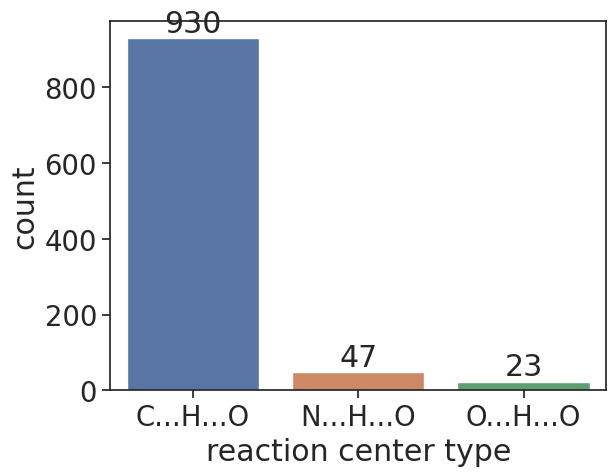

In [21]:
fig = plt.figure()
sns.set(rc = {'figure.figsize':(16,10)})
sns.set(font_scale=1.8)
sns.set_style("ticks")
ax = sns.barplot(x = result.index, y = result.values)
ax.bar_label(ax.containers[0])
ax.set_xlabel('reaction center type')
ax.set_ylabel('count')
fig.savefig('reaction_center_type.png', format='png', dpi=1200, bbox_inches='tight')

## Reaction success analysis

The factor is defined as
(min(bond change in formed and broken bond) - max(bond change in non-reacting bonds)) / std(bond change in non-reacting bonds).

Usually the change in formed and broken bonds are pretty significant. However, there is a tail on the left hand side of the peak that needs more investigation

Text(0, 0.5, 'Count')

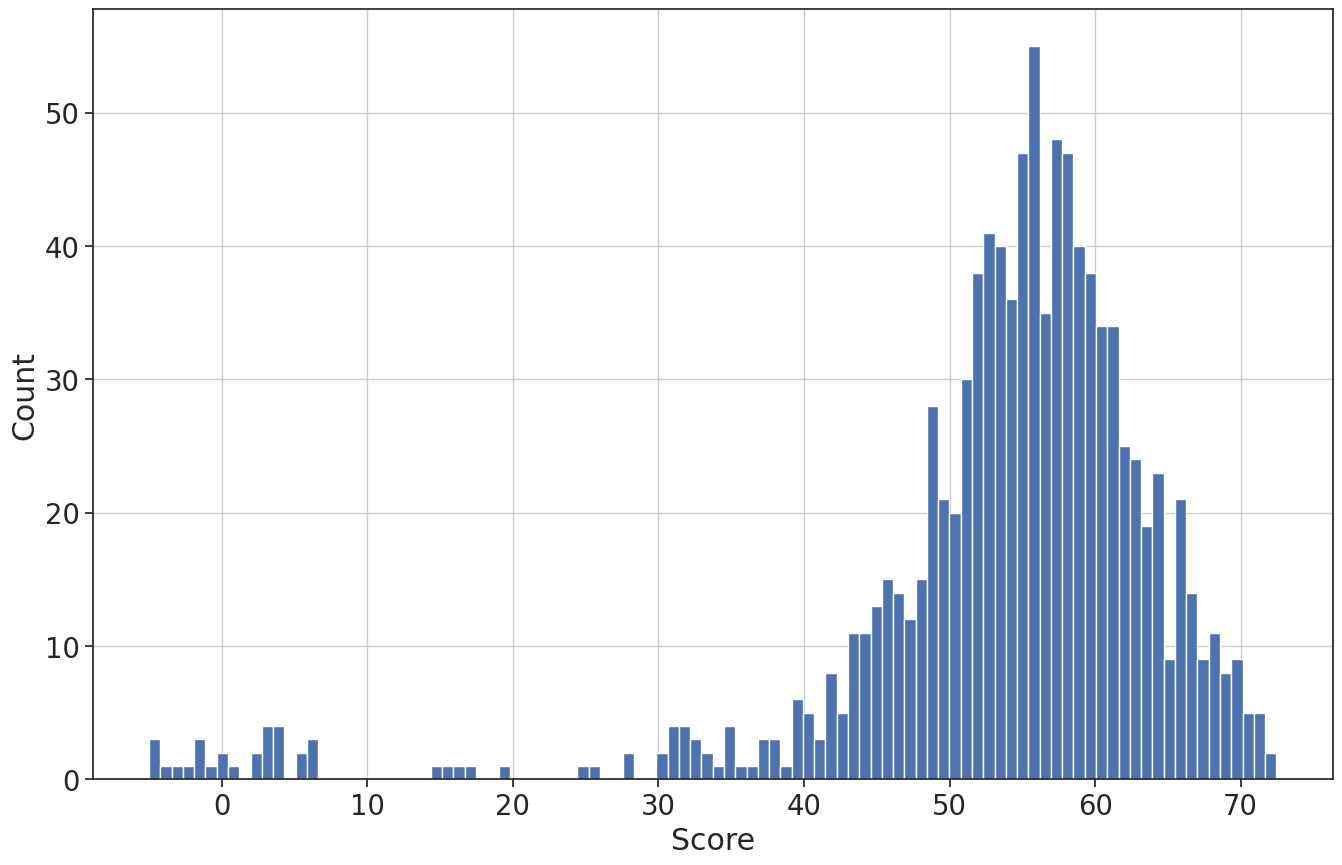

In [23]:
fig = plt.figure()
ax = df_update['test_factor'].hist(bins=100, grid=True)
ax.set_xlabel('Score')
ax.set_ylabel('Count')
# fig.savefig('image/test_factor.png', format='png', dpi=1200, bbox_inches='tight')

In [24]:
potential_bad = df_update[df_update['test_factor'] < 5]
potential_good = df_update[df_update['test_factor'] > 5]

In [25]:
len(potential_bad)

23

In [26]:
len(potential_good)

977

In [27]:
print('Number of good: ', potential_good.shape[0])
print('Ratio of good: ', potential_good.shape[0]/df_update.shape[0])

print('Number of potential bad: ', potential_bad.shape[0])
print('Ratio of potential bad: ', potential_bad.shape[0]/df_update.shape[0])

Number of good:  977
Ratio of good:  0.977
Number of potential bad:  23
Ratio of potential bad:  0.023


There is another check that tries to guess the potential reactants and products based on the normal mode and the molecule perception algorithm.

In [28]:
high_poss_bad = potential_bad[~potential_bad['guess_rxn'].astype('boolean')]
low_poss_bad = potential_bad.drop(index=high_poss_bad.index)

print('Number of bad with higher chance: ', high_poss_bad.shape[0])
print('Ratio of bad with higher chance: ', high_poss_bad.shape[0]/df_update.shape[0])

print('Number of bad with lower chance: ', low_poss_bad.shape[0])
print('Ratio of bad with lower chance: ', low_poss_bad.shape[0]/df_update.shape[0])

Number of bad with higher chance:  15
Ratio of bad with higher chance:  0.015
Number of bad with lower chance:  8
Ratio of bad with lower chance:  0.008


# Drawing function

In [29]:
def draw_ts_bond_pair(df_bond, method1='rdmc_guess', method2='dft'):
    
    guess_color = 'lightgray'
    guess_alpha = 0.2

    converged_size = 100
    converged_alpha = 0.2

    success_size = 150
    success_alpha = 0.6

    hue_norm = (-2000,0)
    
    label1 = 'ROO'
    label2 = df_bond['ts_r2_atom_symbol'][0]

    fig, axes = plt.subplots(1,1, figsize=(10, 10))

    for _, row in df_bond.iterrows():
        axes.plot(row[[f'{method1}_r_TS_R1O', f'{method2}_r_TS_R1O']],  # bond TS-ROO
                     row[[f'{method1}_r_TS_R2E', f'{method2}_r_TS_R2E']],  # bond TS-R2
                     '--', color=guess_color, alpha=guess_alpha, zorder=-2)

    axes.scatter(data=df_bond,
                    x=f'{method1}_r_TS_R1O', y=f'{method1}_r_TS_R2E',
                    color=guess_color, alpha=guess_alpha,
                    label=method1, zorder=-1)

    axes.scatter(data=df_bond,
                    x=f'{method2}_r_TS_R1O', y=f'{method2}_r_TS_R2E',
                    color='none', marker='o', edgecolors='r',
                    s=success_size, alpha=success_alpha,
                    label=method2, zorder=0.5)

    sns.scatterplot(data=df_bond,
                    x=f'{method2}_r_TS_R1O', y=f'{method2}_r_TS_R2E',
                    s=converged_size,
                    hue='dft_freq_neg',
                    hue_norm=(-2000, 0),
                    palette='viridis_r',
                    legend=True,
                    ax=axes,
                    alpha=converged_alpha,
                    zorder=0.5)
    
    leg = axes.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=1)
    
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        
    axes.set(xlabel=f'{label1}...H' + ' Bond ($\mathrm{\AA}$)',
                ylabel=f'{label2}...H' + ' Bond ($\mathrm{\AA}$)')
    
    return plt, fig, axes

In [30]:
def draw_ts_angle_dihedral(df_bond, method1='rdmc_guess', method2='dft'):
    
    guess_color = 'lightgray'
    guess_alpha = 0.2

    converged_size = 100
    converged_alpha = 0.2

    success_size = 150
    success_alpha = 0.6

    hue_norm = (-2000,0)
    
    label1 = 'ROO'
    label2 = df_bond['ts_r2_atom_symbol'][0]

    fig, axes = plt.subplots(1,1, figsize=(10, 10))

    for _, row in df_bond.iterrows():
        axes.plot(row[[f'{method1}_a_R2E_TS_R1O', f'{method2}_a_R2E_TS_R1O']],  # angle R2E-TS-ROO
                     row[[f'{method1}_d_R2X_R2E_R1O_R1OO', f'{method2}_d_R2X_R2E_R1O_R1OO']],  # dihedral R2X-R2E-R1O-R1OO
                     '--', color=guess_color, alpha=guess_alpha, zorder=-2)

    axes.scatter(data=df_bond,
                    x=f'{method1}_a_R2E_TS_R1O', y=f'{method1}_d_R2X_R2E_R1O_R1OO',
                    color=guess_color, alpha=guess_alpha,
                    label=method1, zorder=-1)

    axes.scatter(data=df_bond,
                    x=f'{method2}_a_R2E_TS_R1O', y=f'{method2}_d_R2X_R2E_R1O_R1OO',
                    color='none', marker='o', edgecolors='r',
                    s=success_size, alpha=success_alpha,
                    label=method2, zorder=0.5)

    sns.scatterplot(data=df_bond,
                    x=f'{method2}_a_R2E_TS_R1O', y=f'{method2}_d_R2X_R2E_R1O_R1OO',
                    s=converged_size,
                    hue='dft_freq_neg',
                    hue_norm=(-2000, 0),
                    palette='viridis_r',
                    legend=True,
                    ax=axes,
                    alpha=converged_alpha,
                    zorder=0.5)
    
    leg = axes.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=1)
    
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        
    axes.set(xlabel=f'{label1}...H...{label2}' + ' Angle ($^{\circ}$)',
                ylabel=f'RO-O...{label2}-X' + ' Dihedral ($^{\circ}$)')
    
    return plt, fig, axes

In [31]:
def draw_ts_angle_pair(df_bond, method1='rdmc_guess', method2='dft'):
    
    guess_color = 'lightgray'
    guess_alpha = 0.2

    converged_size = 100
    converged_alpha = 0.2

    success_size = 150
    success_alpha = 0.6

    hue_norm = (-2000,0)
    
    label1 = 'ROO'
    label2 = df_bond['ts_r2_atom_symbol'][0]

    fig, axes = plt.subplots(1,1, figsize=(10, 10))

    for _, row in df_bond.iterrows():
        axes.plot(row[[f'{method1}_a_TS_R1O_R1OO', f'{method2}_a_TS_R1O_R1OO']],  
                     row[[f'{method1}_a_R2X_R2E_TS', f'{method2}_a_R2X_R2E_TS']],  
                     '--', color=guess_color, alpha=guess_alpha, zorder=-2)

    axes.scatter(data=df_bond,
                    x=f'{method1}_a_TS_R1O_R1OO', y=f'{method1}_a_R2X_R2E_TS',
                    color=guess_color, alpha=guess_alpha,
                    label=method1, zorder=-1)

    axes.scatter(data=df_bond,
                    x=f'{method2}_a_TS_R1O_R1OO', y=f'{method2}_a_R2X_R2E_TS',
                    color='none', marker='o', edgecolors='r',
                    s=success_size, alpha=success_alpha,
                    label=method2, zorder=0.5)

    sns.scatterplot(data=df_bond,
                    x=f'{method2}_a_TS_R1O_R1OO', y=f'{method2}_a_R2X_R2E_TS',
                    s=converged_size,
                    hue='dft_freq_neg',
                    hue_norm=(-2000, 0),
                    palette='viridis_r',
                    legend=True,
                    ax=axes,
                    alpha=converged_alpha,
                    zorder=0.5)
    
    leg = axes.legend(bbox_to_anchor=(1.05, 0.5), loc='center left', ncol=1)
    
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        
    axes.set(xlabel=f'H...O-OR' + ' Angle ($^{\circ}$)',
                ylabel=f'H...{label2}-X' + ' Angle ($^{\circ}$)')
    
    return plt, fig, axes

# CHO

In [32]:
df_bond = potential_good[potential_good['reaction_type'] == 'C...H...O']

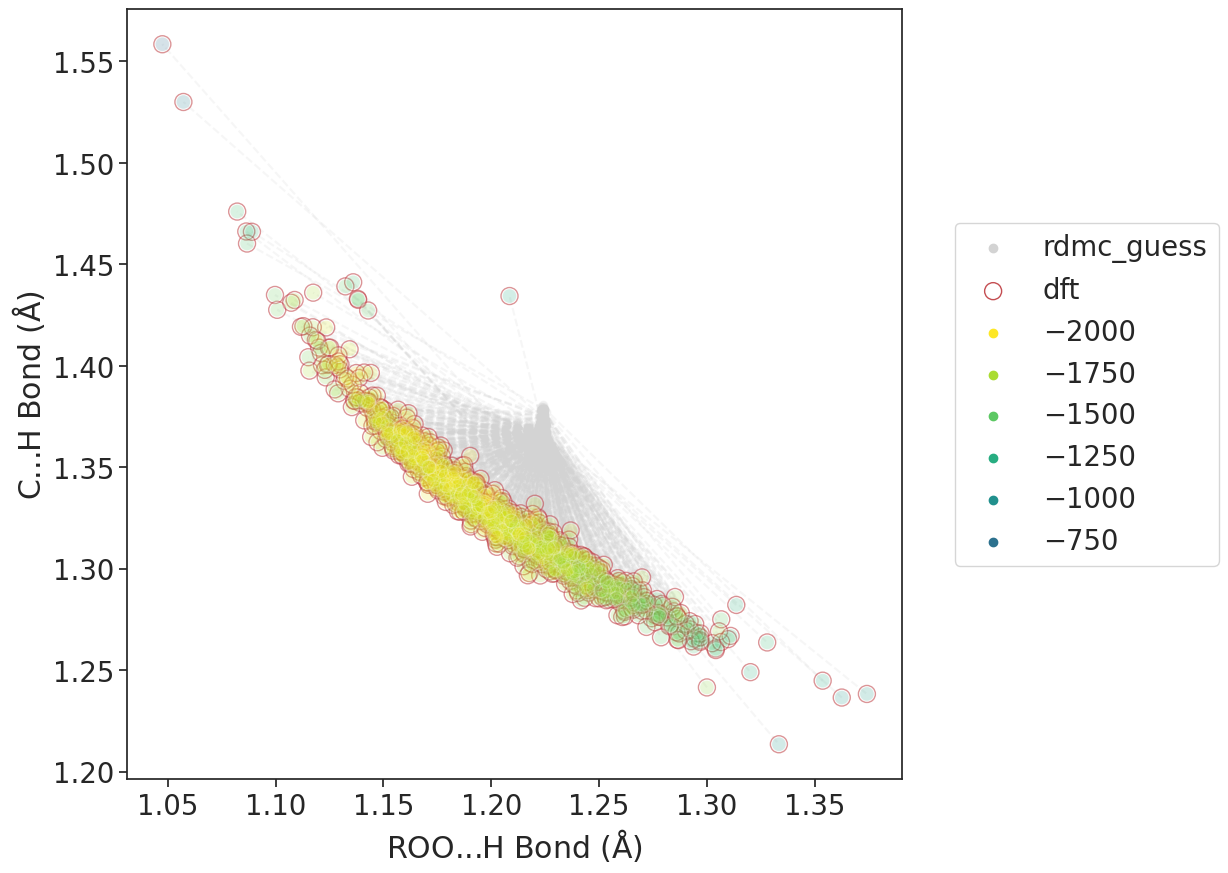

In [33]:
plt, fig, axes = draw_ts_bond_pair(df_bond, method1='rdmc_guess', method2='dft')

In [35]:
# fig.savefig('cho_bond_pair_good_rdmc_dft.png', format='png', dpi=1200, bbox_inches='tight')

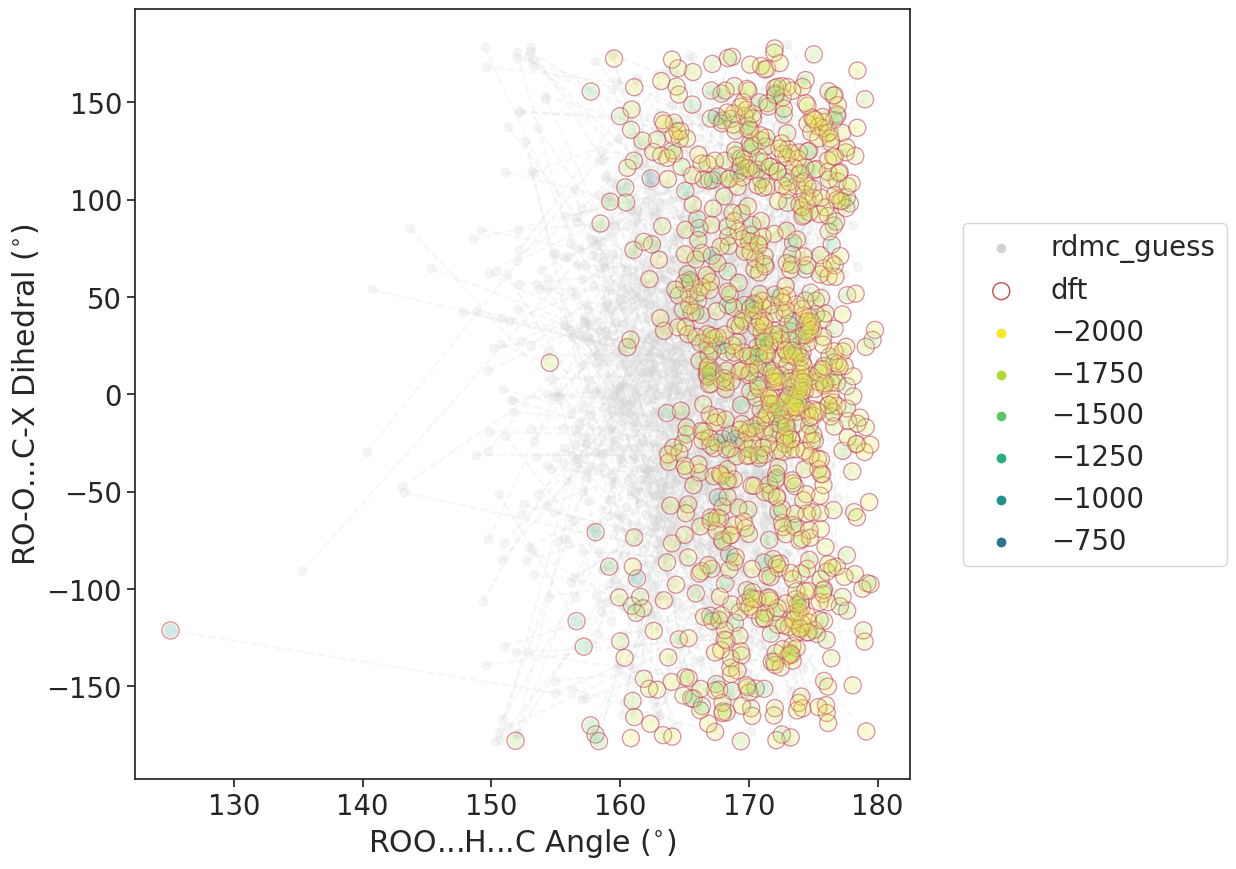

In [36]:
plt2, fig2, axes2 = draw_ts_angle_dihedral(df_bond, method1='rdmc_guess', method2='dft')

In [37]:
# fig2.savefig('cho_dihedral_good_rdmc_dft.png', format='png', dpi=1200, bbox_inches='tight')

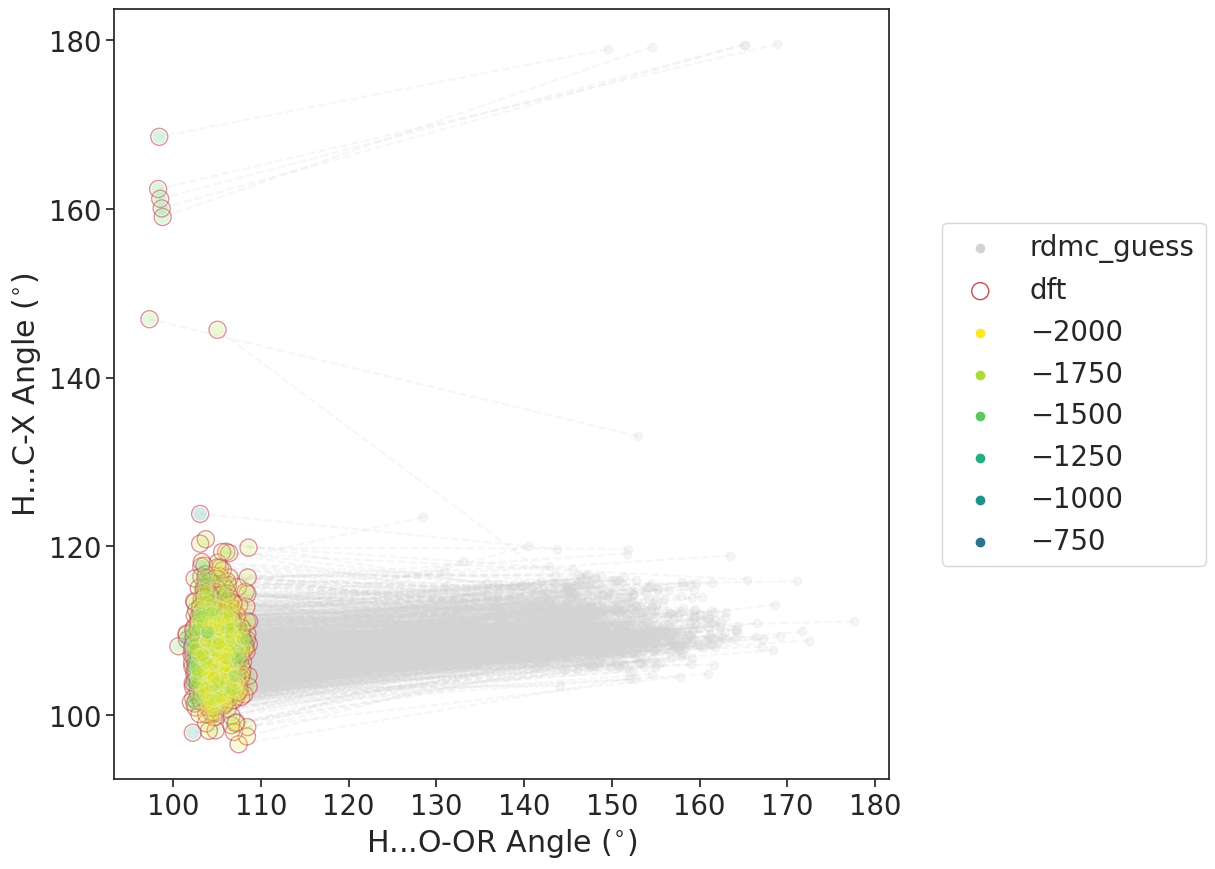

In [38]:
plt3, fig3, axes3 = draw_ts_angle_pair(df_bond, method1='rdmc_guess', method2='dft')

In [39]:
# fig3.savefig('cho_angle_pair_good_rdmc_dft.png', format='png', dpi=1200, bbox_inches='tight')

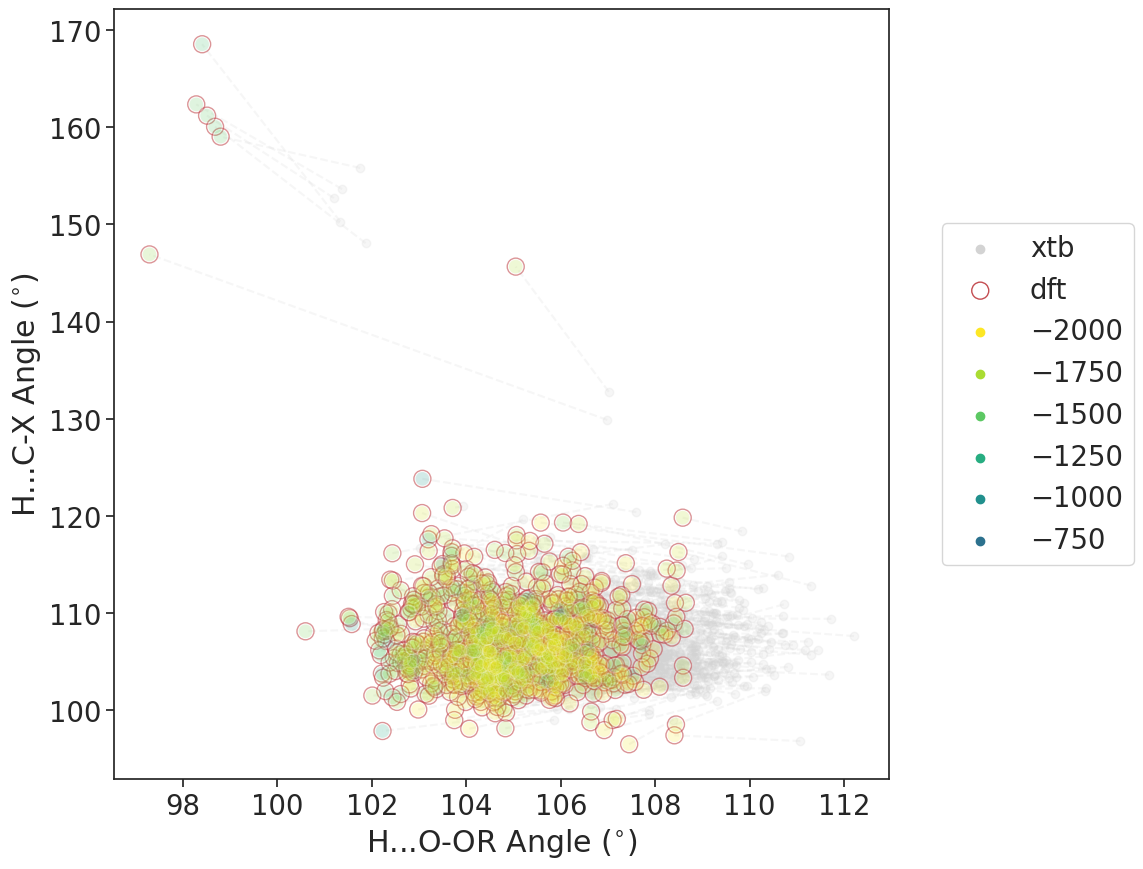

In [40]:
plt4, fig4, axes4 = draw_ts_angle_pair(df_bond, method1='xtb', method2='dft')

In [41]:
# fig4.savefig('cho_angle_pair_good_xtb_dft.png', format='png', dpi=1200, bbox_inches='tight')

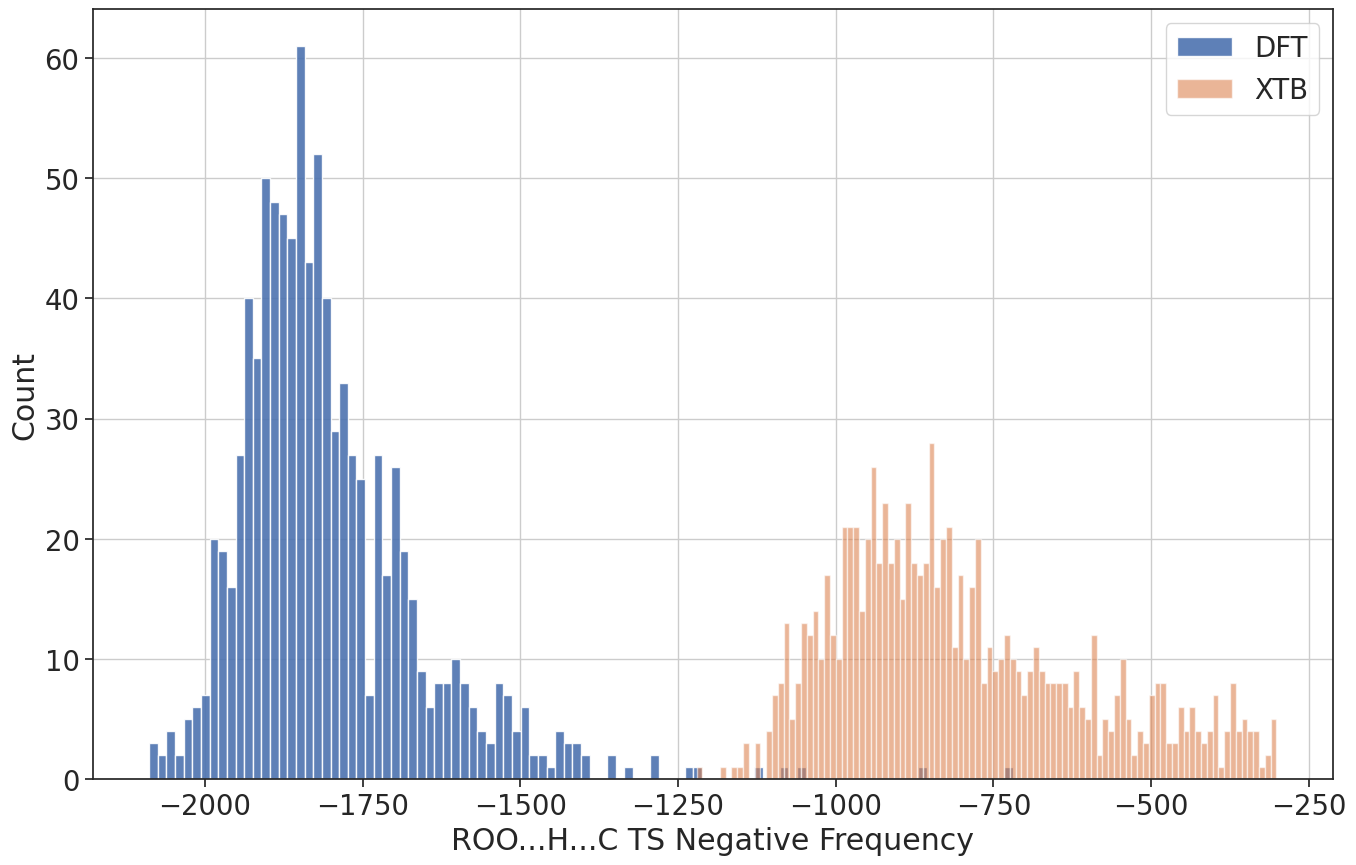

In [42]:
fig = plt.figure()
ax = df_bond['dft_freq_neg'].hist(bins=100, grid=True, alpha=0.9, label='DFT')
ax = df_bond['xtb_freq_neg'].hist(bins=100, grid=True, alpha=0.6, label='XTB')
ax.set_xlabel('ROO...H...C TS Negative Frequency')
ax.set_ylabel('Count')
ax.legend()
# fig.savefig('image/cho_dft_xtb_roo_hts_freq.png', format='png', dpi=1200, bbox_inches='tight')

In [43]:
df_bad = potential_bad[potential_bad['reaction_type'] == 'C...H...O']

In [44]:
df_bad

rxn_smi  \
406b8918bcc0a27d649d4a6bb494e952  [C:8]12([C:9]([C:13]([H:23])([H:24])[H:25])([H...   
9821e13c3d56ac64c098fcb1c9ec08c4  [C:8]([c:10]1[c:11]([N:15]([H:25])[H:26])[n:14...   
a070d88331a596004627c554156f4cb7  [C:8]12([O:15][C:13]([H:20])([H:21])[H:22])[C:...   
297e4b1c2d8eb560ba9a3b849ed591b7  [C:8]12([C:12]([H:19])([H:20])[H:21])[C:9]3([H...   
67f13d357d08d80689117dff0103a6ac  [C:8]12([N:13]([H:22])[H:23])[C:9]([H:17])([C:...   
8b548d95fc0c3968153a1a2ef8e77d2c  [C:8]([N:9]([c:10]1[c:11]([H:20])[c:12]([N:15]...   
e0ac86d99c529bdc78e028d892155d89  [C:8]([C:9]([C:11]([H:21])([H:22])[H:23])([C:1...   
f2d4e7993976f7b5c6054146b2522704  [C:8]12([C:12]([H:19])([H:20])[H:21])[C:9]3([H...   
f63d4721c8a11d2ee0dda6ea4e1c744a  [C:8]1([C:9]([O:13][C:11](=[N:15][H:22])[H:21]...   
f6d0ac059faec158368f0776b523c7b2  [C:8]([C:9]([C:11]([H:20])([H:21])[H:22])([O:1...   
7d708d6249fd29dc4d7f190db5ac8a04  [O:1]([C:4]([O:2][O:3])([H:5])[H:6])[H:7].[O:8...   
bfdc39790ad48cedff575a8bcb35b720  [C:8]([C:10]([H:19])([H:20])[H:21])([C:12]([O:...   
d68cfb24365d4cddf7c6e91518bd2bb9  [C:8]12([C:14]([H:20])([H:21])[H:22])[C:9]3([O...   
caa5889066e58ef983afbc8ef2e2169a  [C:8]1([C:13]([H:23])([H:24])[H:25])([H:18])[C...   
12bbf855f13764827e6c5a96eb303952  [C:8]12([O:14][H:20])[C:9]3([O:15][H:21])[C:10...   
323a6d7d82dd58d3496bc71fce07ca54  [C:8]1([C:11]([H:19])([H:20])[H:21])([H:16])[C...   
134ea1ce1d0c360d56713962c4ef2189  [C:8]12([O:13][H:23])[C:9]([H:16])([C:10]1([O:...   

                                                                           dft_freq  \
406b8918bcc0a27d649d4a6bb494e952  [-1316.4644, 26.6163, 30.2066, 63.1359, 70.564...   
9821e13c3d56ac64c098fcb1c9ec08c4  [-572.0958, 38.5952, 48.1495, 78.8094, 87.6021...   
a070d88331a596004627c554156f4cb7  [-891.8225, 26.6215, 67.4837, 80.1889, 105.287...   
297e4b1c2d8eb560ba9a3b849ed591b7  [-385.2517, 28.3245, 56.2702, 64.3297, 77.4279...   
67f13d357d08d80689117dff0103a6ac  [-334.8423, 20.6679, 41.7196, 63.5694, 80.2756...   
8b548d95fc0c3968153a1a2ef8e77d2c  [-848.1316, 37.5684, 57.9258, 70.5956, 89.2266...   
e0ac86d99c529bdc78e028d892155d89  [-1229.92, 39.3359, 61.4721, 83.2698, 105.768,...   
f2d4e7993976f7b5c6054146b2522704  [-321.1422, 27.8201, 69.1115, 75.9748, 97.0886...   
f63d4721c8a11d2ee0dda6ea4e1c744a  [-1140.7099, 42.0454, 55.9127, 68.7039, 113.75...   
f6d0ac059faec158368f0776b523c7b2  [-1151.5046, 45.3555, 52.9571, 79.8669, 83.711...   
7d708d6249fd29dc4d7f190db5ac8a04  [-1333.8758, 12.3909, 29.8251, 41.3733, 84.200...   
bfdc39790ad48cedff575a8bcb35b720  [-479.9458, 21.1922, 29.4902, 47.3415, 77.6403...   
d68cfb24365d4cddf7c6e91518bd2bb9  [-1262.9742, 55.2282, 94.4265, 118.3026, 128.4...   
caa5889066e58ef983afbc8ef2e2169a  [-1340.584, 11.1186, 32.4281, 45.2268, 97.1745...   
12bbf855f13764827e6c5a96eb303952  [-983.5948, 47.6317, 75.2871, 110.4565, 130.05...   
323a6d7d82dd58d3496bc71fce07ca54  [-1354.5457, 11.2956, 34.0195, 37.3862, 81.416...   
134ea1ce1d0c360d56713962c4ef2189  [-846.2135, 28.9251, 59.4628, 70.6678, 123.370...   

                                  dft_freq_neg  \
406b8918bcc0a27d649d4a6bb494e952    -1316.4644   
9821e13c3d56ac64c098fcb1c9ec08c4     -572.0958   
a070d88331a596004627c554156f4cb7     -891.8225   
297e4b1c2d8eb560ba9a3b849ed591b7     -385.2517   
67f13d357d08d80689117dff0103a6ac     -334.8423   
8b548d95fc0c3968153a1a2ef8e77d2c     -848.1316   
e0ac86d99c529bdc78e028d892155d89    -1229.9200   
f2d4e7993976f7b5c6054146b2522704     -321.1422   
f63d4721c8a11d2ee0dda6ea4e1c744a    -1140.7099   
f6d0ac059faec158368f0776b523c7b2    -1151.5046   
7d708d6249fd29dc4d7f190db5ac8a04    -1333.8758   
bfdc39790ad48cedff575a8bcb35b720     -479.9458   
d68cfb24365d4cddf7c6e91518bd2bb9    -1262.9742   
caa5889066e58ef983afbc8ef2e2169a    -1340.5840   
12bbf855f13764827e6c5a96eb303952     -983.5948   
323a6d7d82dd58d3496bc71fce07ca54    -1354.5457   
134ea1ce1d0c360d56713962c4ef2189     -846.2135   

                                         

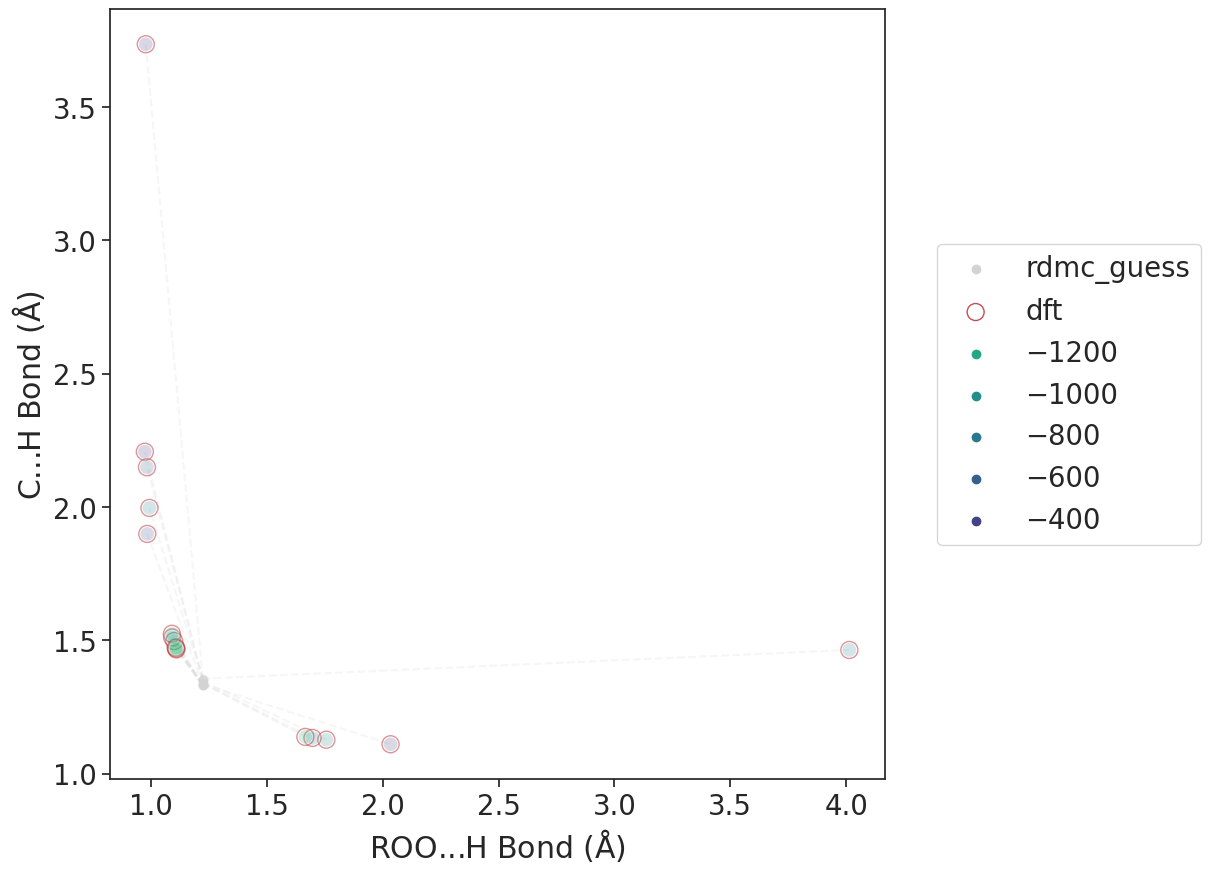

In [45]:
plt5, fig5, axes5 = draw_ts_bond_pair(df_bad, method1='rdmc_guess', method2='dft')

In [46]:
# fig5.savefig('cho_bond_pair_bad_rdmc_dft.png', format='png', dpi=1200, bbox_inches='tight')

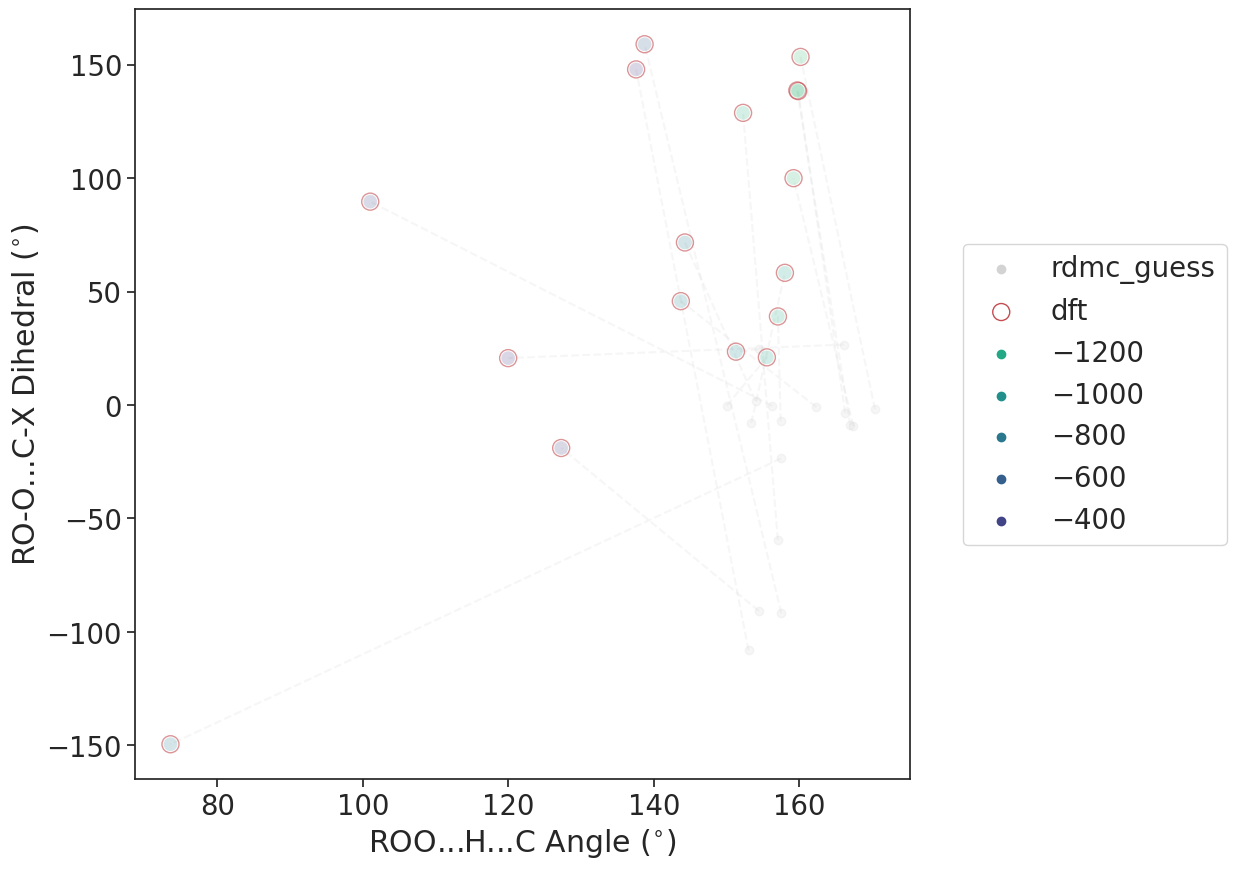

In [47]:
plt6, fig6, axes6 = draw_ts_angle_dihedral(df_bad, method1='rdmc_guess', method2='dft')

In [48]:
# fig6.savefig('cho_dihedral_bad_rdmc_dft.png', format='png', dpi=1200, bbox_inches='tight')

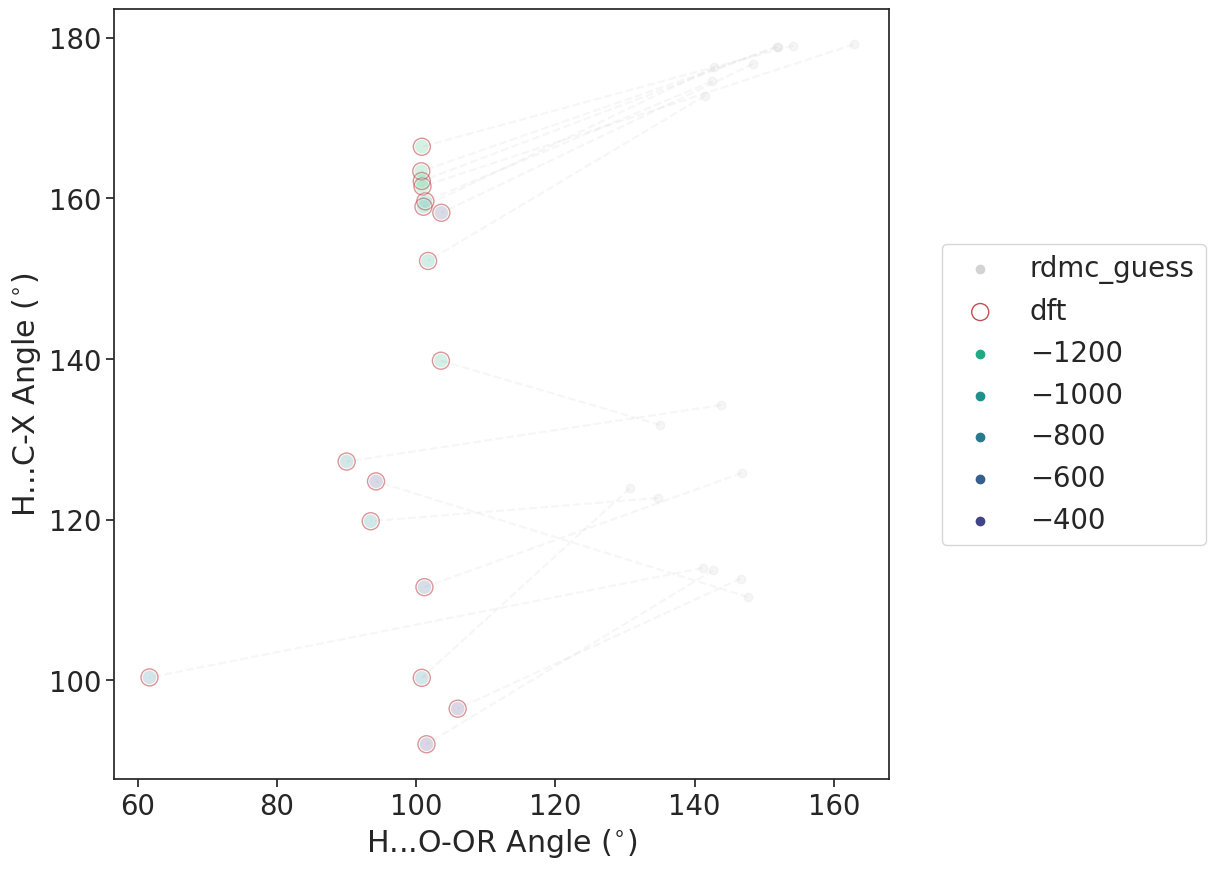

In [49]:
plt7, fig7, axes7 = draw_ts_angle_pair(df_bad, method1='rdmc_guess', method2='dft')

In [50]:
# fig7.savefig('cho_angle_bad_rdmc_dft.png', format='png', dpi=1200, bbox_inches='tight')

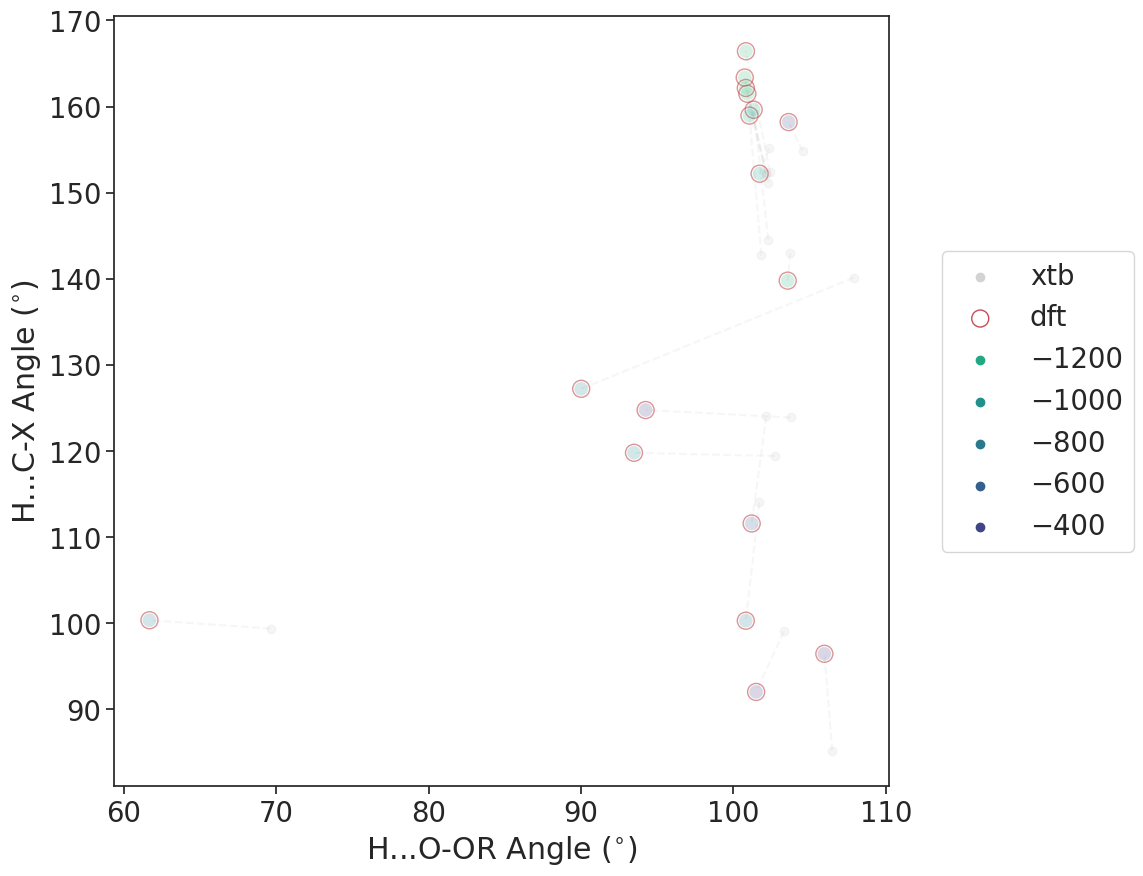

In [51]:
plt8, fig8, axes8 = draw_ts_angle_pair(df_bad, method1='xtb', method2='dft')

In [52]:
# fig8.savefig('cho_angle_bad_xtb_dft.png', format='png', dpi=1200, bbox_inches='tight')

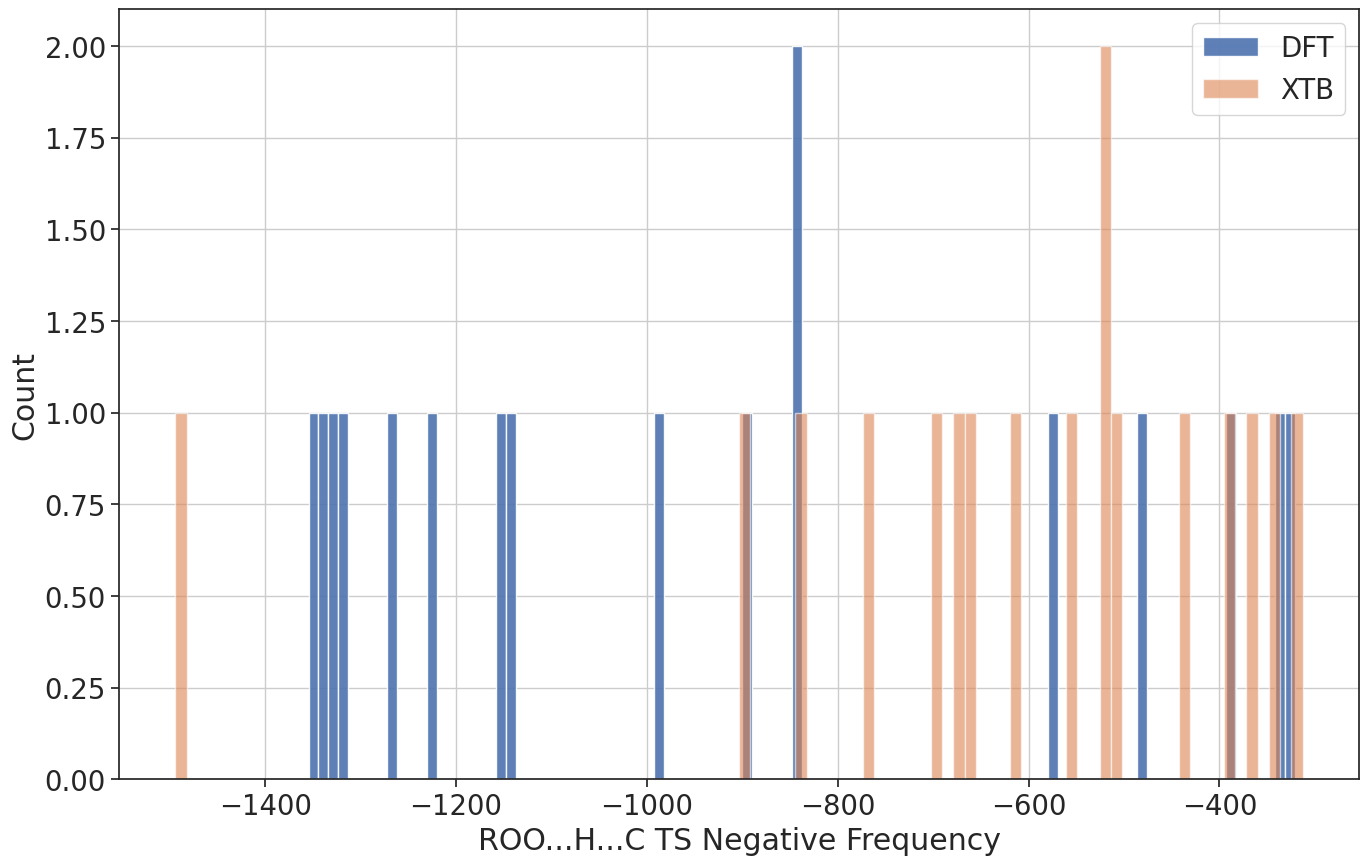

In [53]:
fig = plt.figure()
ax = df_bad['dft_freq_neg'].hist(bins=100, grid=True, alpha=0.9, label='DFT')
ax = df_bad['xtb_freq_neg'].hist(bins=100, grid=True, alpha=0.6, label='XTB')
ax.set_xlabel('ROO...H...C TS Negative Frequency')
ax.set_ylabel('Count')
ax.legend()
# fig.savefig('image/cho_dft_xtb_roo_hts_freq_bad.png', format='png', dpi=1200, bbox_inches='tight')

# NHO

In [54]:
df_bond = potential_good[potential_good['reaction_type'] == 'N...H...O']

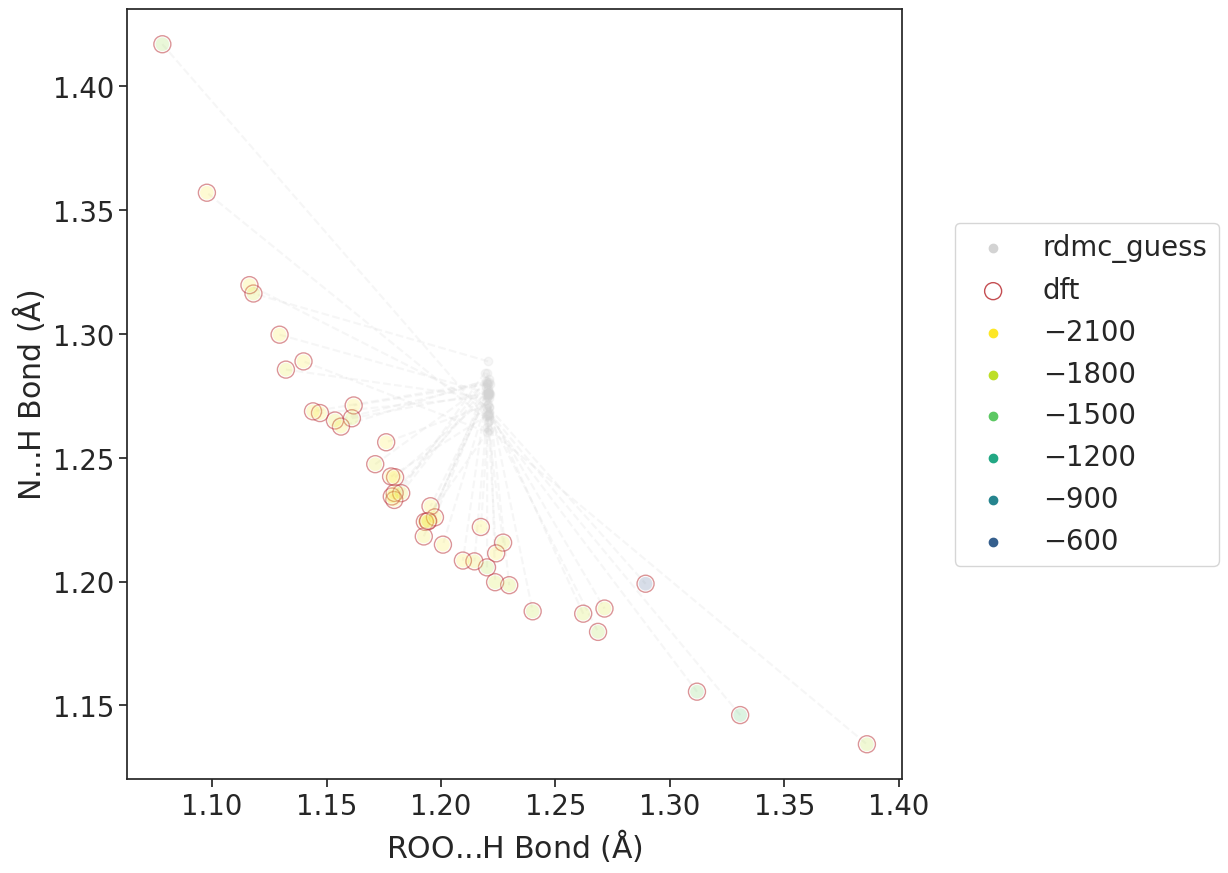

In [55]:
plt9, fig9, axes9 = draw_ts_bond_pair(df_bond, method1='rdmc_guess', method2='dft')

In [56]:
# fig9.savefig('nho_bond_pair_good_rdmc_dft.png', format='png', dpi=1200, bbox_inches='tight')

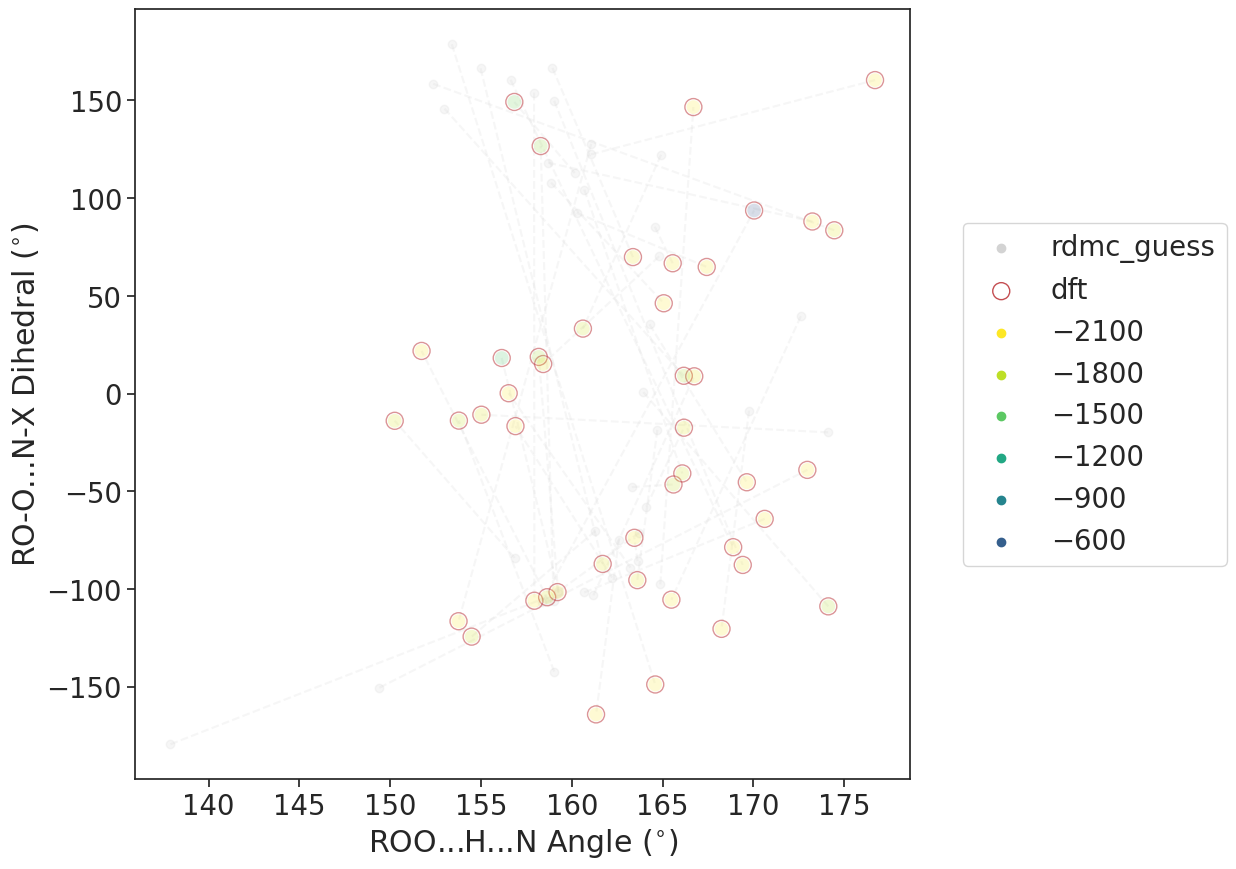

In [57]:
plt10, fig10, axes10 = draw_ts_angle_dihedral(df_bond, method1='rdmc_guess', method2='dft')

In [58]:
# fig10.savefig('nho_dihedral_good_rdmc_dft.png', format='png', dpi=1200, bbox_inches='tight')

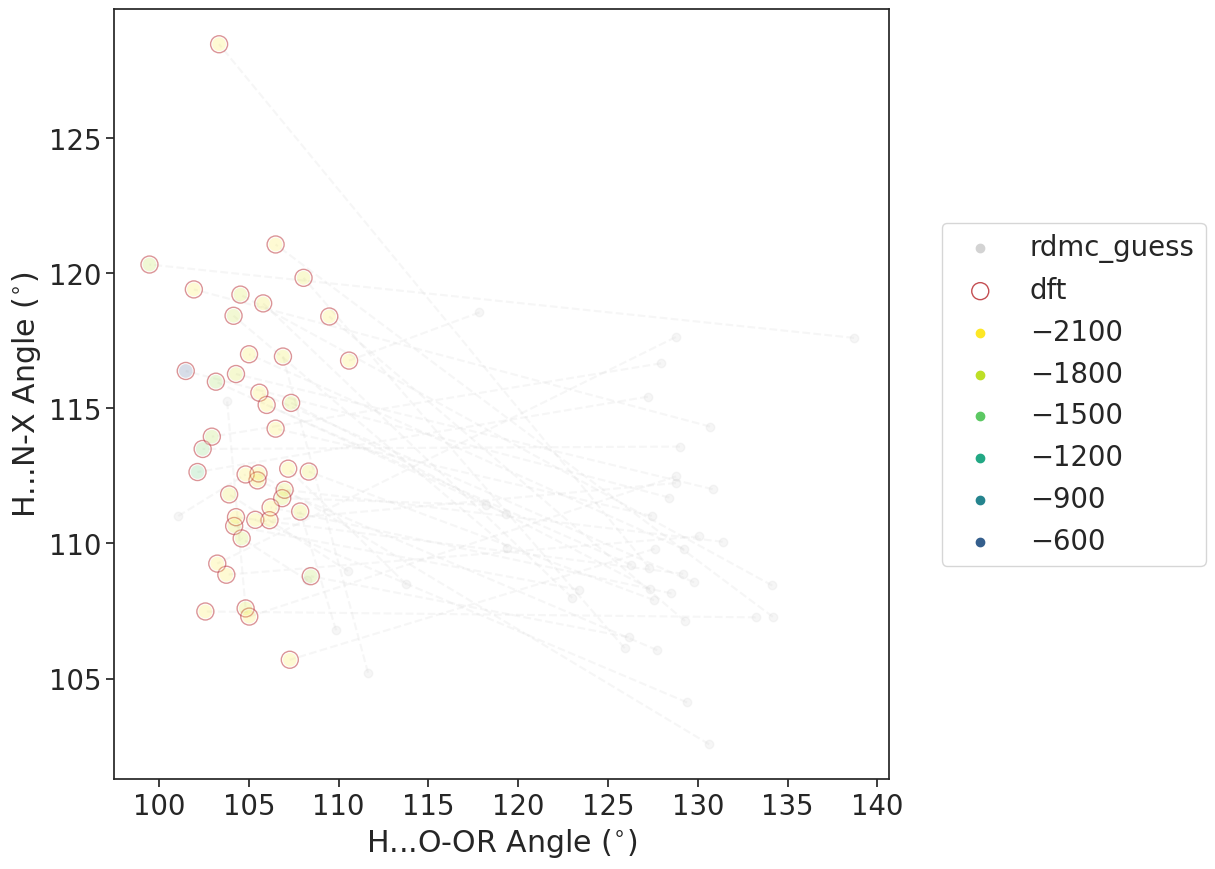

In [59]:
plt11, fig11, axes11 = draw_ts_angle_pair(df_bond, method1='rdmc_guess', method2='dft')

In [60]:
# fig11.savefig('nho_angle_pair_good_rdmc_dft.png', format='png', dpi=1200, bbox_inches='tight')

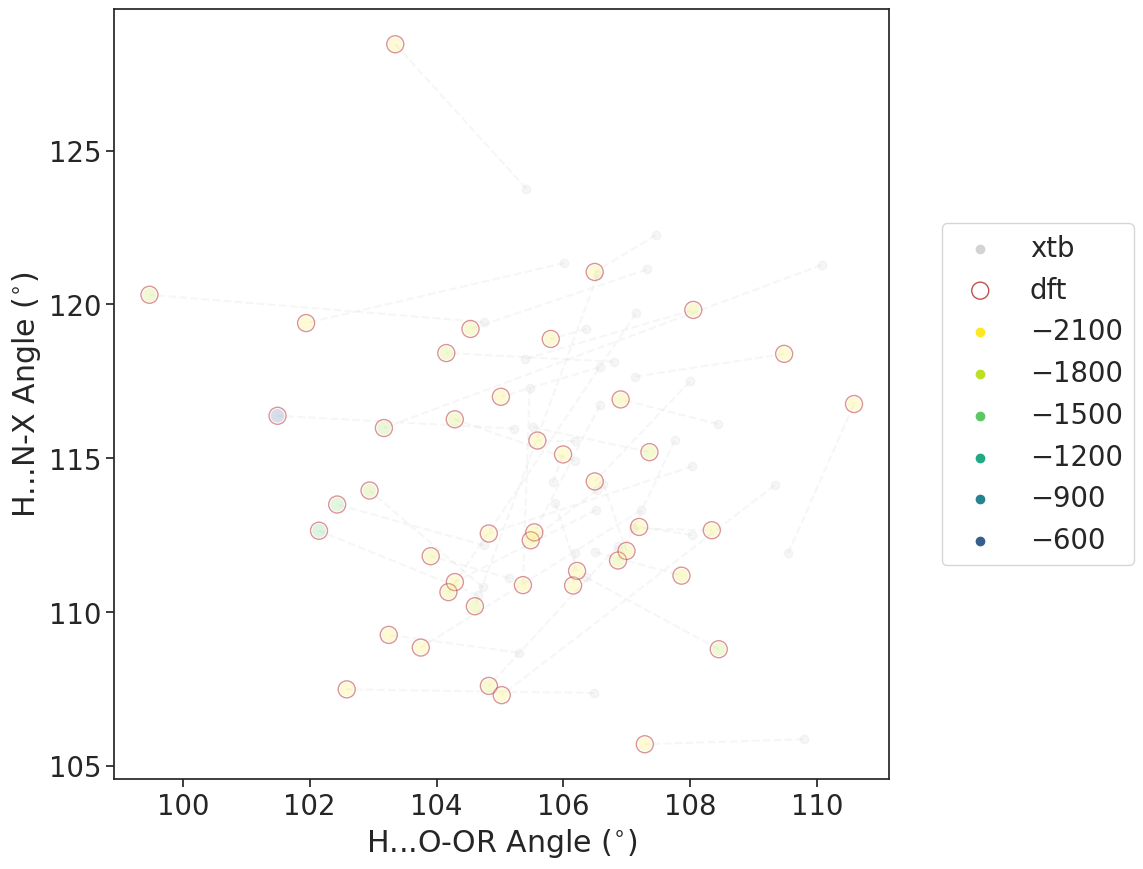

In [61]:
plt12, fig12, axes12 = draw_ts_angle_pair(df_bond, method1='xtb', method2='dft')

In [212]:
# fig12.savefig('nho_angle_pair_good_xtb_dft.png', format='png', dpi=1200, bbox_inches='tight')

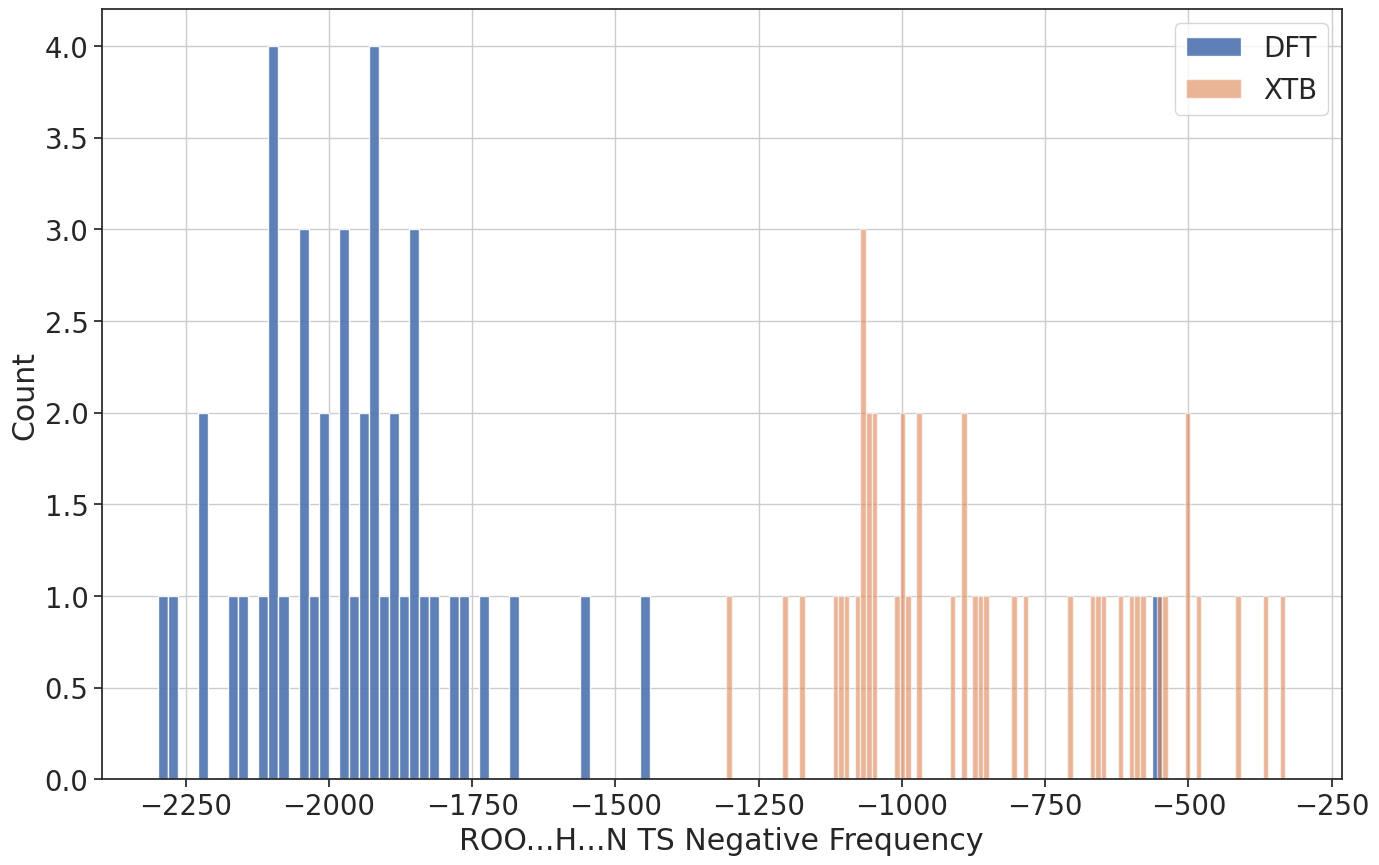

In [62]:
fig = plt.figure()
ax = df_bond['dft_freq_neg'].hist(bins=100, grid=True, alpha=0.9, label='DFT')
ax = df_bond['xtb_freq_neg'].hist(bins=100, grid=True, alpha=0.6, label='XTB')
ax.set_xlabel('ROO...H...N TS Negative Frequency')
ax.set_ylabel('Count')
ax.legend()
# fig.savefig('image/nho_dft_xtb_roo_hts_freq.png', format='png', dpi=1200, bbox_inches='tight')

In [63]:
df_bad = potential_bad[potential_bad['reaction_type'] == 'N...H...O']

In [64]:
# df_bad

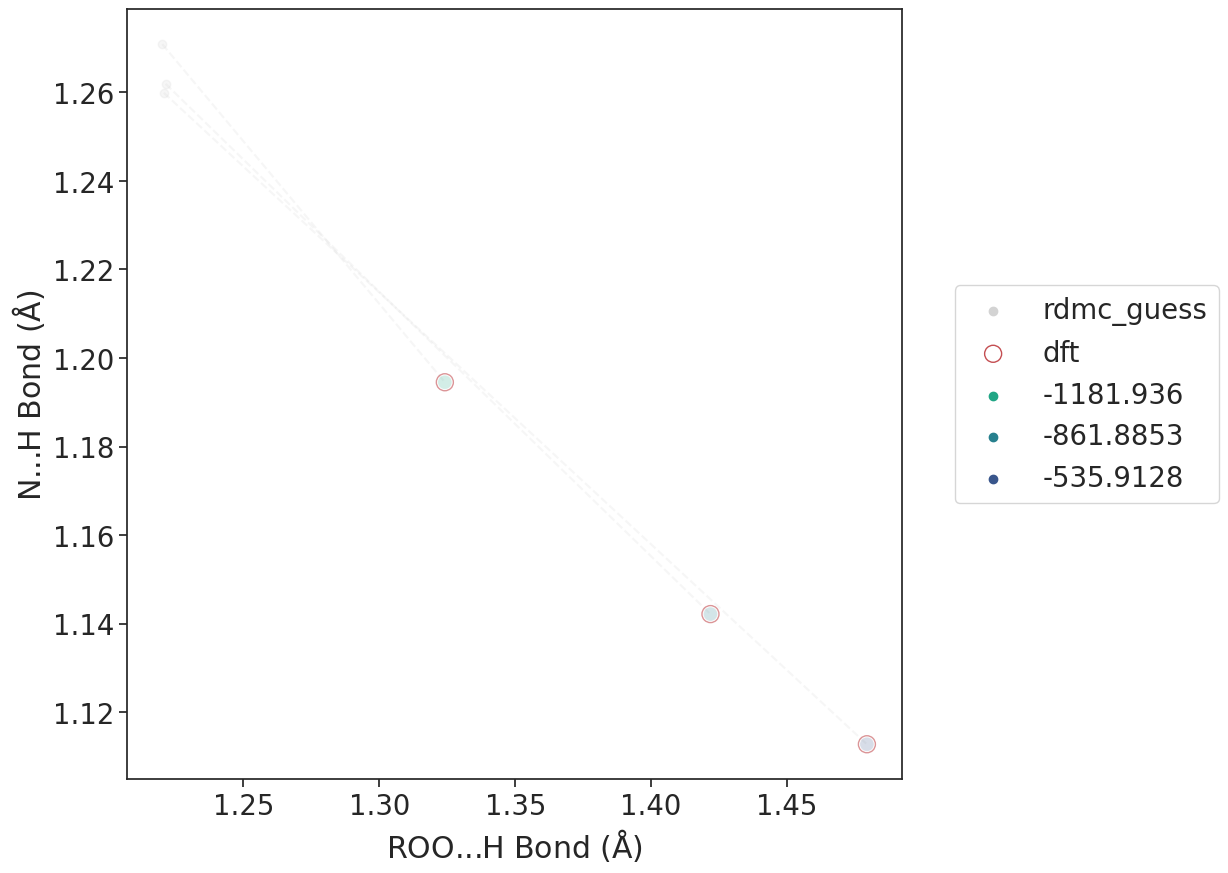

In [65]:
plt13, fig13, axes13 = draw_ts_bond_pair(df_bad, method1='rdmc_guess', method2='dft')

In [66]:
# fig13.savefig('nho_bond_pair_bad_rdmc_dft.png', format='png', dpi=1200, bbox_inches='tight')

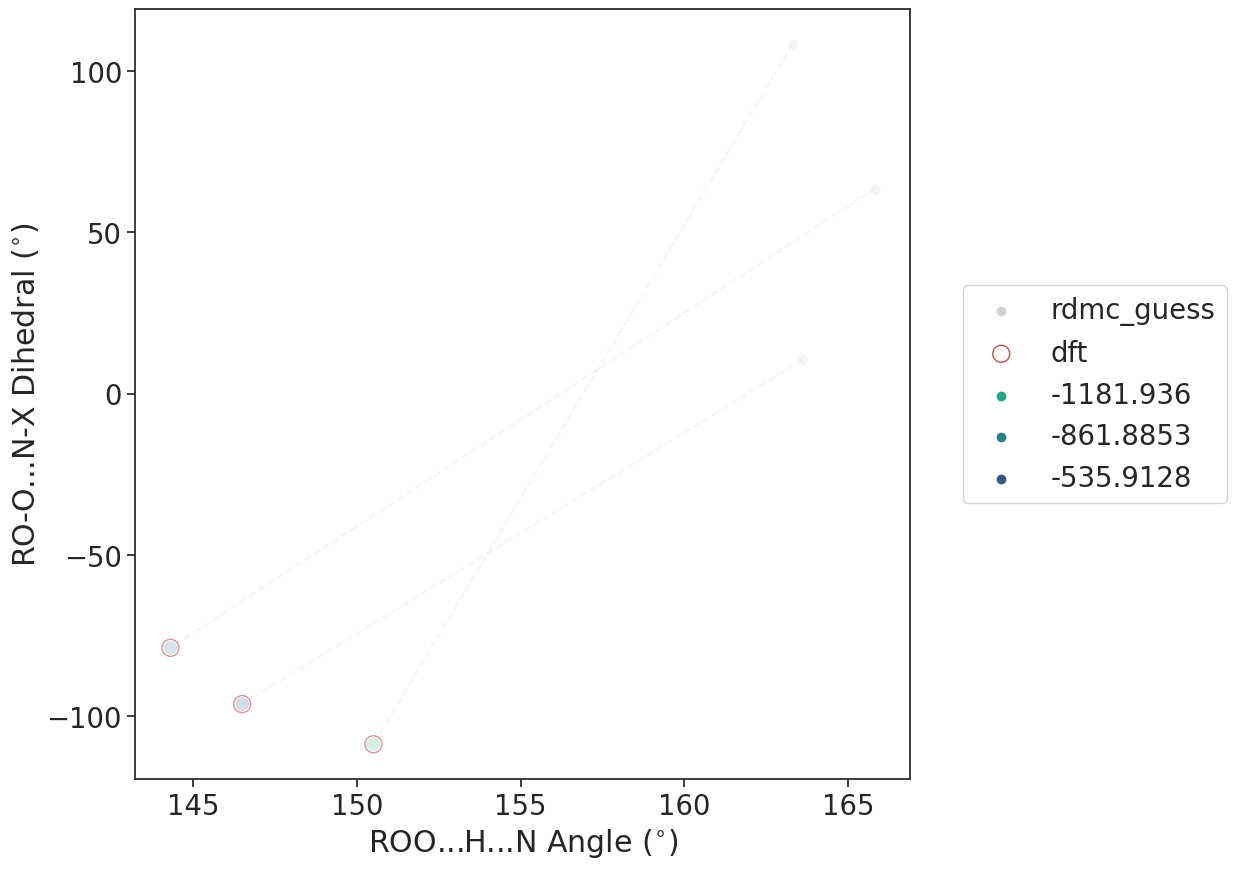

In [67]:
plt14, fig14, axes14 = draw_ts_angle_dihedral(df_bad, method1='rdmc_guess', method2='dft')

In [68]:
# fig14.savefig('nho_dihedral_bad_rdmc_dft.png', format='png', dpi=1200, bbox_inches='tight')

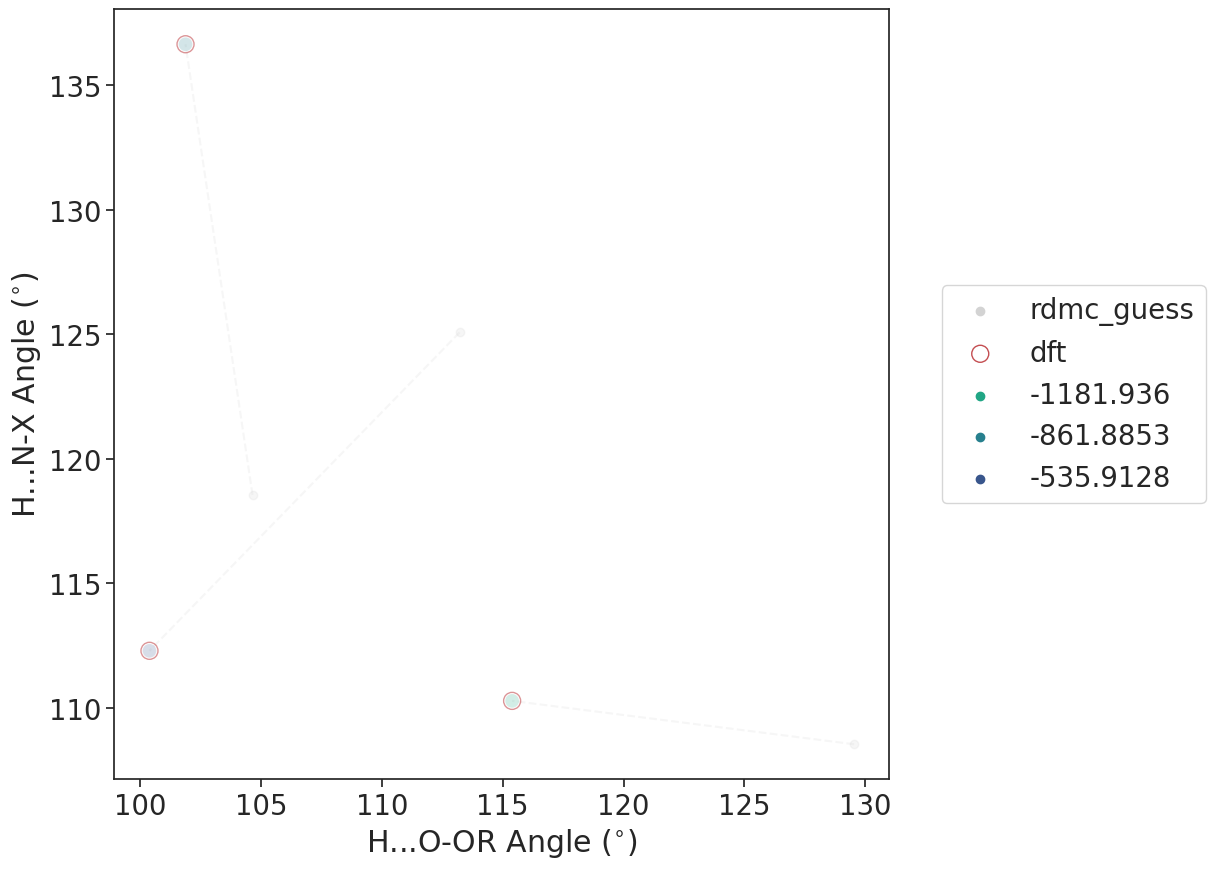

In [69]:
plt15, fig15, axes15 = draw_ts_angle_pair(df_bad, method1='rdmc_guess', method2='dft')

In [70]:
# fig15.savefig('nho_angle_bad_rdmc_dft.png', format='png', dpi=1200, bbox_inches='tight')

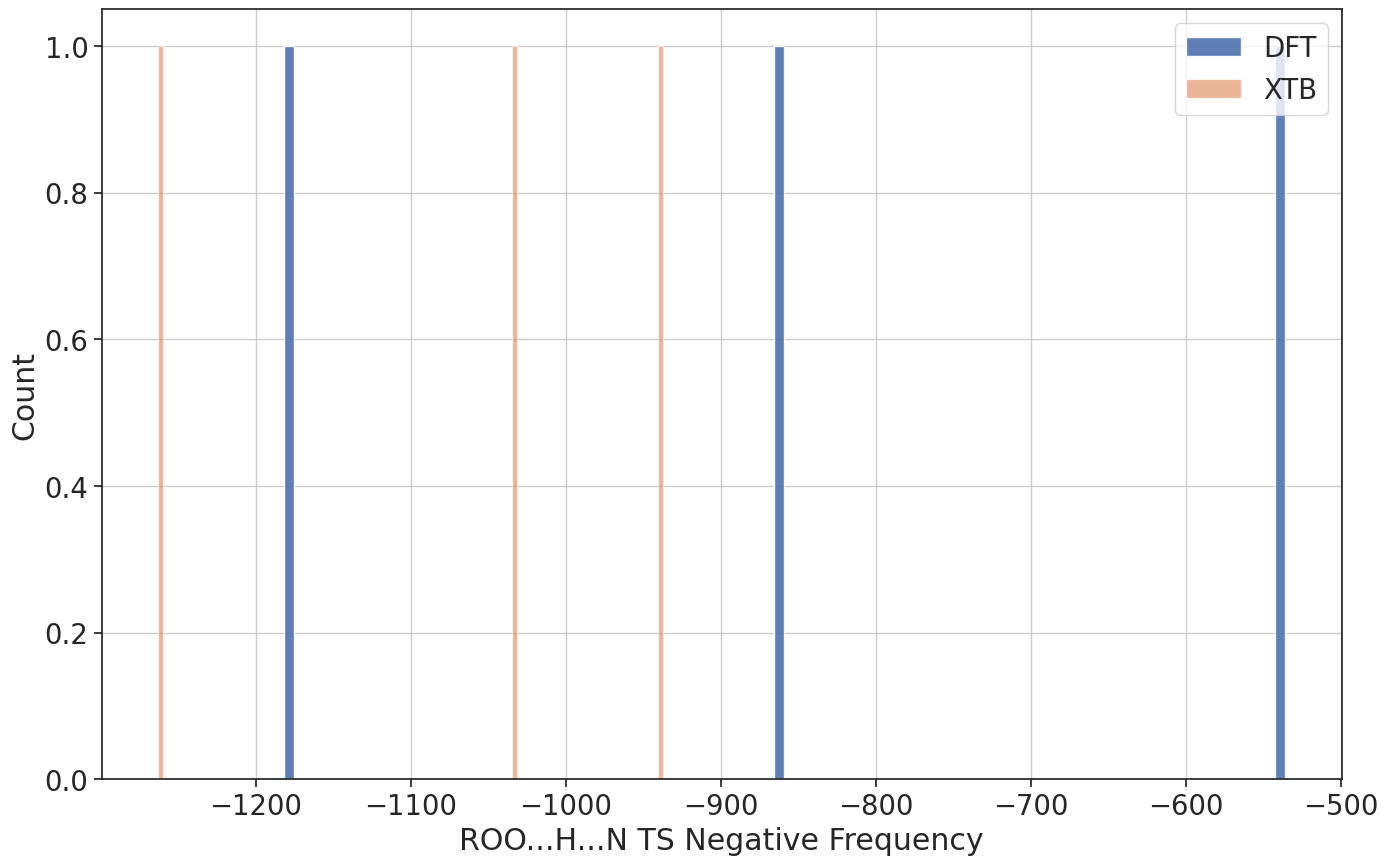

In [71]:
fig = plt.figure()
ax = df_bad['dft_freq_neg'].hist(bins=100, grid=True, alpha=0.9, label='DFT')
ax = df_bad['xtb_freq_neg'].hist(bins=100, grid=True, alpha=0.6, label='XTB')
ax.set_xlabel('ROO...H...N TS Negative Frequency')
ax.set_ylabel('Count')
ax.legend()
# fig.savefig('image/nho_dft_xtb_roo_hts_freq_bad.png', format='png', dpi=1200, bbox_inches='tight')

# OHO

In [72]:
df_bond = potential_good[potential_good['reaction_type'] == 'O...H...O']

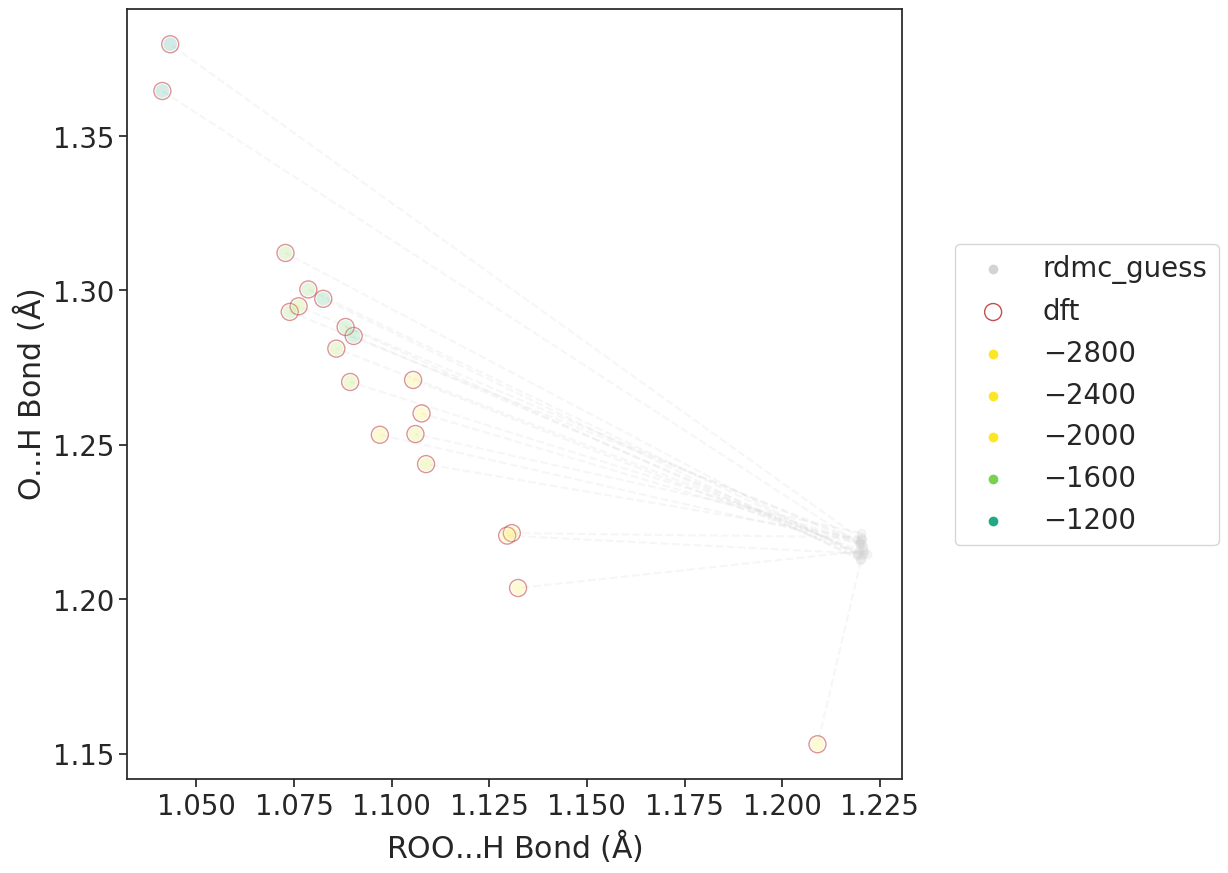

In [73]:
plt16, fig16, axes16 = draw_ts_bond_pair(df_bond, method1='rdmc_guess', method2='dft')

In [74]:
# fig16.savefig('oho_bond_pair_good_rdmc_dft.png', format='png', dpi=1200, bbox_inches='tight')

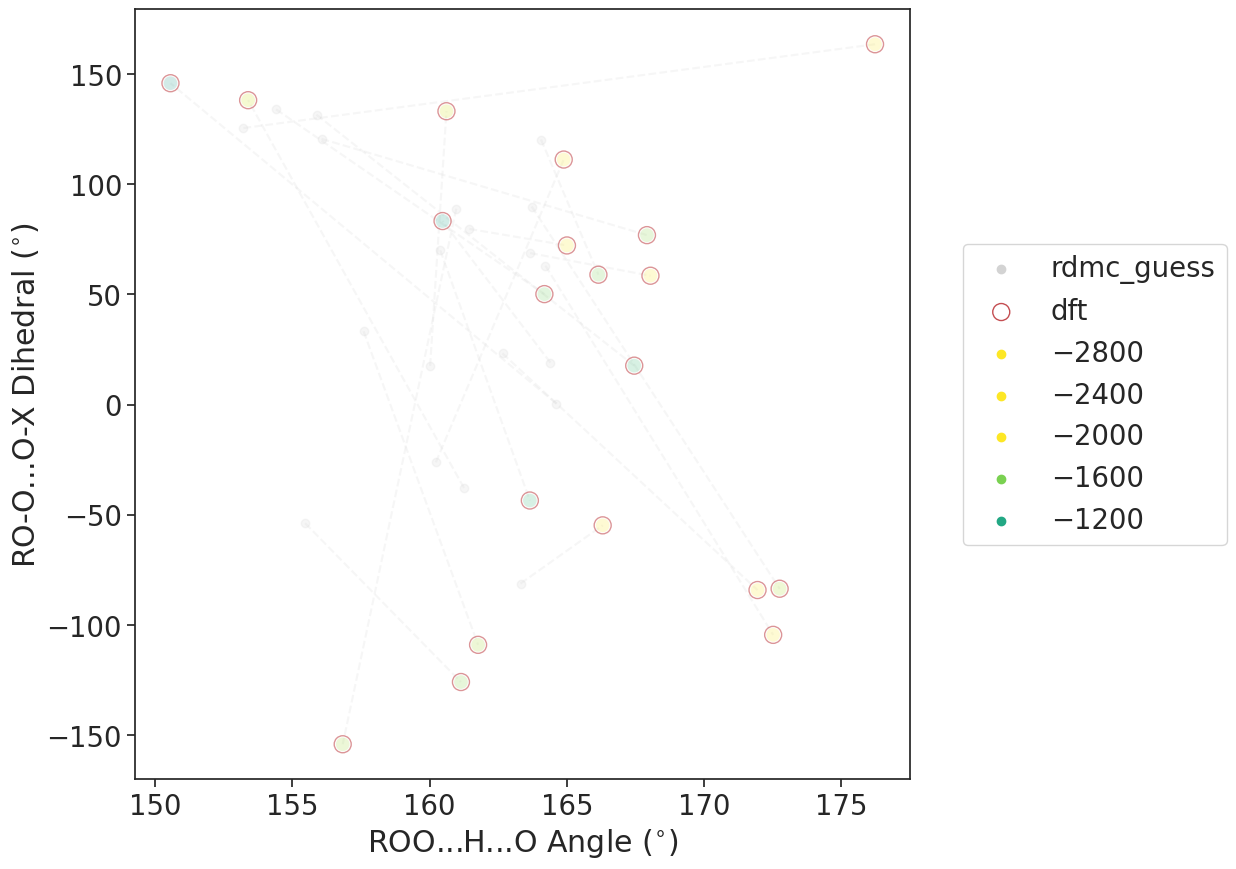

In [75]:
plt17, fig17, axes17 = draw_ts_angle_dihedral(df_bond, method1='rdmc_guess', method2='dft')

In [76]:
# fig17.savefig('oho_dihedral_good_rdmc_dft.png', format='png', dpi=1200, bbox_inches='tight')

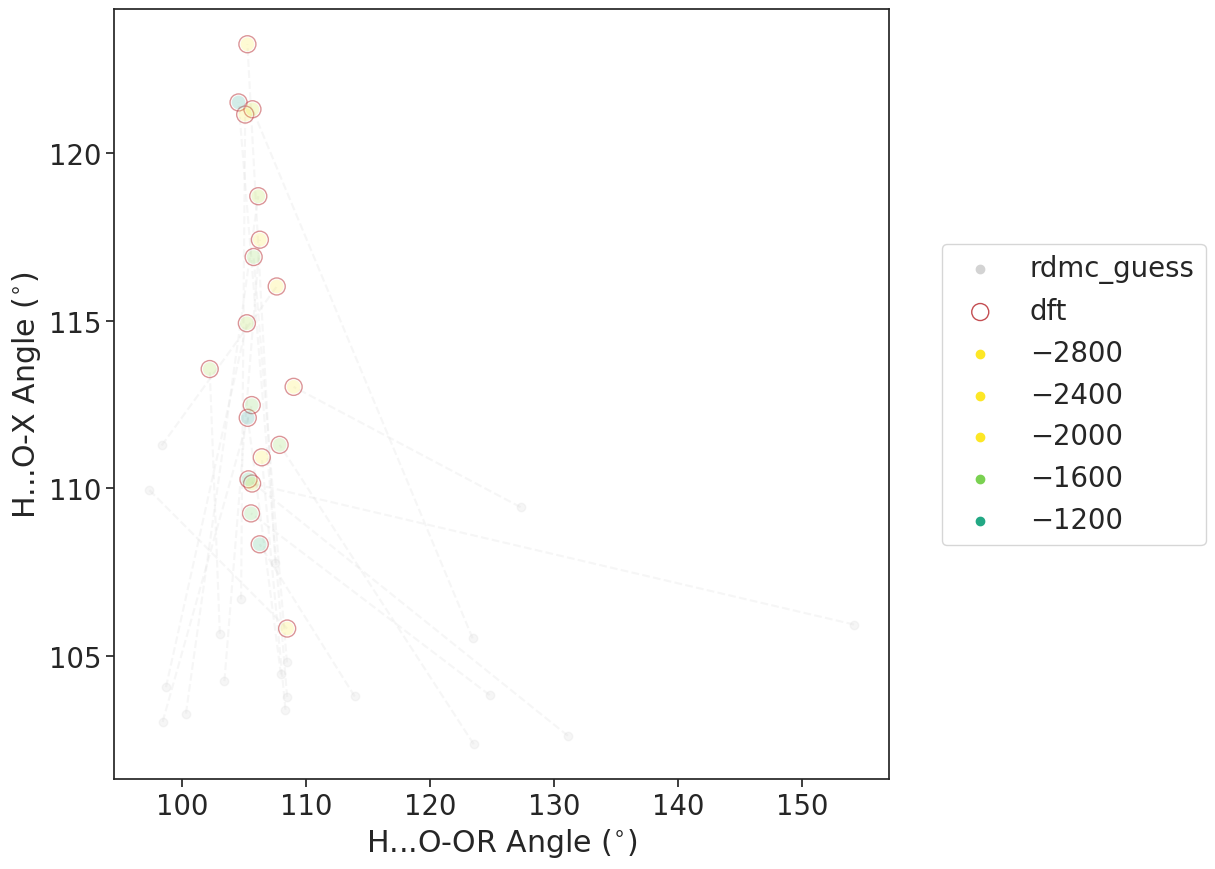

In [77]:
plt18, fig18, axes18 = draw_ts_angle_pair(df_bond, method1='rdmc_guess', method2='dft')

In [78]:
# fig18.savefig('oho_angle_pair_good_rdmc_dft.png', format='png', dpi=1200, bbox_inches='tight')

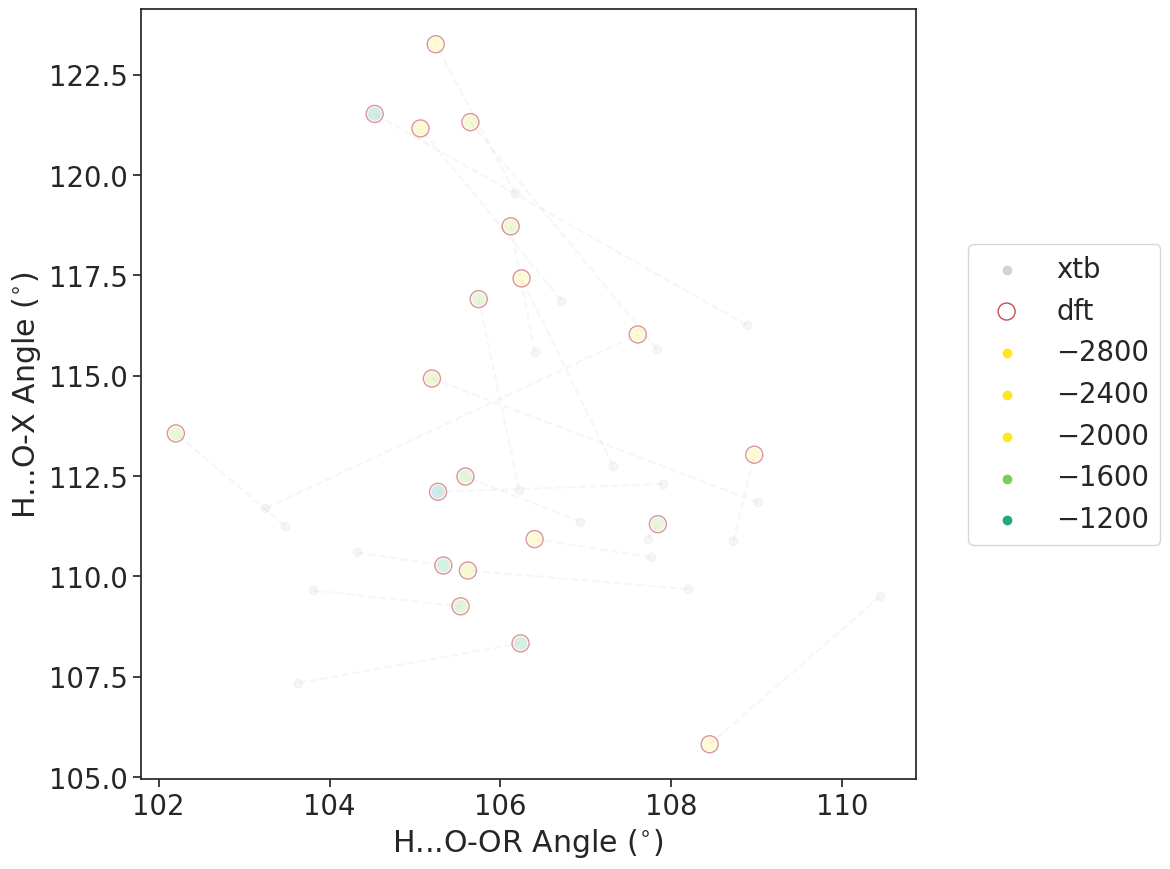

In [79]:
plt19, fig19, axes19 = draw_ts_angle_pair(df_bond, method1='xtb', method2='dft')

In [80]:
# fig19.savefig('oho_angle_pair_good_xtb_dft.png', format='png', dpi=1200, bbox_inches='tight')

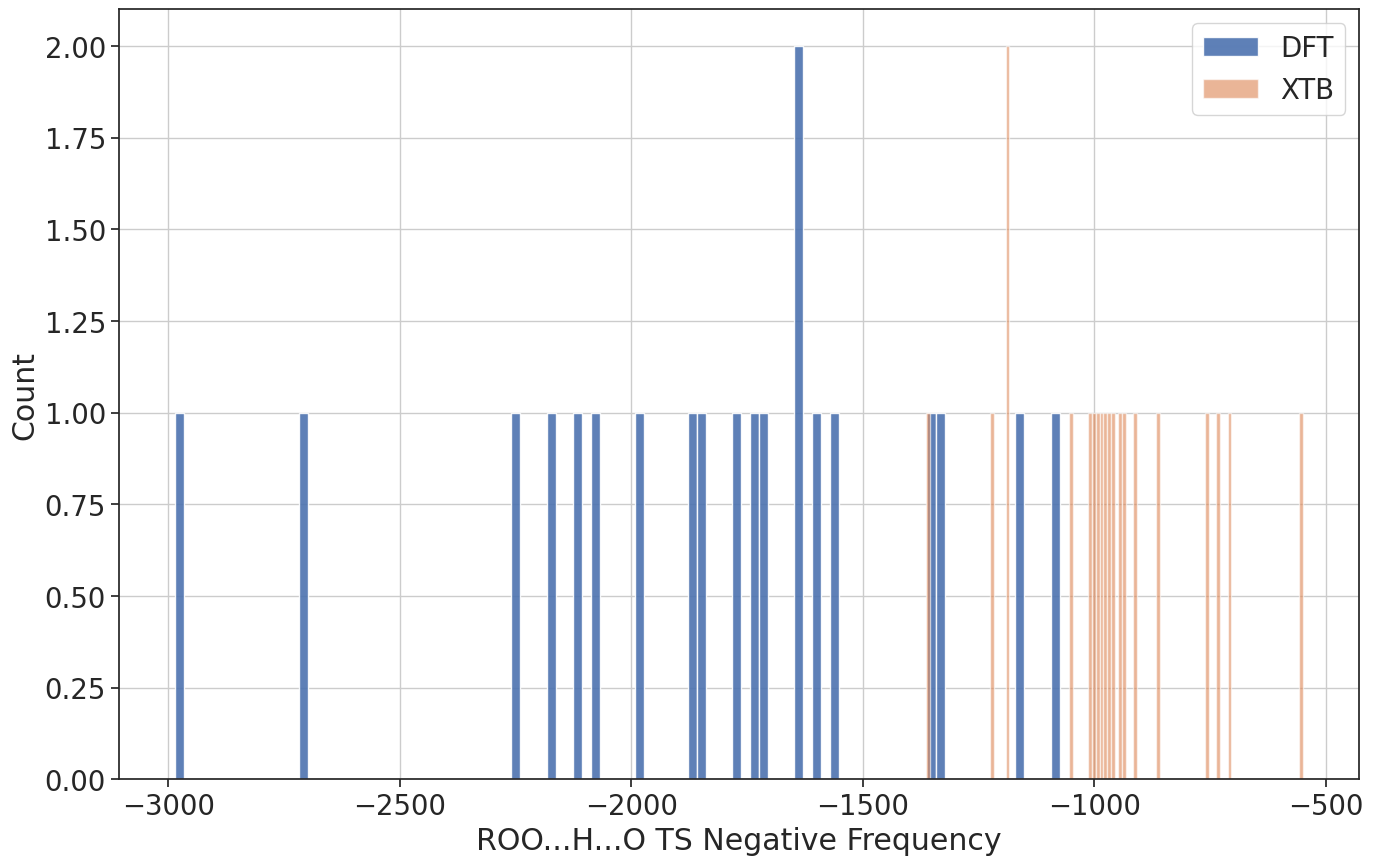

In [81]:
fig = plt.figure()
ax = df_bond['dft_freq_neg'].hist(bins=100, grid=True, alpha=0.9, label='DFT')
ax = df_bond['xtb_freq_neg'].hist(bins=100, grid=True, alpha=0.6, label='XTB')
ax.set_xlabel('ROO...H...O TS Negative Frequency')
ax.set_ylabel('Count')
ax.legend()
# fig.savefig('image/oho_dft_xtb_roo_hts_freq.png', format='png', dpi=1200, bbox_inches='tight')

In [82]:
df_bad = potential_bad[potential_bad['reaction_type'] == 'O...H...O']

In [83]:
df_bad

rxn_smi  \
6777adc5bb78fc34a9287d853886a2cc  [N:8]([c:9]1[n:10]([H:19])[c:11]([O:16][H:22])...   
bf378de4c0f7975788d04c0a3f6274ef  [C:8]([n:9]1[c:10]([O:14][H:21])[c:11]([O:15][...   
3398df2cf4b921b5c26f77348a9c77f2  [O:1]([C:4]([O:2][O:3])([H:5])[H:6])[H:7].[O:8...   

                                                                           dft_freq  \
6777adc5bb78fc34a9287d853886a2cc  [-748.593, 17.899, 30.0589, 80.5218, 120.9276,...   
bf378de4c0f7975788d04c0a3f6274ef  [-1352.8886, 27.0354, 44.5967, 68.6523, 78.647...   
3398df2cf4b921b5c26f77348a9c77f2  [-930.0254, 22.0992, 37.4587, 70.421, 117.9952...   

                                  dft_freq_neg  \
6777adc5bb78fc34a9287d853886a2cc     -748.5930   
bf378de4c0f7975788d04c0a3f6274ef    -1352.8886   
3398df2cf4b921b5c26f77348a9c77f2     -930.0254   

                                                                            dft_xyz  \
6777adc5bb78fc34a9287d853886a2cc  O  -0.5648200000  -1.6466190000   0.2370460000...   
bf378de4c0f7975788d04c0a3f6274ef  O   0.3584200000   1.0129250000  -1.6404370000...   
3398df2cf4b921b5c26f77348a9c77f2  O   1.8246950000   0.0393520000   0.6289690000...   

                                  dft_steps            dft_cpu  \
6777adc5bb78fc34a9287d853886a2cc         18    (1, 2, 1, 10.6)   
bf378de4c0f7975788d04c0a3f6274ef         11  (0, 15, 19, 20.0)   
3398df2cf4b921b5c26f77348a9c77f2          7   (0, 10, 1, 55.7)   

                                          dft_wall  \
6777adc5bb78fc34a9287d853886a2cc  (0, 0, 34, 15.6)   
bf378de4c0f7975788d04c0a3f6274ef  (0, 0, 40, 13.9)   
3398df2cf4b921b5c26f77348a9c77f2  (0, 0, 53, 45.0)   

                                                                         dft_energy  \
6777adc5bb78fc34a9287d853886a2cc  {'scf': -755.84543848, 'zpe_scale_factor': 0.9...   
bf378de4c0f7975788d04c0a3f6274ef  {'scf': -755.919145181, 'zpe_scale_factor': 0....   
3398df2cf4b921b5c26f77348a9c77f2  {'scf': -755.88260608, 'zpe_scale_factor': 0.9...   

                                                                           xtb_freq  \
6777adc5bb78fc34a9287d853886a2cc  [-733.8398, 18.7414, 25.4448, 79.8453, 92.217,...   
bf378de4c0f7975788d04c0a3f6274ef  [-1303.3686, 16.1876, 35.55, 59.5688, 67.838, ...   
3398df2cf4b921b5c26f77348a9c77f2  [-1245.968, 30.2397, 39.4674, 65.7178, 121.128...   

                                  xtb_freq_neg  ...  \
6777adc5bb78fc34a9287d853886a2cc     -733.8398  ...   
bf378de4c0f7975788d04c0a3f6274ef    -1303.3686  ...   
3398df2cf4b921b5c26f77348a9c77f2    -1245.9680  ...   

                                 rdmc_guess_a_R2X_R2E_TS_min  \
6777adc5bb78fc34a9287d853886a2cc                  106.885270   
bf378de4c0f7975788d04c0a3f6274ef                  103.597042   
3398df2cf4b921b5c26f77348a9c77f2                  104.985106   

                                  rdmc_guess_a_R2X_R2E_TS_max  \
6777adc5bb78fc34a9287d853886a2cc                   106.885270   
bf378de4c0f7975788d04c0a3f6274ef                   103.597042   
3398df2cf4b921b5c26f77348a9c77f2                   104.985106   

                                 rdmc_guess_d_R2X_R2E_TS_R1O  \
6777adc5bb78fc34a9287d853886a2cc                 -163.013358   
bf378de4c0f7975788d04c0a3f6274ef                  177.147303   
3398df2cf4b921b5c26f77348a9c77f2                  104.493120   

                                 rdmc_guess_d_R2E_TS_R1O_R1OO  \
6777adc5bb78fc34a9287d853886a2cc                    51.306643   
bf378de4c0f7975788d04c0a3f6274ef                   -71.753669   
3398df2cf4b921b5c26f77348a9c77f2                    -8.446256   

                                  rdmc_guess_d_TS_R1O_R1OO_R1X  \
6777adc5bb78fc34a9287d853886a2cc                    -10.687303   
bf378de4c0f7975788d04c0a3f6274ef                     99.720236   
3398df2cf4b921b5c26f77348a9c77f2                    -19.820461   

                                 rdmc_guess_d_R2X_R2E_R1O_R1OO  \
6777adc5bb78fc34a9287d853886a2cc                   -116.6528

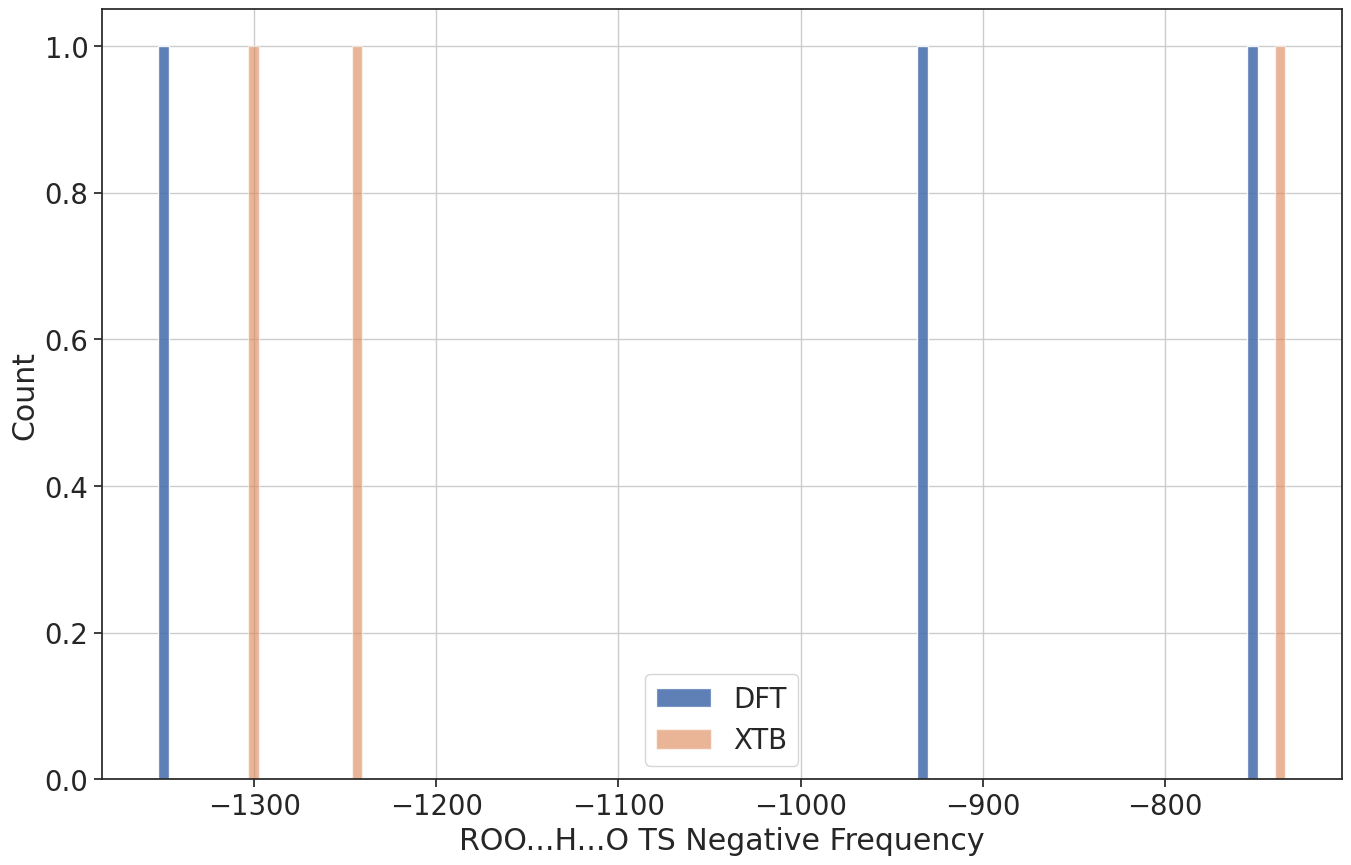

In [84]:
fig = plt.figure()
ax = df_bad['dft_freq_neg'].hist(bins=100, grid=True, alpha=0.9, label='DFT')
ax = df_bad['xtb_freq_neg'].hist(bins=100, grid=True, alpha=0.6, label='XTB')
ax.set_xlabel('ROO...H...O TS Negative Frequency')
ax.set_ylabel('Count')
ax.legend()
# fig.savefig('image/oho_dft_xtb_roo_hts_freq_bad.png', format='png', dpi=1200, bbox_inches='tight')

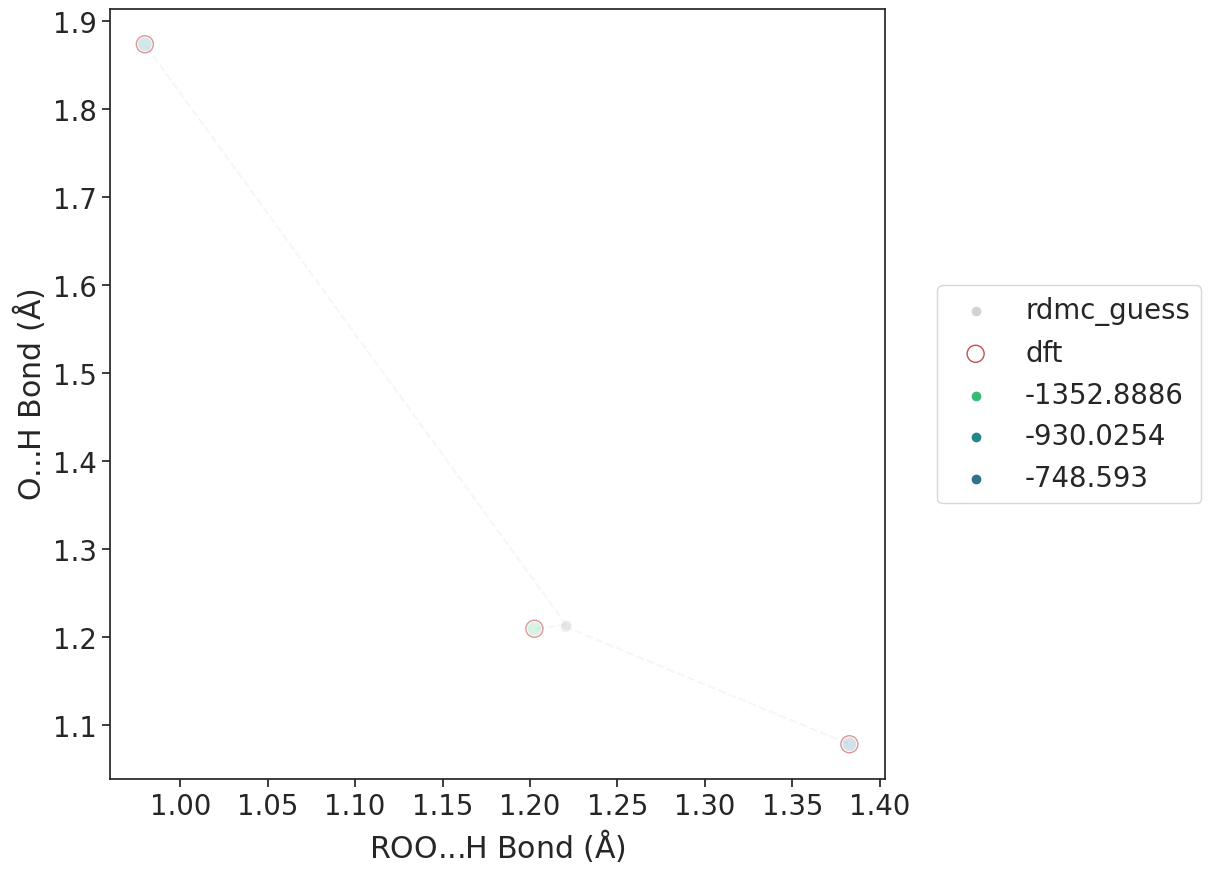

In [85]:
plt20, fig20, axes20 = draw_ts_bond_pair(df_bad, method1='rdmc_guess', method2='dft')

In [86]:
# fig20.savefig('oho_bond_pair_bad_rdmc_dft.png', format='png', dpi=1200, bbox_inches='tight')

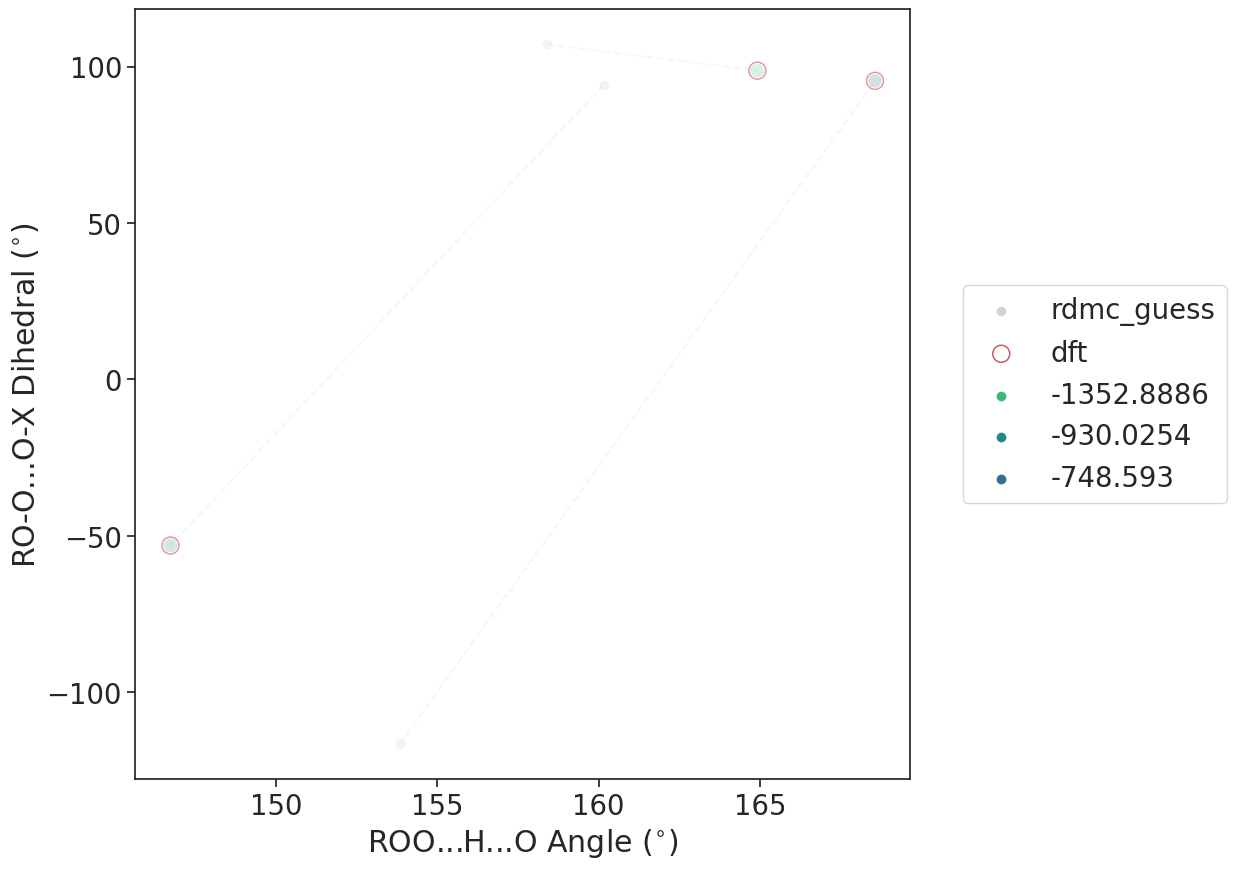

In [87]:
plt21, fig21, axes21 = draw_ts_angle_dihedral(df_bad, method1='rdmc_guess', method2='dft')

In [88]:
# fig21.savefig('oho_dihedral_bad_rdmc_dft.png', format='png', dpi=1200, bbox_inches='tight')

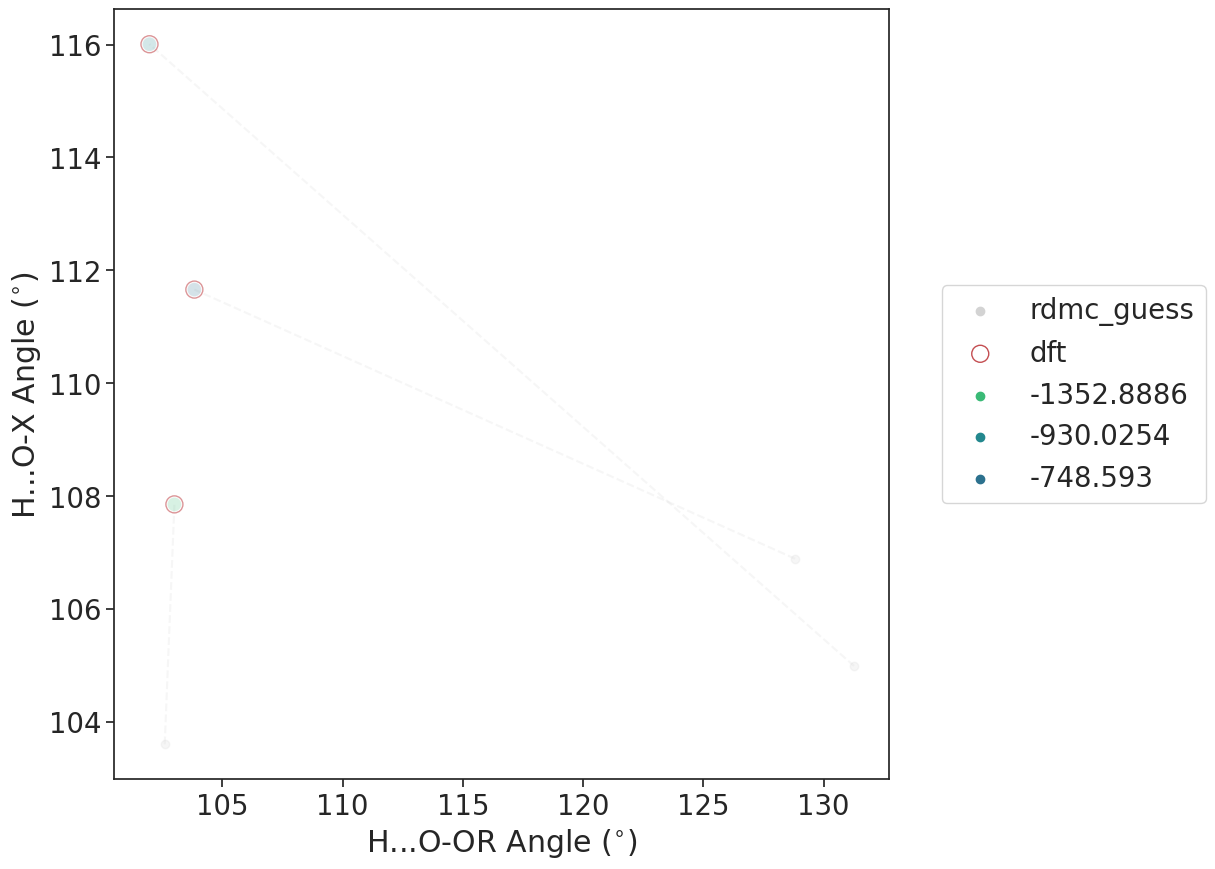

In [89]:
plt22, fig22, axes22 = draw_ts_angle_pair(df_bad, method1='rdmc_guess', method2='dft')

In [90]:
# fig22.savefig('oho_angle_bad_rdmc_dft.png', format='png', dpi=1200, bbox_inches='tight')

In [221]:
df_update['ts_check_status'] = ''

In [222]:
## note: .at method not working in new verison, use .loc instead 
df_update.loc[potential_good.index, 'ts_check_status'] = 'Good'
df_update.loc[low_poss_bad.index, 'ts_check_status'] = 'Possibly Good'
df_update.loc[high_poss_bad.index, 'ts_check_status'] = 'Bad'

In [117]:
potential_good['dft_freq_neg'].describe()

count     977.000000
mean    -1810.959816
std       169.149515
min     -2984.197500
25%     -1903.758400
50%     -1840.239700
75%     -1747.097200
max      -546.077700
Name: dft_freq_neg, dtype: float64

In [118]:
low_poss_bad['dft_freq_neg'].describe()

count       8.000000
mean    -1132.241362
std       310.670974
min     -1354.545700
25%     -1335.552850
50%     -1273.192200
75%     -1071.003750
max      -479.945800
Name: dft_freq_neg, dtype: float64

In [119]:
high_poss_bad['dft_freq_neg'].describe()

count      15.000000
mean     -823.128600
std       336.680494
min     -1352.888600
25%     -1067.549700
50%      -848.131600
75%      -554.004300
max      -321.142200
Name: dft_freq_neg, dtype: float64

In [120]:
potential_bad['dft_freq_neg'].describe()

count      23.000000
mean     -930.646083
std       354.265767
min     -1354.545700
25%     -1246.447100
50%      -930.025400
75%      -660.344400
max      -321.142200
Name: dft_freq_neg, dtype: float64

In [121]:
len(potential_good[potential_good['reaction_type'] == 'C...H...O'])

913

In [122]:
len(potential_bad[potential_bad['reaction_type'] == 'C...H...O'])

17

<AxesSubplot: xlabel='reaction_type', ylabel='dft_freq_neg'>

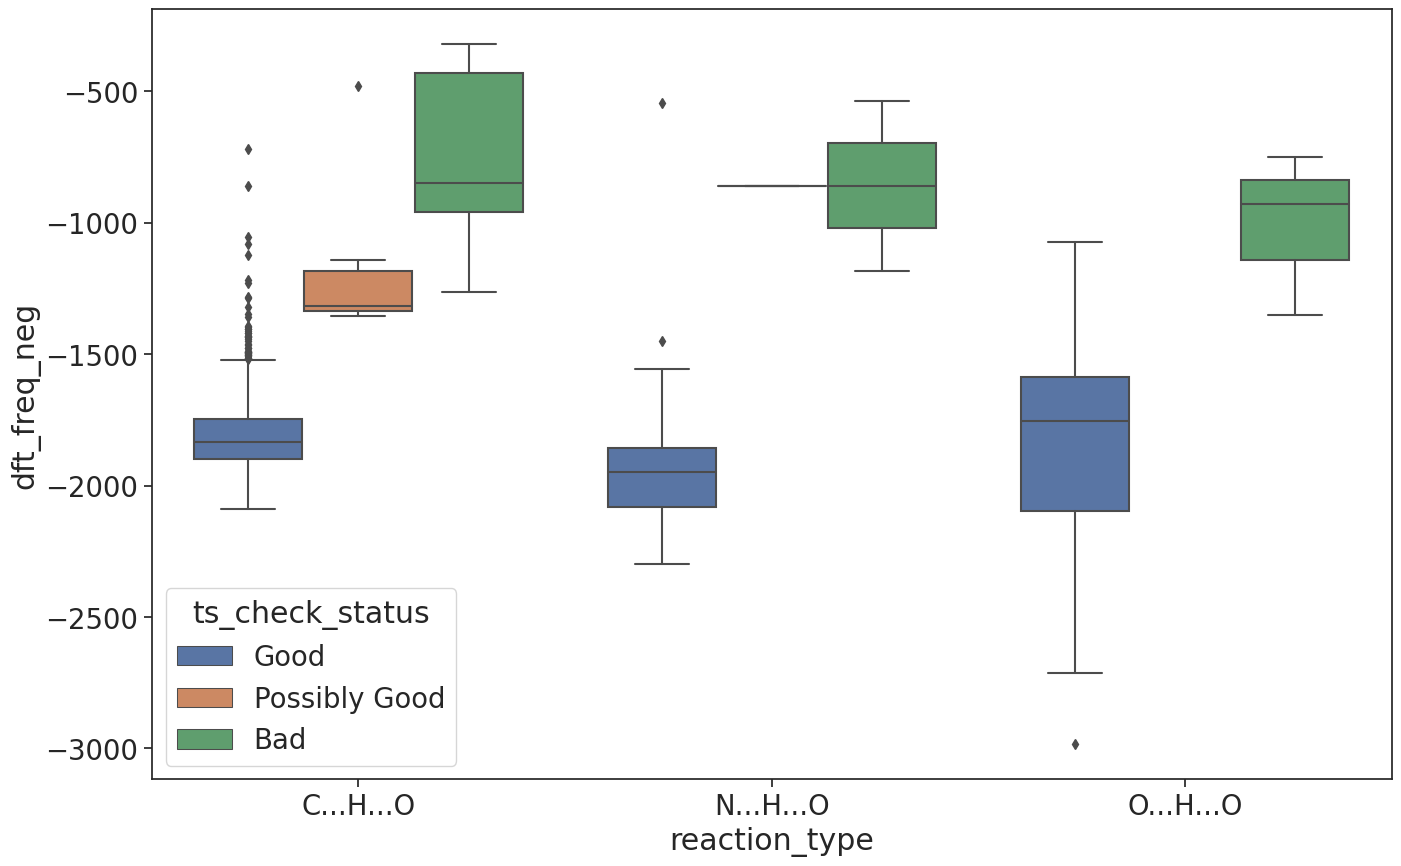

In [223]:
fig = plt.figure()
sns.boxplot(data=df_update, y='dft_freq_neg', x='reaction_type', hue='ts_check_status')
# fig.savefig('image/freq_dist.png', format='png', dpi=1200, bbox_inches='tight')

<AxesSubplot: xlabel='reaction_type', ylabel='test_factor'>

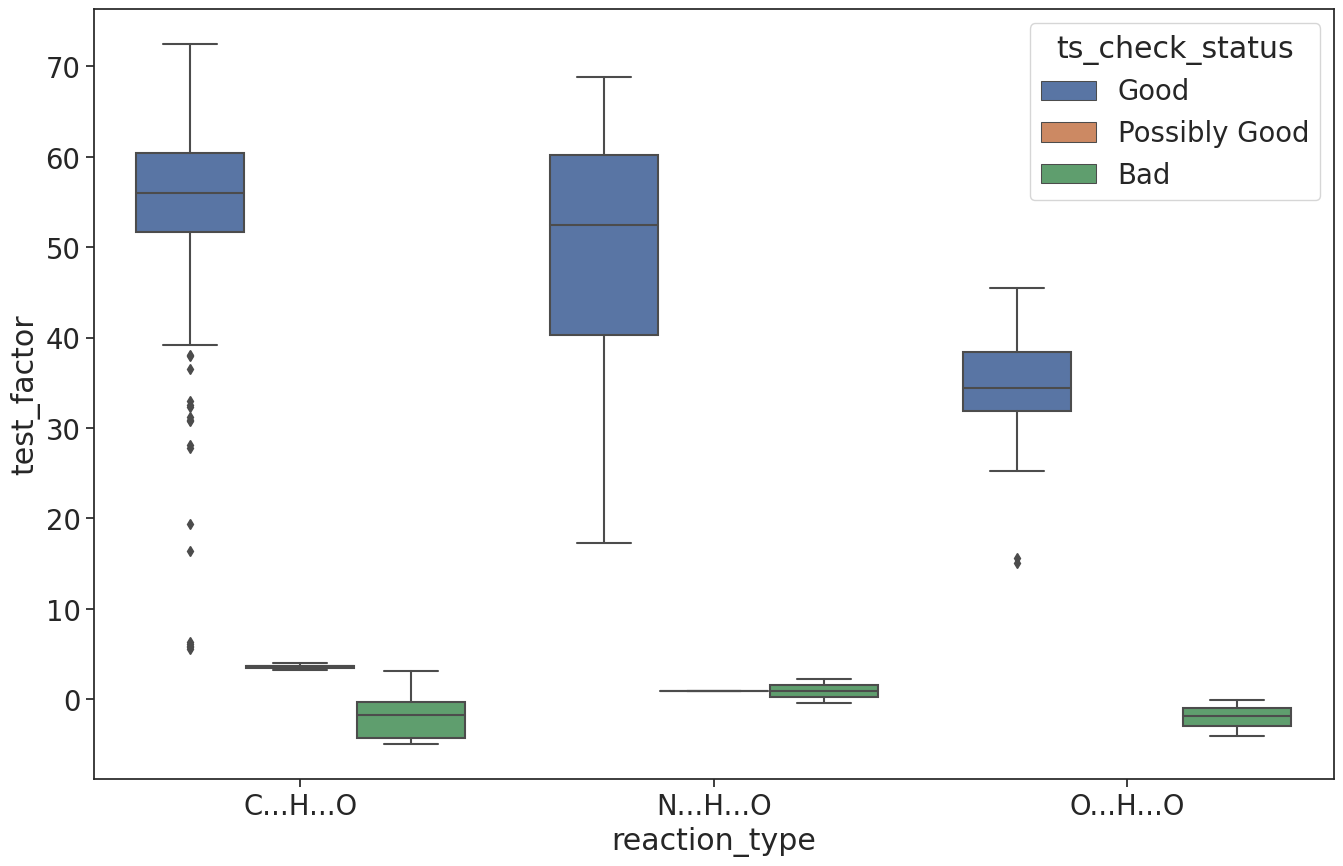

In [224]:
fig = plt.figure()
sns.boxplot(data=df_update, y='test_factor', x='reaction_type', hue='ts_check_status')
# fig.savefig('image/test_dist.png', format='png', dpi=1200, bbox_inches='tight')

In [125]:
potential_good['dft_a_TS_R1O_R1OO'].describe()

count    977.000000
mean     104.994486
std        1.565411
min       97.290533
25%      104.062286
50%      104.962599
75%      106.007604
max      110.584394
Name: dft_a_TS_R1O_R1OO, dtype: float64

In [150]:
from sklearn.metrics import mean_squared_error, r2_score

In [151]:
def calc_dihedral_min_diff(d1, d2):
    """
    Calculate the minimum distance between two dihedrals in degree units.
    """
    
    val_1 = abs(d1 - d2)
    val_2 = 360 - val_1
    
    return min(val_1, val_2)

def calc_dihedral_mse(y_true, y_pred,squared=True):
    diff = np.array([calc_dihedral_min_diff(x[0], x[1]) for x in zip(y_true, y_pred)])
    output_errors = np.average(diff ** 2, axis=0)
    
    if not squared:
        output_errors = np.sqrt(output_errors)
        
    return np.average(output_errors, weights=None)

In [152]:
val_dft = potential_good['dft_a_TS_R1O_R1OO'].values
val_xtb = potential_good['xtb_a_TS_R1O_R1OO'].values
val_rdmc = potential_good['rdmc_guess_a_TS_R1O_R1OO'].values
val_am1 = potential_good['am1_a_TS_R1O_R1OO'].values
val_pm7 = potential_good['pm7_a_TS_R1O_R1OO'].values

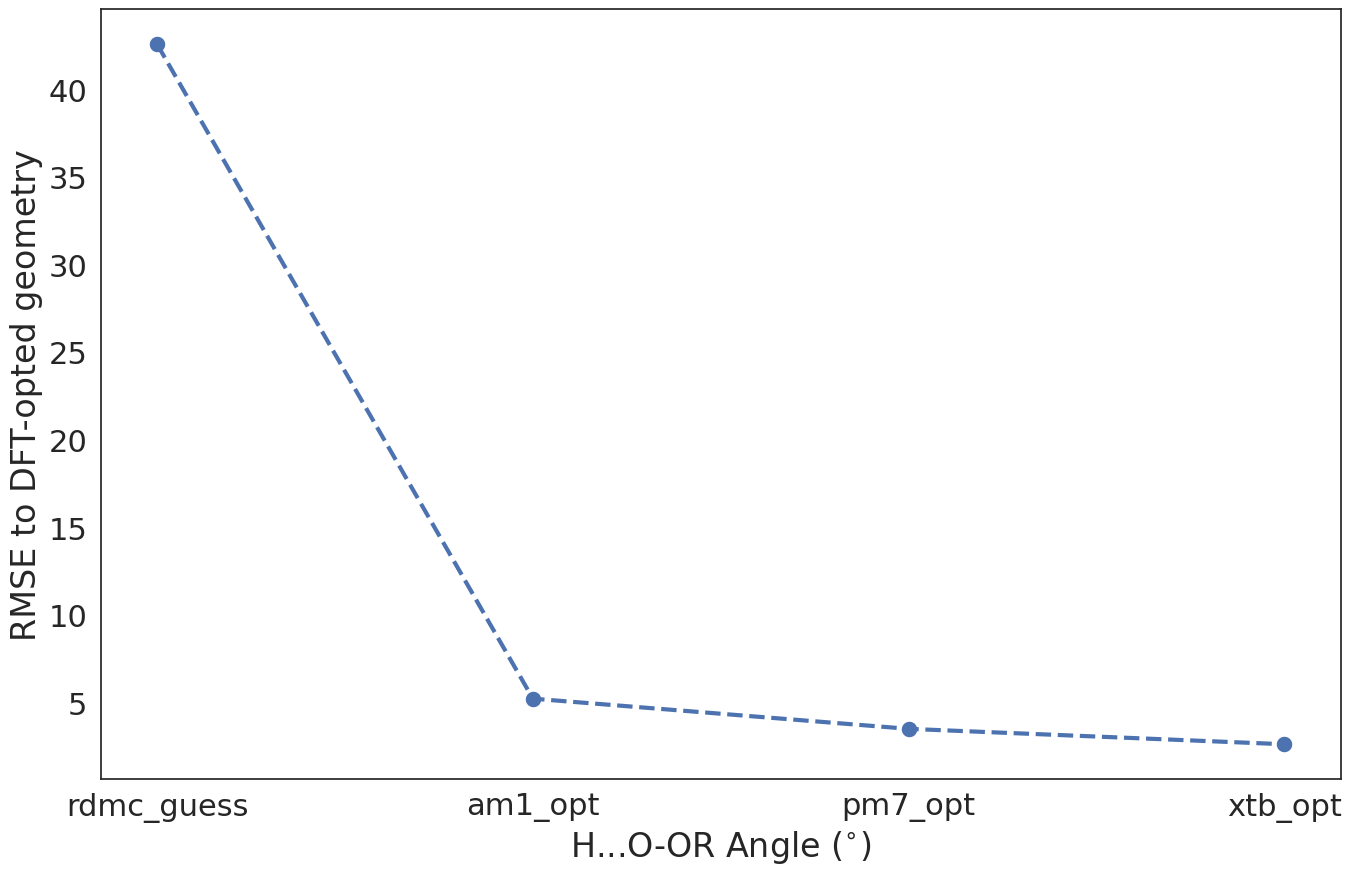

In [153]:
fig = plt.figure()
sns.set_theme(style='white')
sns.set_context("notebook", font_scale=2)
x = ['rdmc_guess', 'am1_opt', 'pm7_opt', 'xtb_opt']
y = [mean_squared_error(val_rdmc, val_dft, squared=False), 
     mean_squared_error(val_am1, val_dft, squared=False), 
     mean_squared_error(val_pm7, val_dft, squared=False),
     mean_squared_error(val_xtb, val_dft, squared=False),
    ]
ax = sns.lineplot(x=x, y=y, linewidth = 3)
ax.lines[0].set_linestyle("--")
sns.scatterplot(x=x, y=y, linewidth = 3, s=200)
ax.set(xlabel=f'H...O-OR' + ' Angle ($^{\circ}$)',
                ylabel='RMSE to DFT-opted geometry')
plt.show()
fig.savefig('image/hoor_opt_score.png', format='png', dpi=1200, bbox_inches='tight')

In [154]:
val_dft = potential_good['dft_d_R2X_R2E_R1O_R1OO'].values
val_xtb = potential_good['xtb_d_R2X_R2E_R1O_R1OO'].values
val_rdmc = potential_good['rdmc_guess_d_R2X_R2E_R1O_R1OO'].values
val_am1 = potential_good['am1_d_R2X_R2E_R1O_R1OO'].values
val_pm7 = potential_good['pm7_d_R2X_R2E_R1O_R1OO'].values

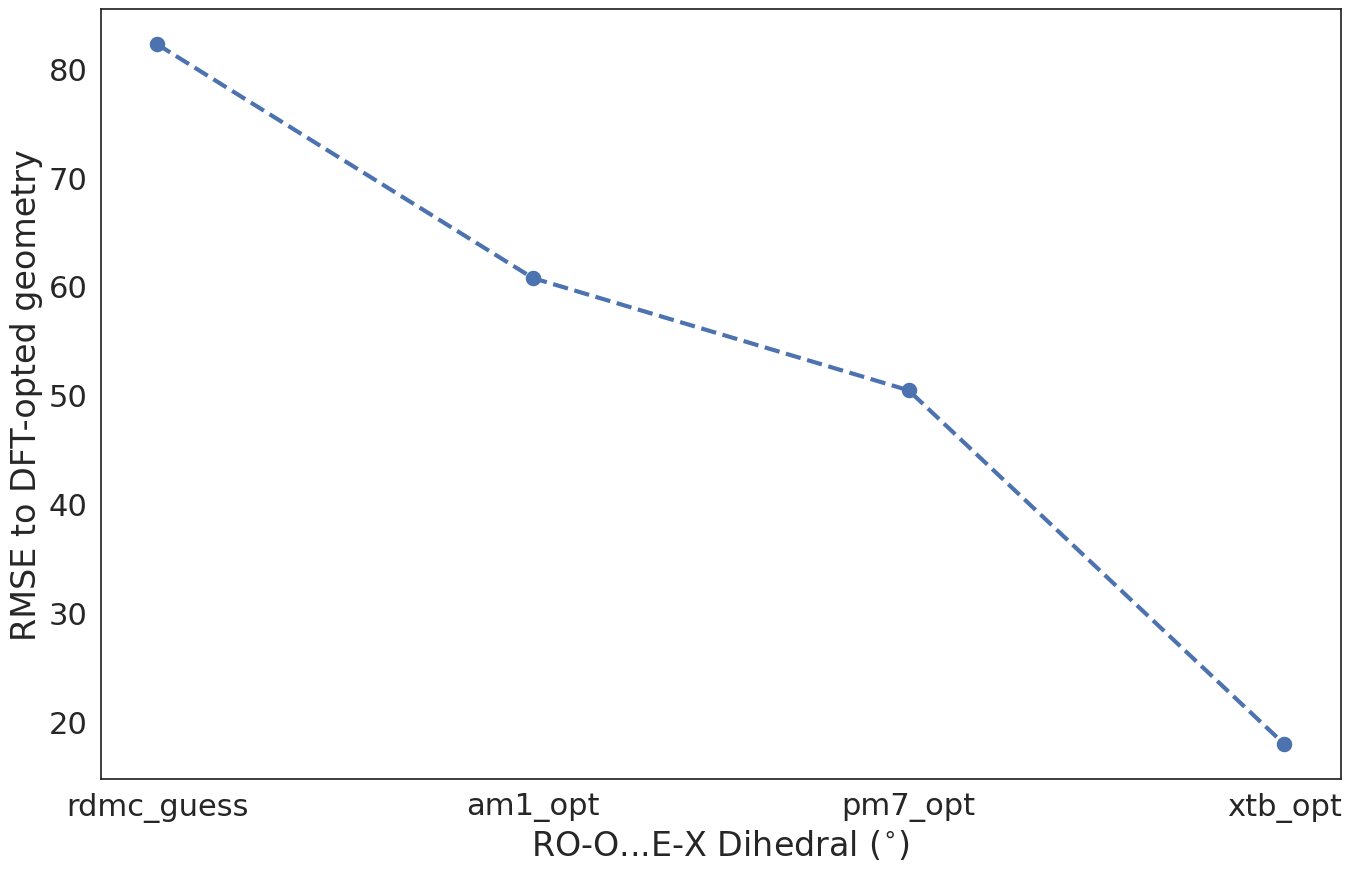

In [155]:
fig = plt.figure()
sns.set_theme(style='white')
sns.set_context("notebook", font_scale=2)
x = ['rdmc_guess', 'am1_opt', 'pm7_opt', 'xtb_opt']
y = [calc_dihedral_mse(val_rdmc, val_dft, squared=False), 
     calc_dihedral_mse(val_am1, val_dft, squared=False), 
     calc_dihedral_mse(val_pm7, val_dft, squared=False),
     calc_dihedral_mse(val_xtb, val_dft, squared=False),
    ]
ax = sns.lineplot(x=x, y=y, linewidth = 3)
ax.lines[0].set_linestyle("--")
sns.scatterplot(x=x, y=y, linewidth = 3, s=200)
ax.set(xlabel=f'RO-O...E-X' + ' Dihedral ($^{\circ}$)',
                ylabel='RMSE to DFT-opted geometry')
plt.show()
# fig.savefig('image/dihedral_opt_score.png', format='png', dpi=1200, bbox_inches='tight')

Text(0, 0.5, 'XTB')

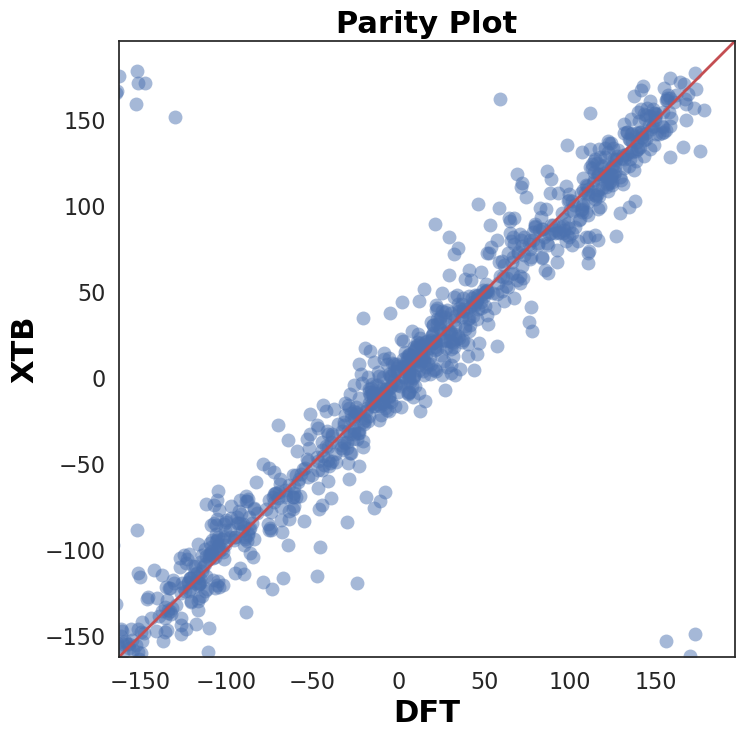

In [156]:
# Font for figure for publishing
font_axis_publish = {
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16

# Plot Figures
fignow = plt.figure(figsize=(8,8))

# x = abs(val_dft)
# y = abs(val_xtb)

x = val_dft
y = val_xtb

## find the boundaries of X and Y values
bounds = (min(x.min(), y.min()) - int(0.1 * y.min()), max(x.max(), y.max())+ int(0.1 * y.max()))

# Reset the limits
ax = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

plt.plot(x,y,"o", alpha=0.5 ,ms=10, markeredgewidth=0.0)

ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)

# Calculate Statistics of the Parity Plot 
mean_abs_err = np.mean(np.abs(x-y))
rmse = np.sqrt(np.mean((x-y)**2))
rmse_std = rmse / np.std(y)
z = np.polyfit(x,y, 1)
y_hat = np.poly1d(z)(x)

text = f"$\: \: Mean \: Absolute \: Error \: (MAE) = {mean_abs_err:0.3f}$ \n $ Root \: Mean \: Square \: Error \: (RMSE) = {rmse:0.3f}$ \n $ RMSE \: / \: Std(y) = {rmse_std :0.3f}$ \n $R^2 = {r2_score(y,y_hat):0.3f}$"

# plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
#      fontsize=14, verticalalignment='top')

# Title and labels 
plt.title("Parity Plot", fontdict=font_axis_publish)
plt.xlabel('DFT', fontdict=font_axis_publish)
plt.ylabel('XTB', fontdict=font_axis_publish)

# Save the figure into 300 dpi
# fignow.savefig("image/dft_xtb_parity_dihedral.png",format = "png",dpi=1200,bbox_inches='tight')

Text(0, 0.5, 'AM1')

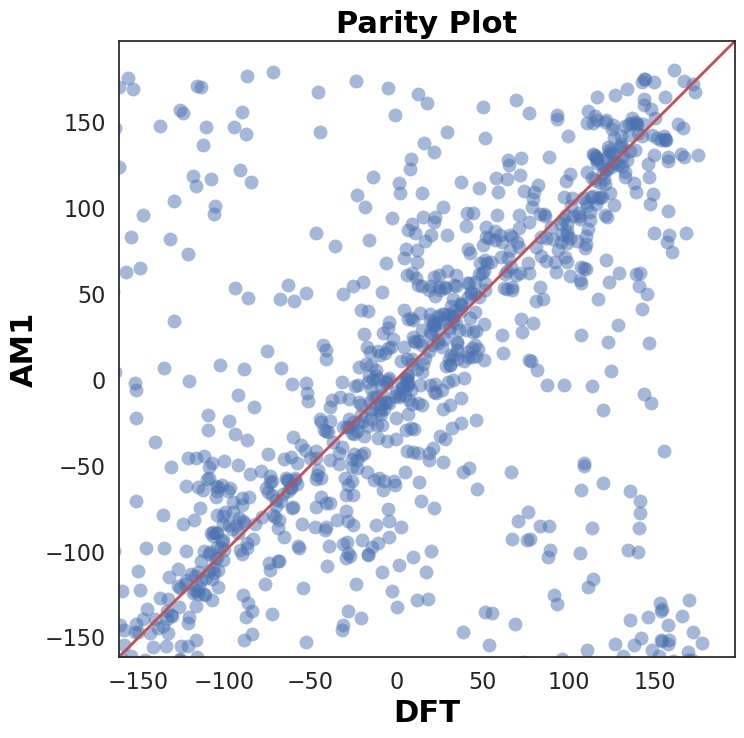

In [158]:
# Font for figure for publishing
font_axis_publish = {
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16

# Plot Figures
fignow = plt.figure(figsize=(8,8))

# x = abs(val_dft)
# y = abs(val_xtb)

x = val_dft
y = val_am1

## find the boundaries of X and Y values
bounds = (min(x.min(), y.min()) - int(0.1 * y.min()), max(x.max(), y.max())+ int(0.1 * y.max()))

# Reset the limits
ax = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

plt.plot(x,y,"o", alpha=0.5 ,ms=10, markeredgewidth=0.0)

ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)

# Calculate Statistics of the Parity Plot 
mean_abs_err = np.mean(np.abs(x-y))
rmse = np.sqrt(np.mean((x-y)**2))
rmse_std = rmse / np.std(y)
z = np.polyfit(x,y, 1)
y_hat = np.poly1d(z)(x)

text = f"$\: \: Mean \: Absolute \: Error \: (MAE) = {mean_abs_err:0.3f}$ \n $ Root \: Mean \: Square \: Error \: (RMSE) = {rmse:0.3f}$ \n $ RMSE \: / \: Std(y) = {rmse_std :0.3f}$ \n $R^2 = {r2_score(y,y_hat):0.3f}$"

# plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
#      fontsize=14, verticalalignment='top')

# Title and labels 
plt.title("Parity Plot", fontdict=font_axis_publish)
plt.xlabel('DFT', fontdict=font_axis_publish)
plt.ylabel('AM1', fontdict=font_axis_publish)

# Save the figure into 300 dpi
# fignow.savefig("image/dft_am1_parity_dihedral.png",format = "png",dpi=1200,bbox_inches='tight')

Text(0, 0.5, 'PM7')

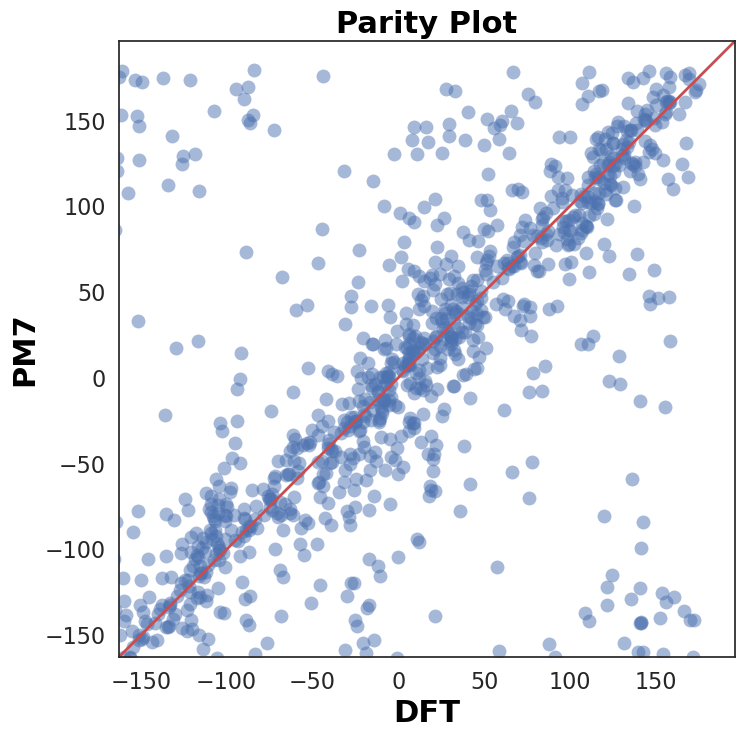

In [159]:
# Font for figure for publishing
font_axis_publish = {
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16

# Plot Figures
fignow = plt.figure(figsize=(8,8))

# x = abs(val_dft)
# y = abs(val_xtb)

x = val_dft
y = val_pm7

## find the boundaries of X and Y values
bounds = (min(x.min(), y.min()) - int(0.1 * y.min()), max(x.max(), y.max())+ int(0.1 * y.max()))

# Reset the limits
ax = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

plt.plot(x,y,"o", alpha=0.5 ,ms=10, markeredgewidth=0.0)

ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)

# Calculate Statistics of the Parity Plot 
mean_abs_err = np.mean(np.abs(x-y))
rmse = np.sqrt(np.mean((x-y)**2))
rmse_std = rmse / np.std(y)
z = np.polyfit(x,y, 1)
y_hat = np.poly1d(z)(x)

text = f"$\: \: Mean \: Absolute \: Error \: (MAE) = {mean_abs_err:0.3f}$ \n $ Root \: Mean \: Square \: Error \: (RMSE) = {rmse:0.3f}$ \n $ RMSE \: / \: Std(y) = {rmse_std :0.3f}$ \n $R^2 = {r2_score(y,y_hat):0.3f}$"

# plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
#      fontsize=14, verticalalignment='top')

# Title and labels 
plt.title("Parity Plot", fontdict=font_axis_publish)
plt.xlabel('DFT', fontdict=font_axis_publish)
plt.ylabel('PM7', fontdict=font_axis_publish)

# Save the figure into 300 dpi
# fignow.savefig("image/dft_pm7_parity_dihedral.png",format = "png",dpi=1200,bbox_inches='tight')

Text(0, 0.5, 'RDMC Guess')

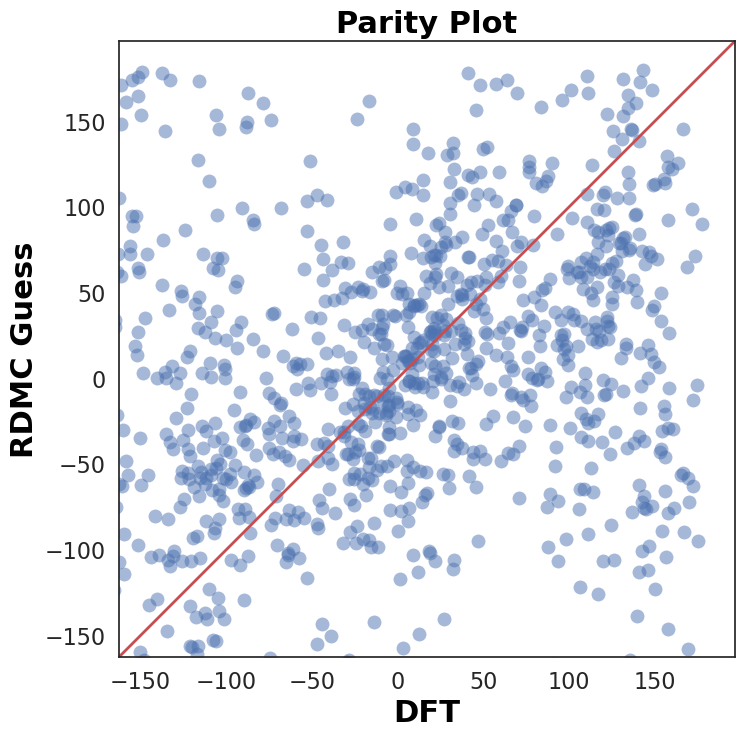

In [160]:
# Font for figure for publishing
font_axis_publish = {
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16

# Plot Figures
fignow = plt.figure(figsize=(8,8))

# x = abs(val_dft)
# y = abs(val_xtb)

x = val_dft
y = val_rdmc

## find the boundaries of X and Y values
bounds = (min(x.min(), y.min()) - int(0.1 * y.min()), max(x.max(), y.max())+ int(0.1 * y.max()))

# Reset the limits
ax = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

plt.plot(x,y,"o", alpha=0.5 ,ms=10, markeredgewidth=0.0)

ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)

# Calculate Statistics of the Parity Plot 
mean_abs_err = np.mean(np.abs(x-y))
rmse = np.sqrt(np.mean((x-y)**2))
rmse_std = rmse / np.std(y)
z = np.polyfit(x,y, 1)
y_hat = np.poly1d(z)(x)

text = f"$\: \: Mean \: Absolute \: Error \: (MAE) = {mean_abs_err:0.3f}$ \n $ Root \: Mean \: Square \: Error \: (RMSE) = {rmse:0.3f}$ \n $ RMSE \: / \: Std(y) = {rmse_std :0.3f}$ \n $R^2 = {r2_score(y,y_hat):0.3f}$"

# plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
#      fontsize=14, verticalalignment='top')

# Title and labels 
plt.title("Parity Plot", fontdict=font_axis_publish)
plt.xlabel('DFT', fontdict=font_axis_publish)
plt.ylabel('RDMC Guess', fontdict=font_axis_publish)

# Save the figure into 300 dpi
# fignow.savefig("image/dft_rdmc_parity_dihedral.png",format = "png",dpi=1200,bbox_inches='tight')

In [161]:
val_dft = potential_good['dft_a_R2E_TS_R1O'].values
val_xtb = potential_good['xtb_a_R2E_TS_R1O'].values
val_rdmc = potential_good['rdmc_guess_a_R2E_TS_R1O'].values
val_am1 = potential_good['am1_a_R2E_TS_R1O'].values
val_pm7 = potential_good['pm7_a_R2E_TS_R1O'].values

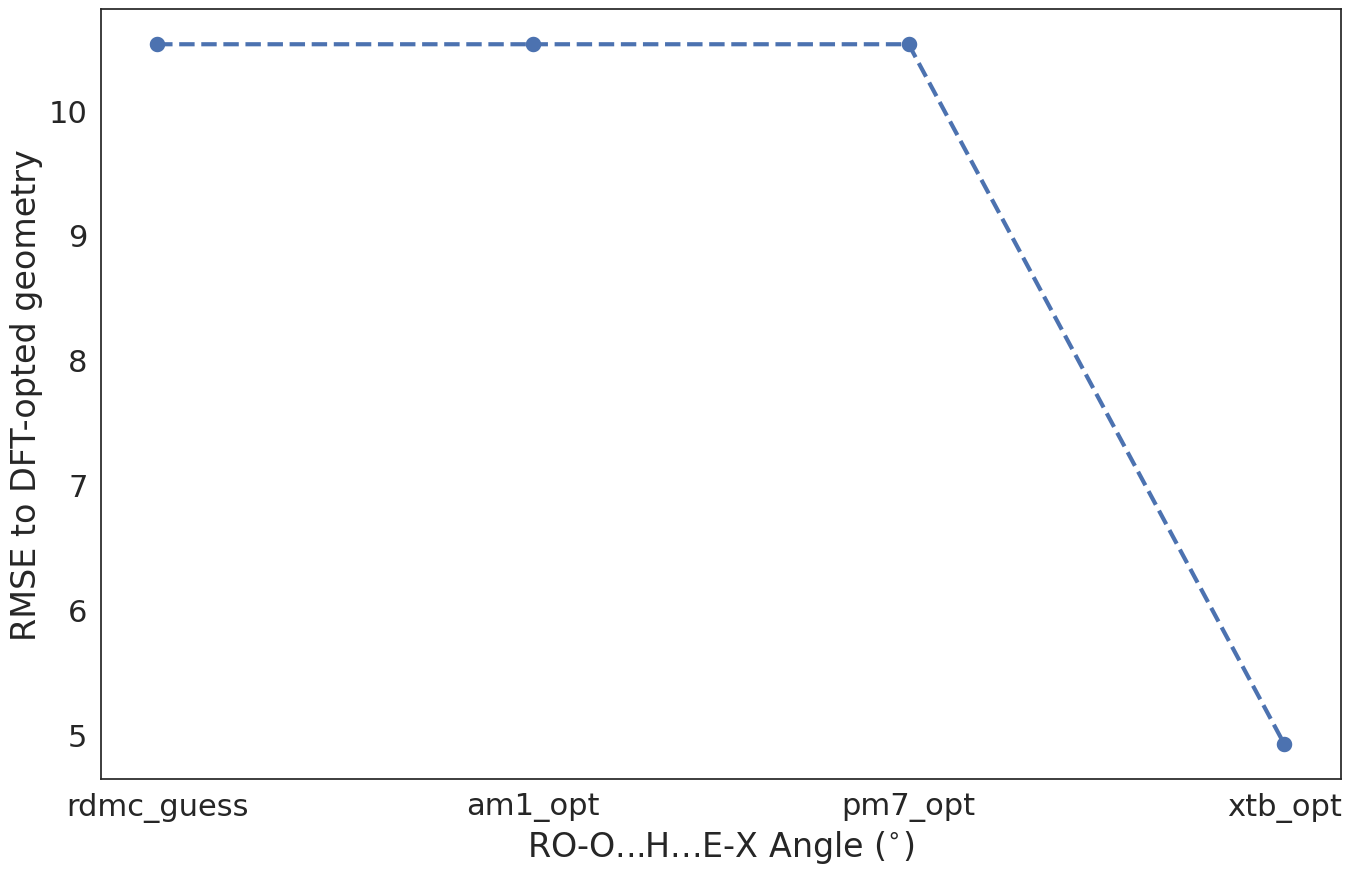

In [162]:
sns.set_theme(style='white')
sns.set_context("notebook", font_scale=2)
x = ['rdmc_guess', 'am1_opt', 'pm7_opt', 'xtb_opt']
y = [mean_squared_error(val_rdmc, val_dft, squared=False), 
     mean_squared_error(val_am1, val_dft, squared=False), 
     mean_squared_error(val_pm7, val_dft, squared=False),
     mean_squared_error(val_xtb, val_dft, squared=False),
    ]
ax = sns.lineplot(x=x, y=y, linewidth = 3)
ax.lines[0].set_linestyle("--")
sns.scatterplot(x=x, y=y, linewidth = 3, s=200)
ax.set(xlabel=f'RO-O...H...E-X' + ' Angle ($^{\circ}$)',
                ylabel='RMSE to DFT-opted geometry')
plt.show()

In [163]:
val_dft = potential_good['dft_r_R2X_R1X'].values
val_xtb = potential_good['xtb_r_R2X_R1X'].values
val_rdmc = potential_good['rdmc_guess_r_R2X_R1X'].values
val_am1 = potential_good['am1_r_R2X_R1X'].values
val_pm7 = potential_good['pm7_r_R2X_R1X'].values

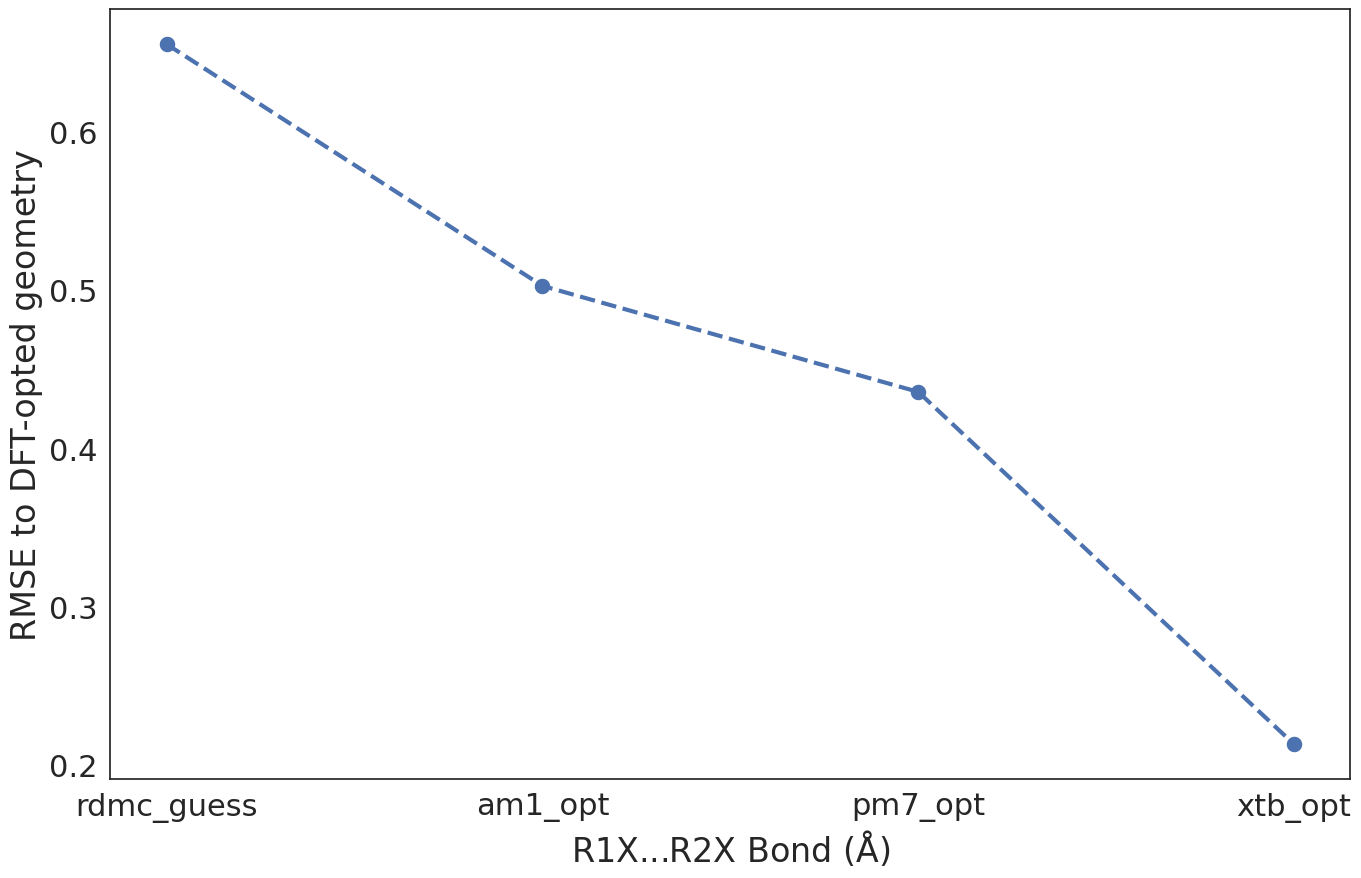

In [164]:
fig = plt.figure()
sns.set_theme(style='white')
sns.set_context("notebook", font_scale=2)
x = ['rdmc_guess', 'am1_opt', 'pm7_opt', 'xtb_opt']
y = [mean_squared_error(val_rdmc, val_dft, squared=False), 
     mean_squared_error(val_am1, val_dft, squared=False), 
     mean_squared_error(val_pm7, val_dft, squared=False),
     mean_squared_error(val_xtb, val_dft, squared=False),
    ]
ax = sns.lineplot(x=x, y=y, linewidth = 3)
ax.lines[0].set_linestyle("--")
sns.scatterplot(x=x, y=y, linewidth = 3, s=200)
ax.set(xlabel=f'R1X...R2X' + ' Bond ($\mathrm{\AA}$)',
                ylabel='RMSE to DFT-opted geometry')
plt.show()
# fig.savefig("image/r1x_r2x_dist_score_opt.png",format = "png",dpi=1200,bbox_inches='tight')

In [165]:
set(list(potential_good['r2_end_bulky_atom_symbol'].values))

{'C', 'N', 'O'}

In [166]:
dist_short_dft = potential_good['dft_r_R2E_R1O'].values
dist_long_dft = potential_good['dft_r_R2X_R1X'].values

In [167]:
dist_ratio_dft = dist_long_dft/dist_short_dft

Text(0, 0.5, 'count')

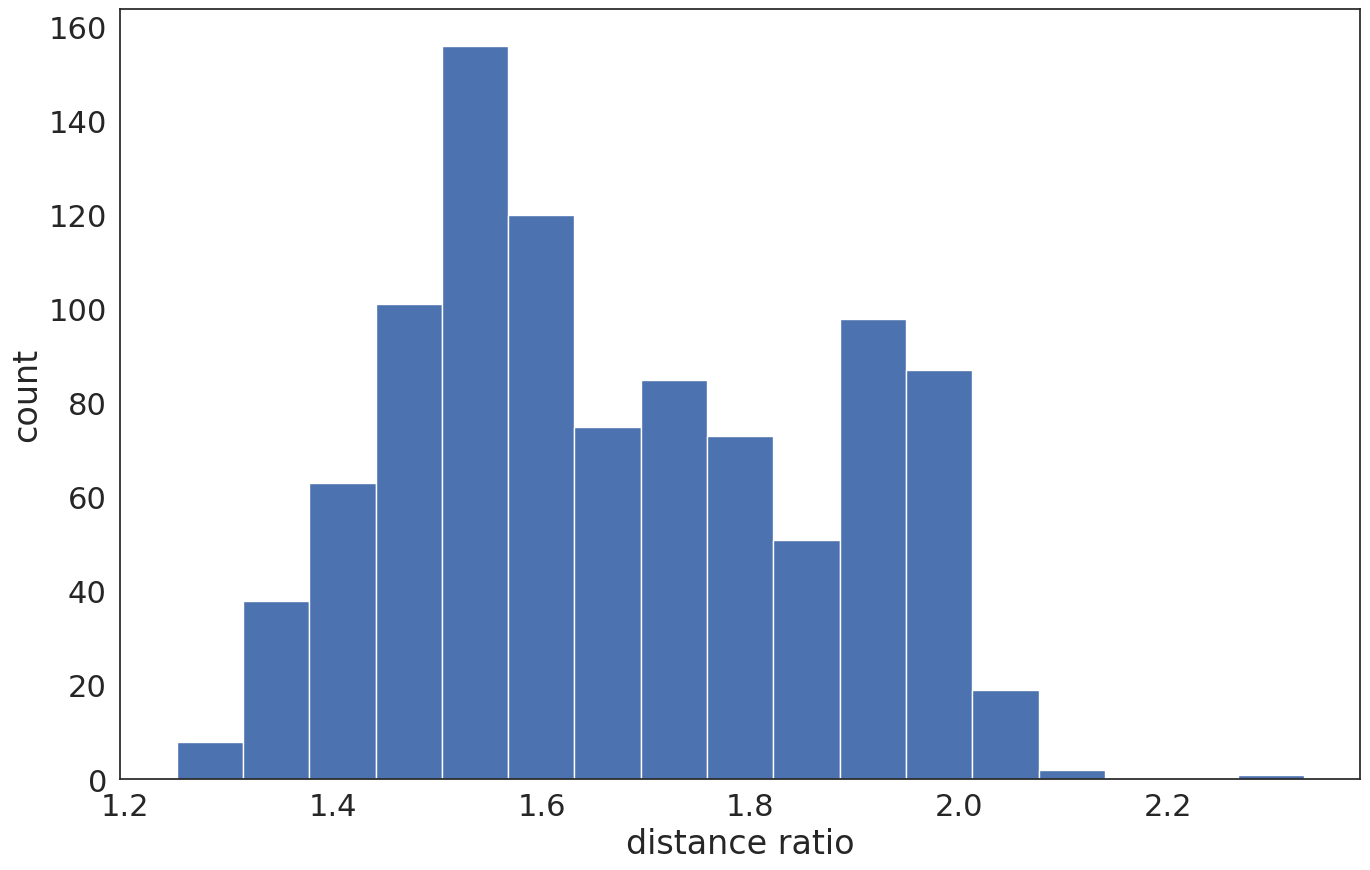

In [168]:
fig = plt.figure()
plt.hist(dist_ratio_dft, bins='auto')
ax = plt.gca()
ax.set_xlabel('distance ratio')
ax.set_ylabel('count')
# fig.savefig("image/dist_ratio_dft.png",format = "png",dpi=1200,bbox_inches='tight')

In [169]:
dist_short_xtb = potential_good['xtb_r_R2E_R1O'].values
dist_long_xtb = potential_good['xtb_r_R2X_R1X'].values
dist_ratio_xtb = dist_long_xtb/dist_short_xtb

Text(0, 0.5, 'count')

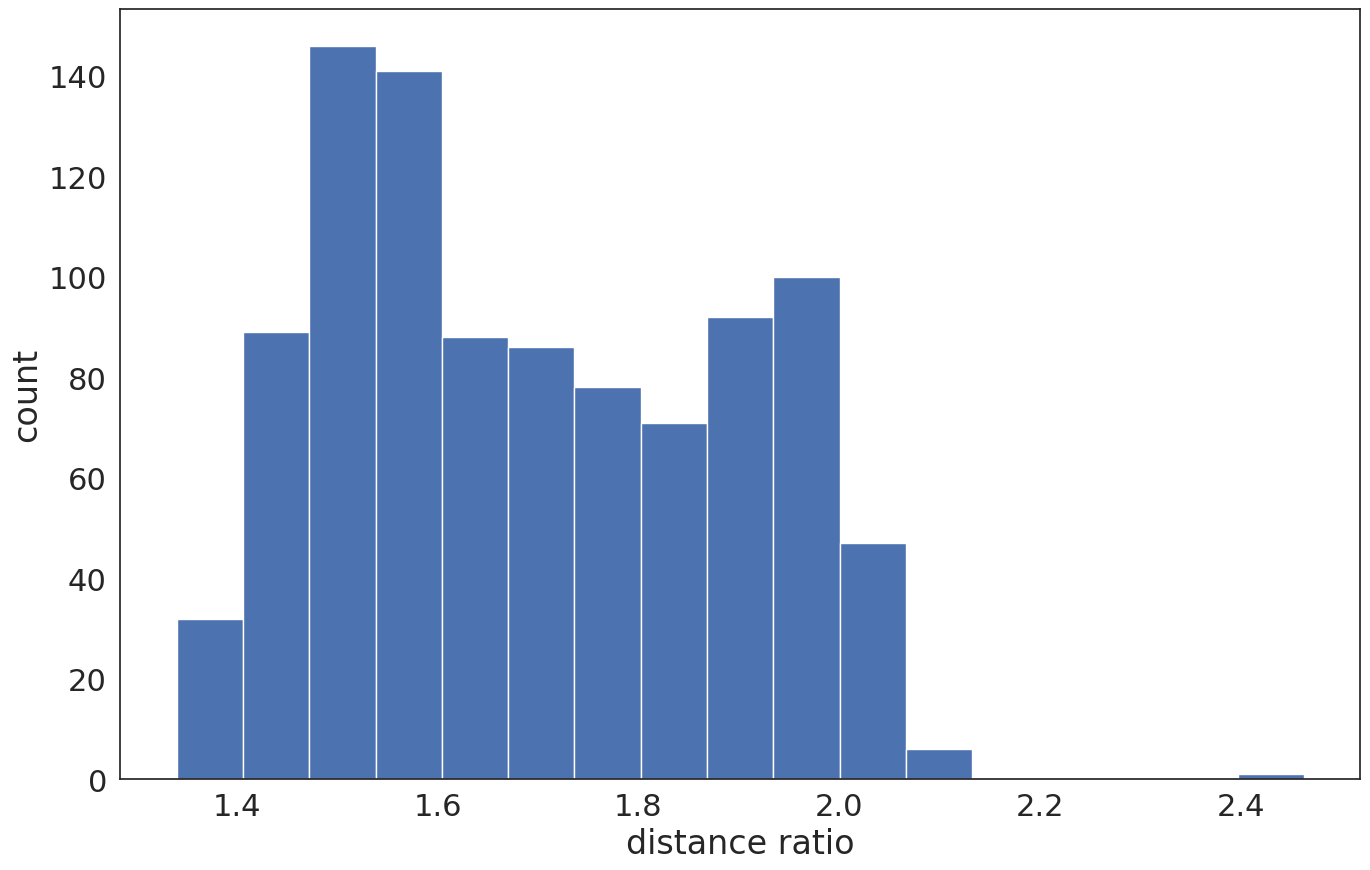

In [170]:
fig = plt.figure()
plt.hist(dist_ratio_xtb, bins='auto')
ax = plt.gca()
ax.set_xlabel('distance ratio')
ax.set_ylabel('count')
# fig.savefig("image/xtb_ratio_dft.png",format = "png",dpi=1200,bbox_inches='tight')

In [171]:
dist_short_rdmc = potential_good['rdmc_guess_r_R2E_R1O'].values
dist_long_rdmc = potential_good['rdmc_guess_r_R2X_R1X'].values
dist_ratio_rdmc = dist_long_rdmc/dist_short_rdmc

Text(0, 0.5, 'count')

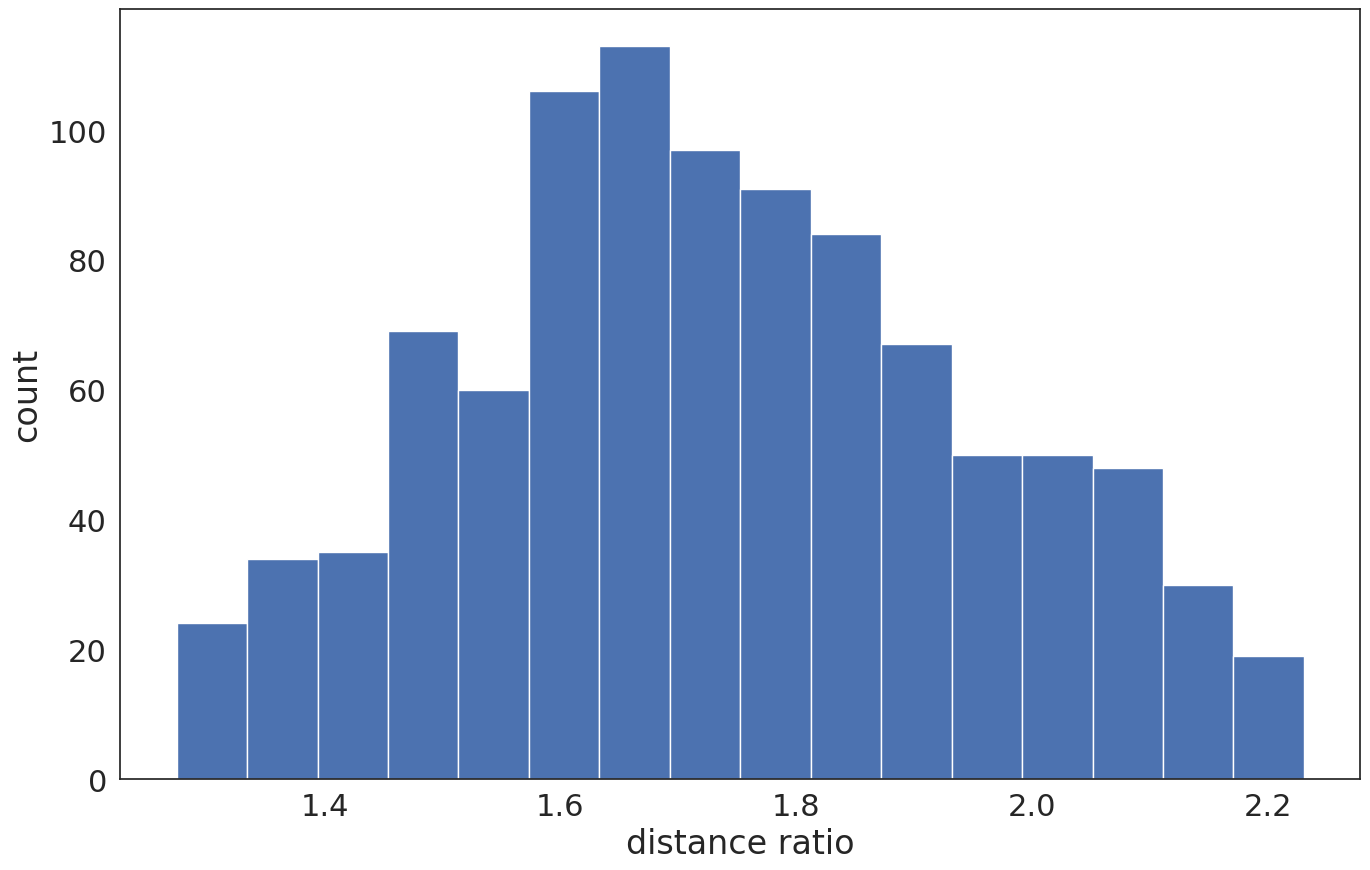

In [172]:
fig = plt.figure()
plt.hist(dist_ratio_rdmc, bins='auto')
ax = plt.gca()
ax.set_xlabel('distance ratio')
ax.set_ylabel('count')
# fig.savefig("image/rdmc_ratio_dft.png",format = "png",dpi=1200,bbox_inches='tight')

Text(0, 0.5, 'RDMC Guess')

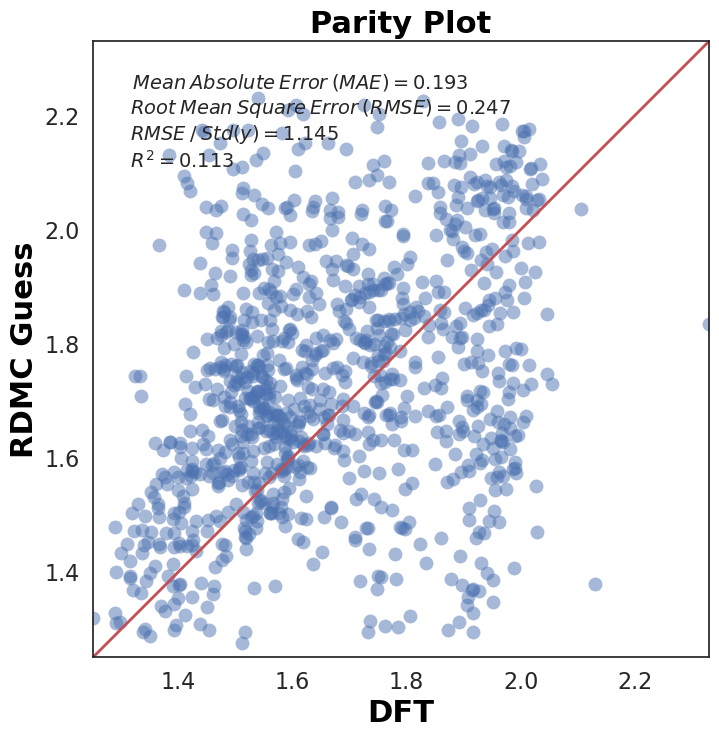

In [173]:
# Font for figure for publishing
font_axis_publish = {
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16

# Plot Figures
fignow = plt.figure(figsize=(8,8))

x = dist_ratio_dft
y = dist_ratio_rdmc

## find the boundaries of X and Y values
bounds = (min(x.min(), y.min()) - int(0.1 * y.min()), max(x.max(), y.max())+ int(0.1 * y.max()))

# Reset the limits
ax = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

plt.plot(x,y,"o", alpha=0.5 ,ms=10, markeredgewidth=0.0)

ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)

# Calculate Statistics of the Parity Plot 
mean_abs_err = np.mean(np.abs(x-y))
rmse = np.sqrt(np.mean((x-y)**2))
rmse_std = rmse / np.std(y)
z = np.polyfit(x,y, 1)
y_hat = np.poly1d(z)(x)

text = f"$\: \: Mean \: Absolute \: Error \: (MAE) = {mean_abs_err:0.3f}$ \n $ Root \: Mean \: Square \: Error \: (RMSE) = {rmse:0.3f}$ \n $ RMSE \: / \: Std(y) = {rmse_std :0.3f}$ \n $R^2 = {r2_score(y,y_hat):0.3f}$"

plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')

# Title and labels 
plt.title("Parity Plot", fontdict=font_axis_publish)
plt.xlabel('DFT', fontdict=font_axis_publish)
plt.ylabel('RDMC Guess', fontdict=font_axis_publish)

# Save the figure into 300 dpi
# fignow.savefig("image/rdmc_dft_dist_ratio_parity.png",format = "png",dpi=1200,bbox_inches='tight')

In [174]:
dist_short_am1 = potential_good['am1_r_R2E_R1O'].values
dist_long_am1 = potential_good['am1_r_R2X_R1X'].values
dist_ratio_am1 = dist_long_am1/dist_short_am1

Text(0, 0.5, 'AM1')

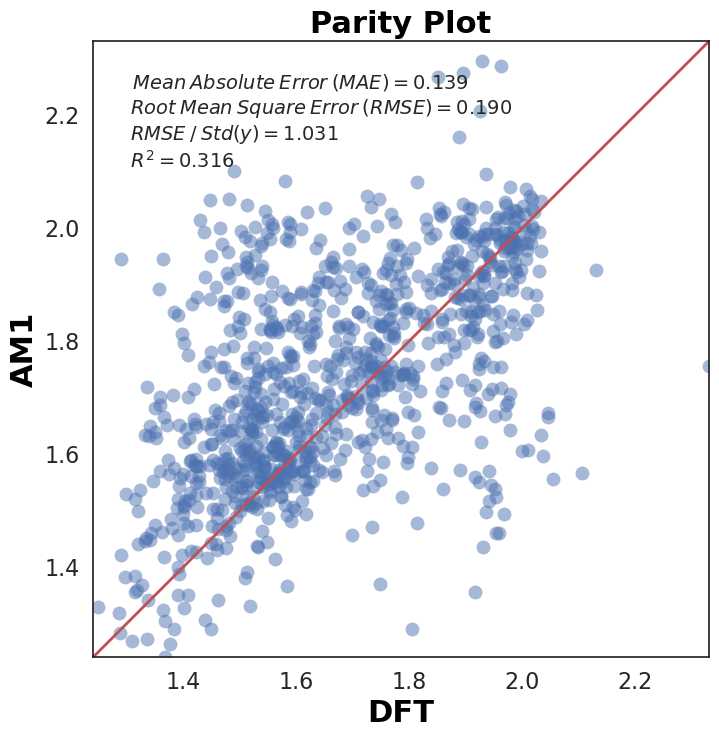

In [175]:
# Font for figure for publishing
font_axis_publish = {
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16

# Plot Figures
fignow = plt.figure(figsize=(8,8))

x = dist_ratio_dft
y = dist_ratio_am1

## find the boundaries of X and Y values
bounds = (min(x.min(), y.min()) - int(0.1 * y.min()), max(x.max(), y.max())+ int(0.1 * y.max()))

# Reset the limits
ax = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

plt.plot(x,y,"o", alpha=0.5 ,ms=10, markeredgewidth=0.0)

ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)

# Calculate Statistics of the Parity Plot 
mean_abs_err = np.mean(np.abs(x-y))
rmse = np.sqrt(np.mean((x-y)**2))
rmse_std = rmse / np.std(y)
z = np.polyfit(x,y, 1)
y_hat = np.poly1d(z)(x)

text = f"$\: \: Mean \: Absolute \: Error \: (MAE) = {mean_abs_err:0.3f}$ \n $ Root \: Mean \: Square \: Error \: (RMSE) = {rmse:0.3f}$ \n $ RMSE \: / \: Std(y) = {rmse_std :0.3f}$ \n $R^2 = {r2_score(y,y_hat):0.3f}$"

plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')

# Title and labels 
plt.title("Parity Plot", fontdict=font_axis_publish)
plt.xlabel('DFT', fontdict=font_axis_publish)
plt.ylabel('AM1', fontdict=font_axis_publish)

# Save the figure into 300 dpi
# fignow.savefig("image/am1_dft_dist_ratio_parity.png",format = "png",dpi=1200,bbox_inches='tight')

In [176]:
dist_short_pm7 = potential_good['pm7_r_R2E_R1O'].values
dist_long_pm7 = potential_good['pm7_r_R2X_R1X'].values
dist_ratio_pm7 = dist_long_pm7/dist_short_pm7

Text(0, 0.5, 'PM7')

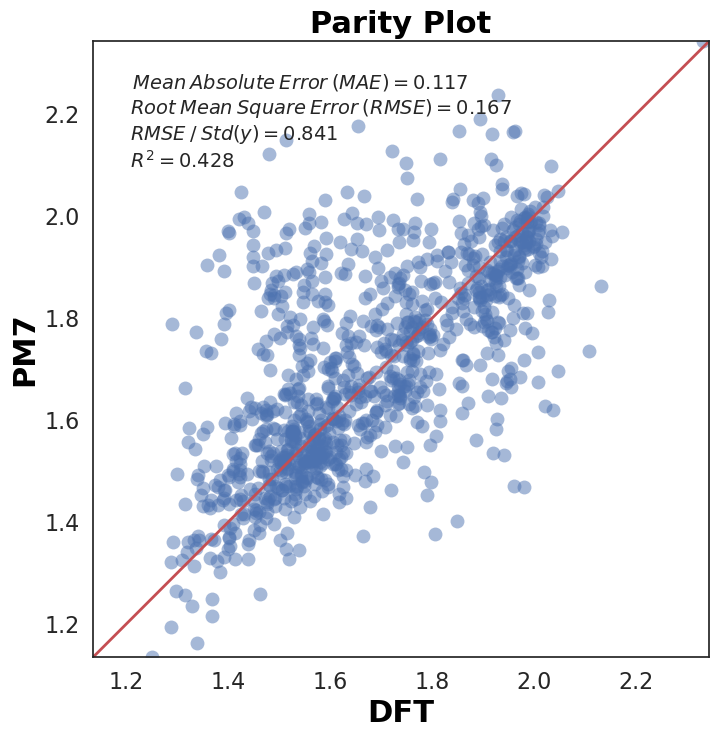

In [177]:
# Font for figure for publishing
font_axis_publish = {
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16

# Plot Figures
fignow = plt.figure(figsize=(8,8))

x = dist_ratio_dft
y = dist_ratio_pm7

## find the boundaries of X and Y values
bounds = (min(x.min(), y.min()) - int(0.1 * y.min()), max(x.max(), y.max())+ int(0.1 * y.max()))

# Reset the limits
ax = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

plt.plot(x,y,"o", alpha=0.5 ,ms=10, markeredgewidth=0.0)

ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)

# Calculate Statistics of the Parity Plot 
mean_abs_err = np.mean(np.abs(x-y))
rmse = np.sqrt(np.mean((x-y)**2))
rmse_std = rmse / np.std(y)
z = np.polyfit(x,y, 1)
y_hat = np.poly1d(z)(x)

text = f"$\: \: Mean \: Absolute \: Error \: (MAE) = {mean_abs_err:0.3f}$ \n $ Root \: Mean \: Square \: Error \: (RMSE) = {rmse:0.3f}$ \n $ RMSE \: / \: Std(y) = {rmse_std :0.3f}$ \n $R^2 = {r2_score(y,y_hat):0.3f}$"

plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')

# Title and labels 
plt.title("Parity Plot", fontdict=font_axis_publish)
plt.xlabel('DFT', fontdict=font_axis_publish)
plt.ylabel('PM7', fontdict=font_axis_publish)

# Save the figure into 300 dpi
# fignow.savefig("image/pm7_dft_dist_ratio_parity.png",format = "png",dpi=1200,bbox_inches='tight')

Text(0, 0.5, 'XTB')

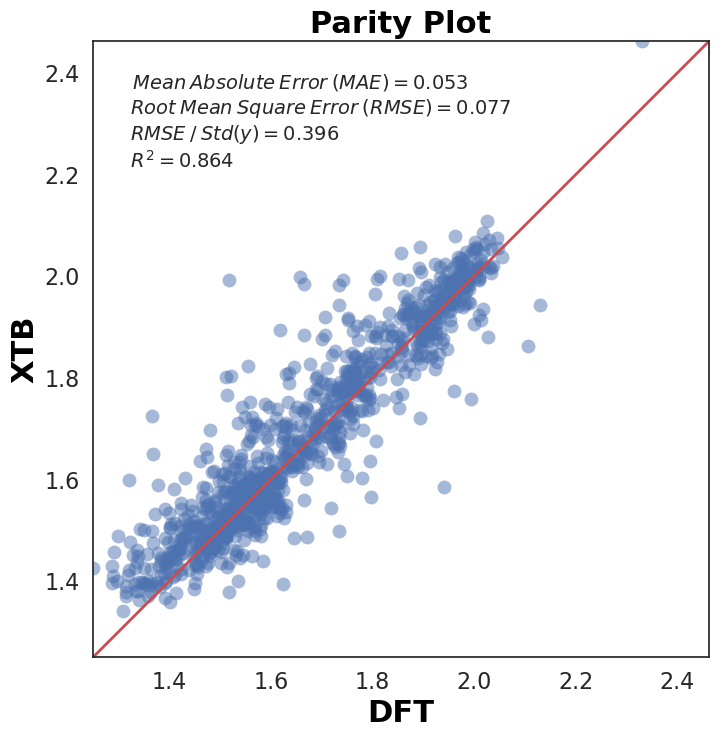

In [178]:
# Font for figure for publishing
font_axis_publish = {
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16

# Plot Figures
fignow = plt.figure(figsize=(8,8))

x = dist_ratio_dft
y = dist_ratio_xtb

## find the boundaries of X and Y values
bounds = (min(x.min(), y.min()) - int(0.1 * y.min()), max(x.max(), y.max())+ int(0.1 * y.max()))

# Reset the limits
ax = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

plt.plot(x,y,"o", alpha=0.5 ,ms=10, markeredgewidth=0.0)

ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)

# Calculate Statistics of the Parity Plot 
mean_abs_err = np.mean(np.abs(x-y))
rmse = np.sqrt(np.mean((x-y)**2))
rmse_std = rmse / np.std(y)
z = np.polyfit(x,y, 1)
y_hat = np.poly1d(z)(x)

text = f"$\: \: Mean \: Absolute \: Error \: (MAE) = {mean_abs_err:0.3f}$ \n $ Root \: Mean \: Square \: Error \: (RMSE) = {rmse:0.3f}$ \n $ RMSE \: / \: Std(y) = {rmse_std :0.3f}$ \n $R^2 = {r2_score(y,y_hat):0.3f}$"

plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')

# Title and labels 
plt.title("Parity Plot", fontdict=font_axis_publish)
plt.xlabel('DFT', fontdict=font_axis_publish)
plt.ylabel('XTB', fontdict=font_axis_publish)

# Save the figure into 300 dpi
# fignow.savefig("image/xtb_dft_dist_ratio_parity.png",format = "png",dpi=1200,bbox_inches='tight')

In [179]:
val_dft = potential_good['dft_r_TS_R1O'].values
val_xtb = potential_good['xtb_r_TS_R1O'].values
val_rdmc = potential_good['rdmc_guess_r_TS_R1O'].values
val_am1 = potential_good['am1_r_TS_R1O'].values
val_pm7 = potential_good['pm7_r_TS_R1O'].values

Text(0, 0.5, 'RDMC Guess')

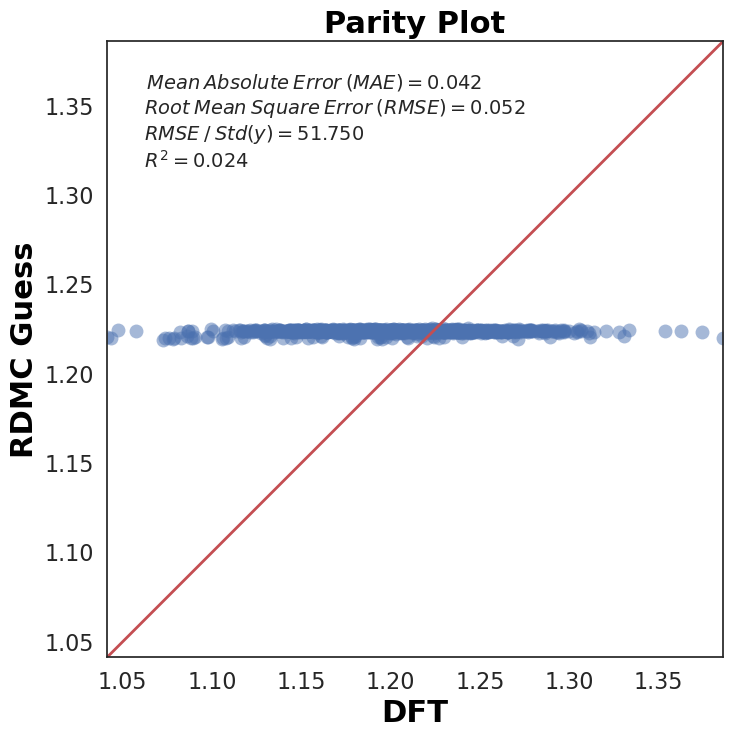

In [180]:
# Font for figure for publishing
font_axis_publish = {
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16

# Plot Figures
fignow = plt.figure(figsize=(8,8))

x = val_dft
y = val_rdmc

## find the boundaries of X and Y values
bounds = (min(x.min(), y.min()) - int(0.1 * y.min()), max(x.max(), y.max())+ int(0.1 * y.max()))

# Reset the limits
ax = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

plt.plot(x,y,"o", alpha=0.5 ,ms=10, markeredgewidth=0.0)

ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)

# Calculate Statistics of the Parity Plot 
mean_abs_err = np.mean(np.abs(x-y))
rmse = np.sqrt(np.mean((x-y)**2))
rmse_std = rmse / np.std(y)
z = np.polyfit(x,y, 1)
y_hat = np.poly1d(z)(x)

text = f"$\: \: Mean \: Absolute \: Error \: (MAE) = {mean_abs_err:0.3f}$ \n $ Root \: Mean \: Square \: Error \: (RMSE) = {rmse:0.3f}$ \n $ RMSE \: / \: Std(y) = {rmse_std :0.3f}$ \n $R^2 = {r2_score(y,y_hat):0.3f}$"

plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')

# Title and labels 
plt.title("Parity Plot", fontdict=font_axis_publish)
plt.xlabel('DFT', fontdict=font_axis_publish)
plt.ylabel('RDMC Guess', fontdict=font_axis_publish)

# Save the figure into 300 dpi
# fignow.savefig("image/rdmc_dft_ts_r1o_dist_parity.png",format = "png",dpi=1200,bbox_inches='tight')

Text(0, 0.5, 'XTB')

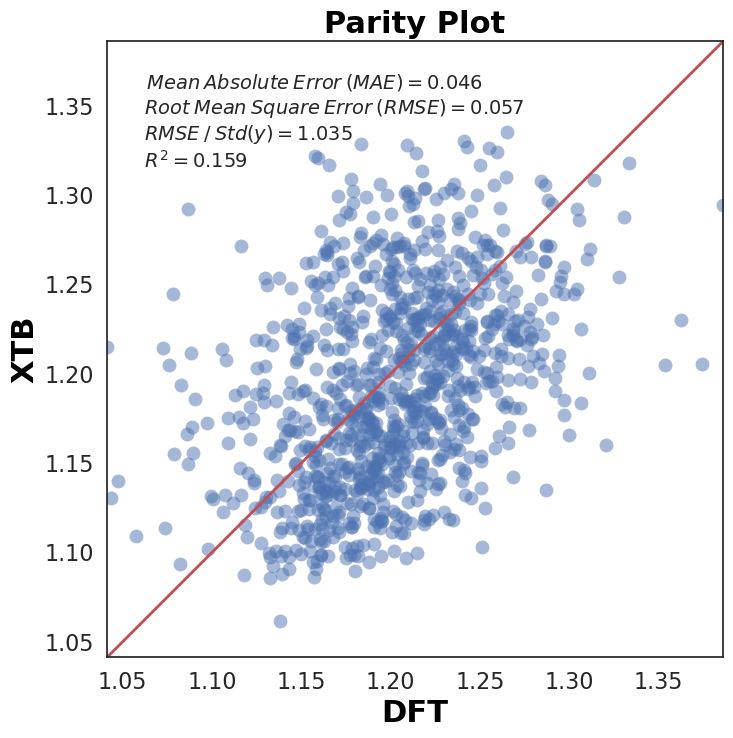

In [181]:
# Font for figure for publishing
font_axis_publish = {
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16

# Plot Figures
fignow = plt.figure(figsize=(8,8))

x = val_dft
y = val_xtb

## find the boundaries of X and Y values
bounds = (min(x.min(), y.min()) - int(0.1 * y.min()), max(x.max(), y.max())+ int(0.1 * y.max()))

# Reset the limits
ax = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

plt.plot(x,y,"o", alpha=0.5 ,ms=10, markeredgewidth=0.0)

ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)

# Calculate Statistics of the Parity Plot 
mean_abs_err = np.mean(np.abs(x-y))
rmse = np.sqrt(np.mean((x-y)**2))
rmse_std = rmse / np.std(y)
z = np.polyfit(x,y, 1)
y_hat = np.poly1d(z)(x)

text = f"$\: \: Mean \: Absolute \: Error \: (MAE) = {mean_abs_err:0.3f}$ \n $ Root \: Mean \: Square \: Error \: (RMSE) = {rmse:0.3f}$ \n $ RMSE \: / \: Std(y) = {rmse_std :0.3f}$ \n $R^2 = {r2_score(y,y_hat):0.3f}$"

plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')

# Title and labels 
plt.title("Parity Plot", fontdict=font_axis_publish)
plt.xlabel('DFT', fontdict=font_axis_publish)
plt.ylabel('XTB', fontdict=font_axis_publish)

# Save the figure into 300 dpi
# fignow.savefig("image/xtb_dft_ts_r1o_dist_parity.png",format = "png",dpi=1200,bbox_inches='tight')

In [182]:
val_dft = potential_good['dft_r_TS_R2E'].values
val_xtb = potential_good['xtb_r_TS_R2E'].values
val_rdmc = potential_good['rdmc_guess_r_TS_R2E'].values
val_am1 = potential_good['am1_r_TS_R2E'].values
val_pm7 = potential_good['pm7_r_TS_R2E'].values

Text(0, 0.5, 'RDMC Guess')

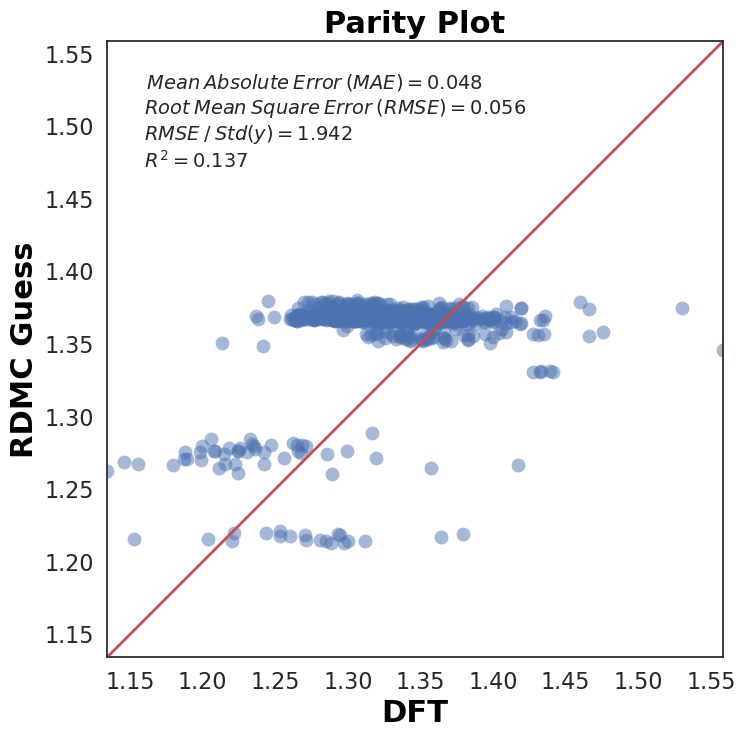

In [183]:
# Font for figure for publishing
font_axis_publish = {
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16

# Plot Figures
fignow = plt.figure(figsize=(8,8))

x = val_dft
y = val_rdmc

## find the boundaries of X and Y values
bounds = (min(x.min(), y.min()) - int(0.1 * y.min()), max(x.max(), y.max())+ int(0.1 * y.max()))

# Reset the limits
ax = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

plt.plot(x,y,"o", alpha=0.5 ,ms=10, markeredgewidth=0.0)

ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)

# Calculate Statistics of the Parity Plot 
mean_abs_err = np.mean(np.abs(x-y))
rmse = np.sqrt(np.mean((x-y)**2))
rmse_std = rmse / np.std(y)
z = np.polyfit(x,y, 1)
y_hat = np.poly1d(z)(x)

text = f"$\: \: Mean \: Absolute \: Error \: (MAE) = {mean_abs_err:0.3f}$ \n $ Root \: Mean \: Square \: Error \: (RMSE) = {rmse:0.3f}$ \n $ RMSE \: / \: Std(y) = {rmse_std :0.3f}$ \n $R^2 = {r2_score(y,y_hat):0.3f}$"

plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')

# Title and labels 
plt.title("Parity Plot", fontdict=font_axis_publish)
plt.xlabel('DFT', fontdict=font_axis_publish)
plt.ylabel('RDMC Guess', fontdict=font_axis_publish)

# Save the figure into 300 dpi
# fignow.savefig("image/rdmc_dft_ts_r2e_dist_parity.png",format = "png",dpi=1200,bbox_inches='tight')

Text(0, 0.5, 'XTB')

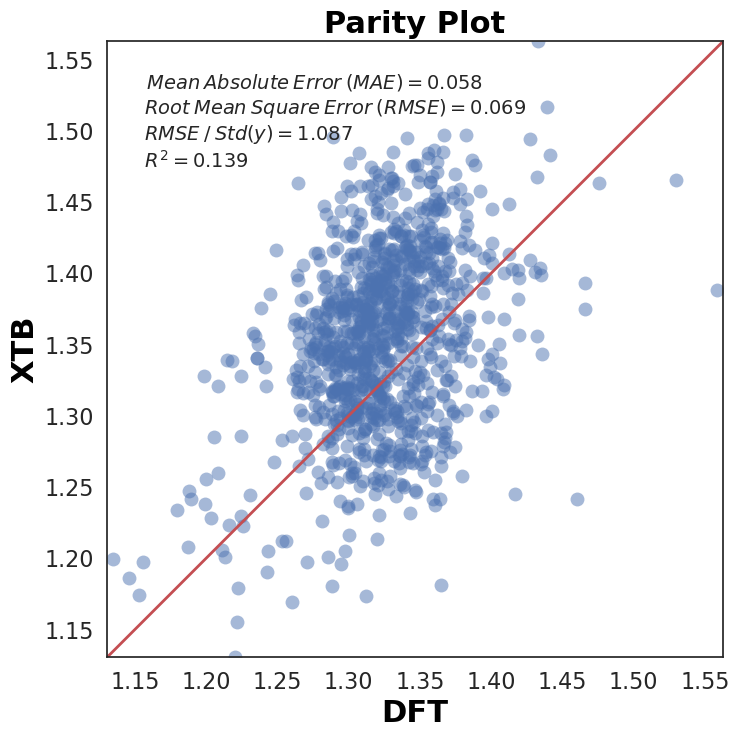

In [184]:
# Font for figure for publishing
font_axis_publish = {
        'color':  'black',
        'weight': 'bold',
        'size': 22,
        }
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['xtick.labelsize'] = 16

# Plot Figures
fignow = plt.figure(figsize=(8,8))

x = val_dft
y = val_xtb

## find the boundaries of X and Y values
bounds = (min(x.min(), y.min()) - int(0.1 * y.min()), max(x.max(), y.max())+ int(0.1 * y.max()))

# Reset the limits
ax = plt.gca()
ax.set_xlim(bounds)
ax.set_ylim(bounds)
# Ensure the aspect ratio is square
ax.set_aspect("equal", adjustable="box")

plt.plot(x,y,"o", alpha=0.5 ,ms=10, markeredgewidth=0.0)

ax.plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax.transAxes)

# Calculate Statistics of the Parity Plot 
mean_abs_err = np.mean(np.abs(x-y))
rmse = np.sqrt(np.mean((x-y)**2))
rmse_std = rmse / np.std(y)
z = np.polyfit(x,y, 1)
y_hat = np.poly1d(z)(x)

text = f"$\: \: Mean \: Absolute \: Error \: (MAE) = {mean_abs_err:0.3f}$ \n $ Root \: Mean \: Square \: Error \: (RMSE) = {rmse:0.3f}$ \n $ RMSE \: / \: Std(y) = {rmse_std :0.3f}$ \n $R^2 = {r2_score(y,y_hat):0.3f}$"

plt.gca().text(0.05, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top')

# Title and labels 
plt.title("Parity Plot", fontdict=font_axis_publish)
plt.xlabel('DFT', fontdict=font_axis_publish)
plt.ylabel('XTB', fontdict=font_axis_publish)

# Save the figure into 300 dpi
# fignow.savefig("image/xtb_dft_ts_r2e_dist_parity.png",format = "png",dpi=1200,bbox_inches='tight')

Text(0, 0.5, 'count')

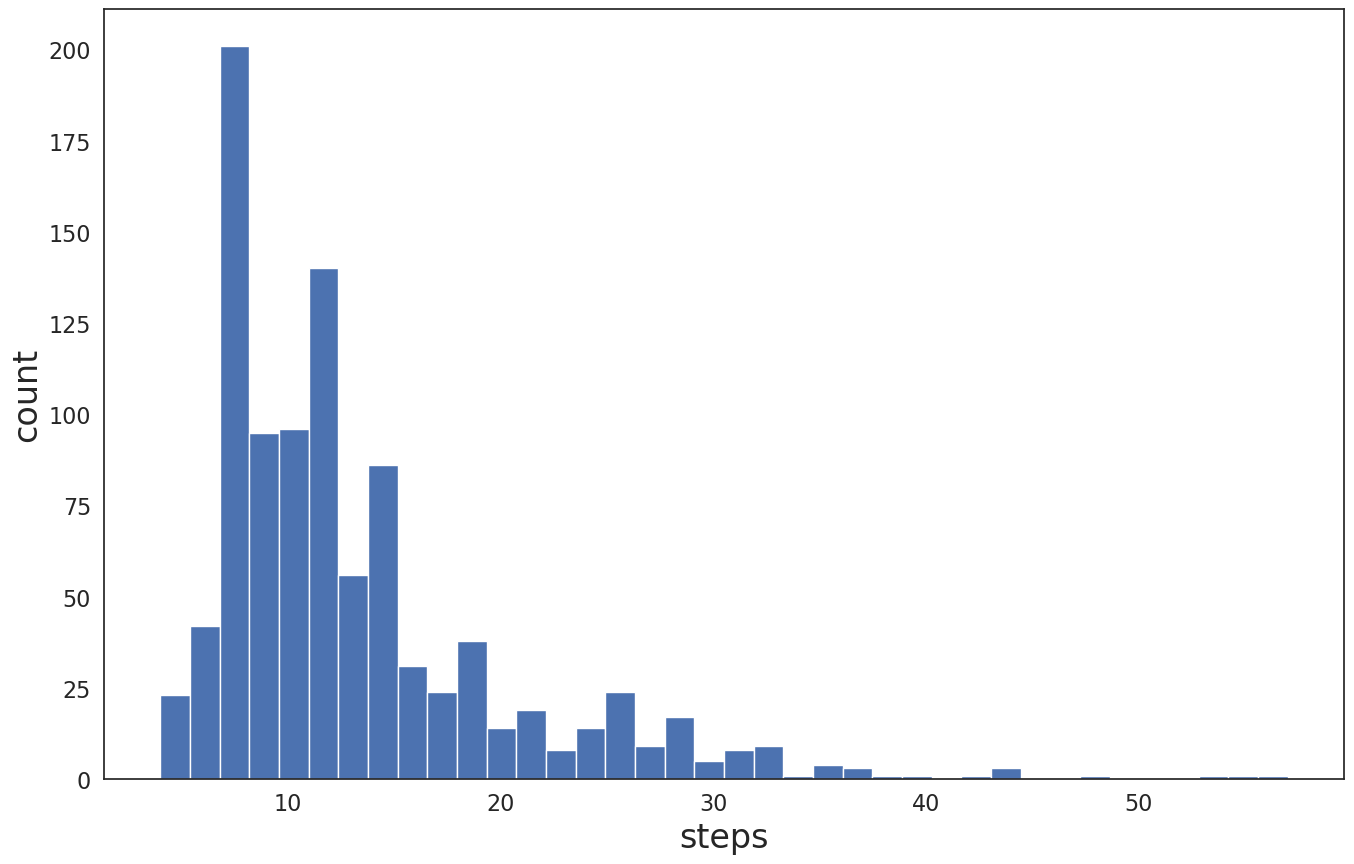

In [185]:
fig = plt.figure()
plt.hist(potential_good['dft_steps'].values, bins='auto')
ax = plt.gca()
ax.set_xlabel('steps')
ax.set_ylabel('count')
# fig.savefig("image/dft_step_count.png",format = "png",dpi=1200,bbox_inches='tight')

Text(0, 0.5, 'count')

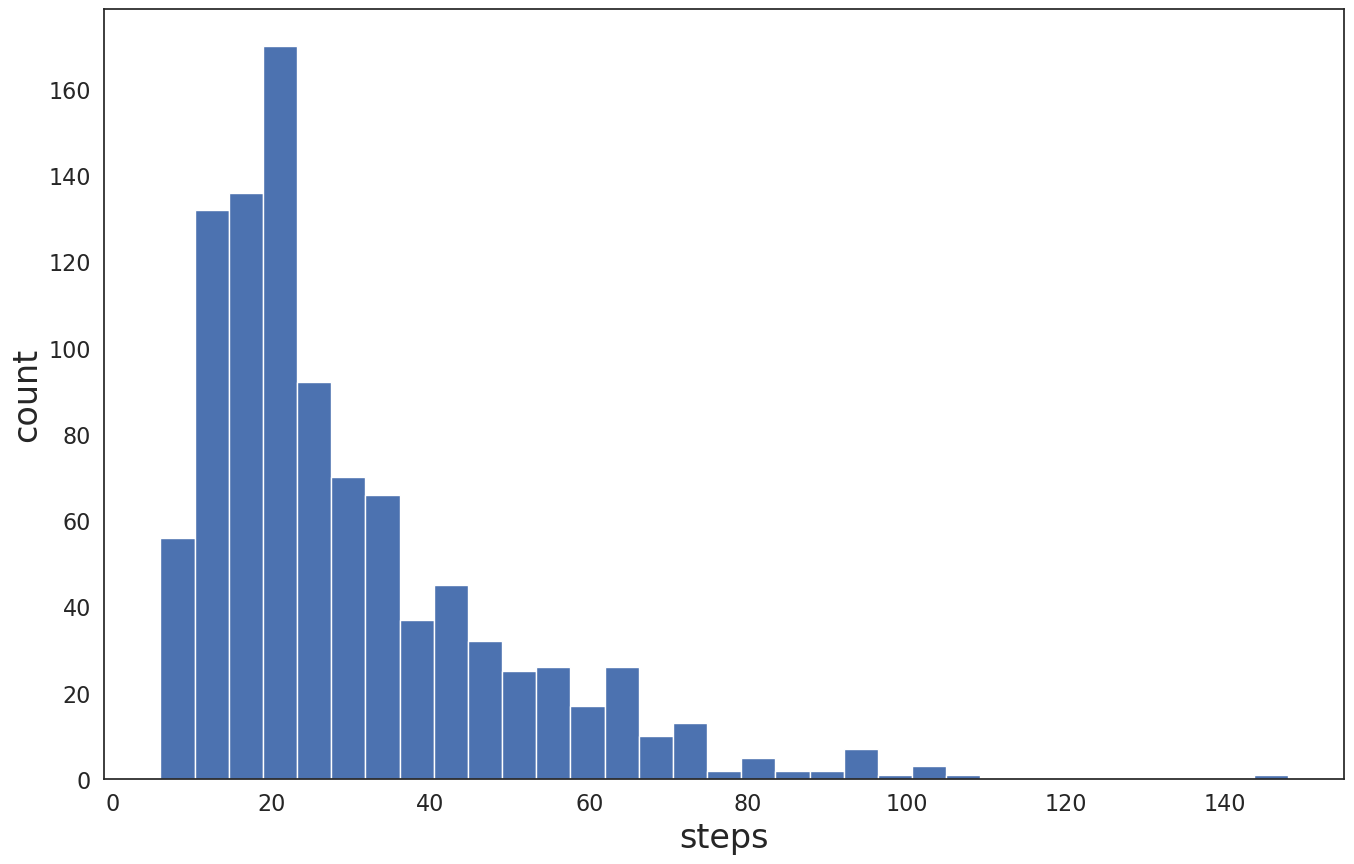

In [186]:
fig = plt.figure()
plt.hist(potential_good['xtb_steps'].values, bins='auto')
ax = plt.gca()
ax.set_xlabel('steps')
ax.set_ylabel('count')
# fig.savefig("image/xtb_step_count.png",format = "png",dpi=1200,bbox_inches='tight')

Text(0, 0.5, 'count')

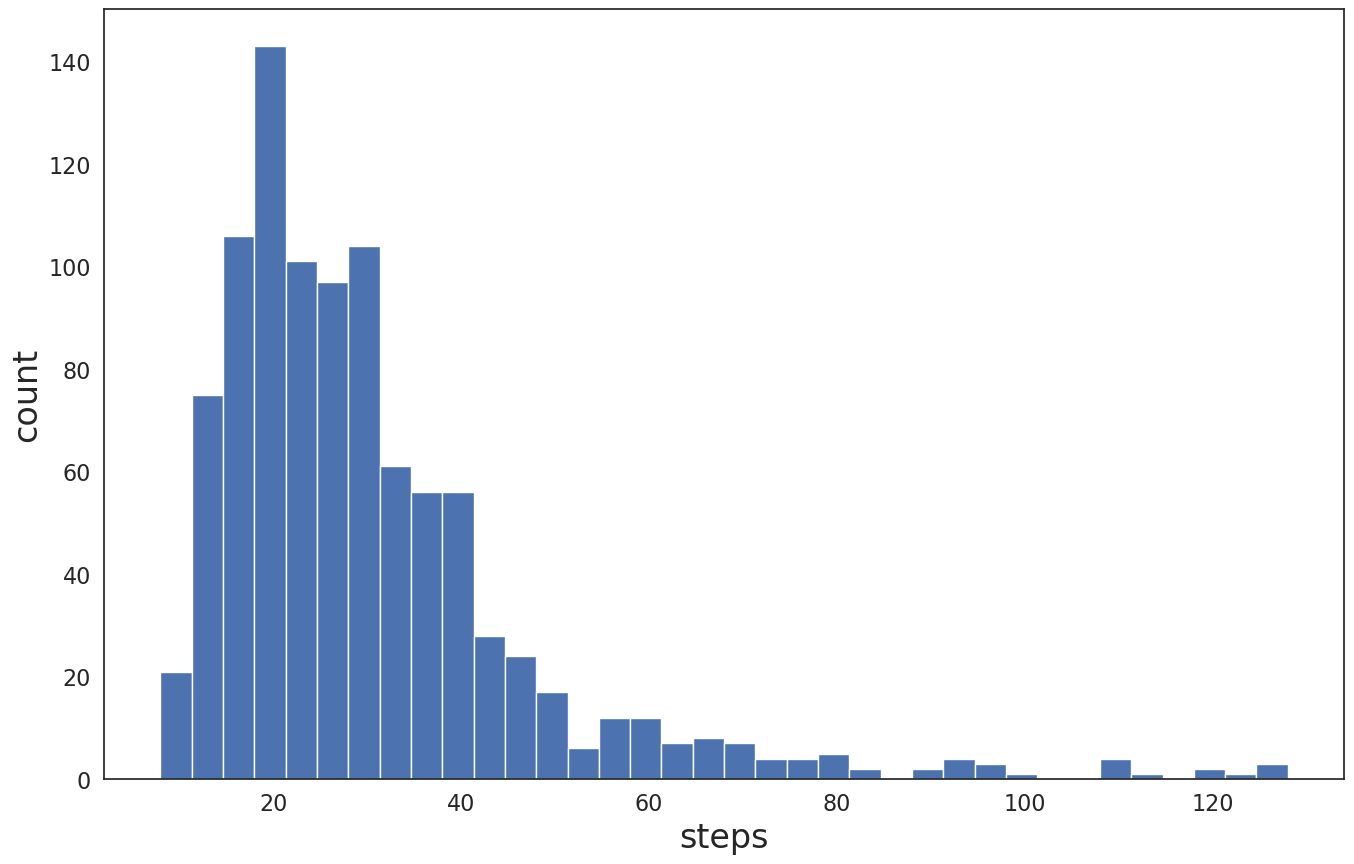

In [187]:
fig = plt.figure()
plt.hist(potential_good['am1_steps'].values, bins='auto')
ax = plt.gca()
ax.set_xlabel('steps')
ax.set_ylabel('count')
# fig.savefig("image/am1_step_count.png",format = "png",dpi=1200,bbox_inches='tight')

Text(0, 0.5, 'count')

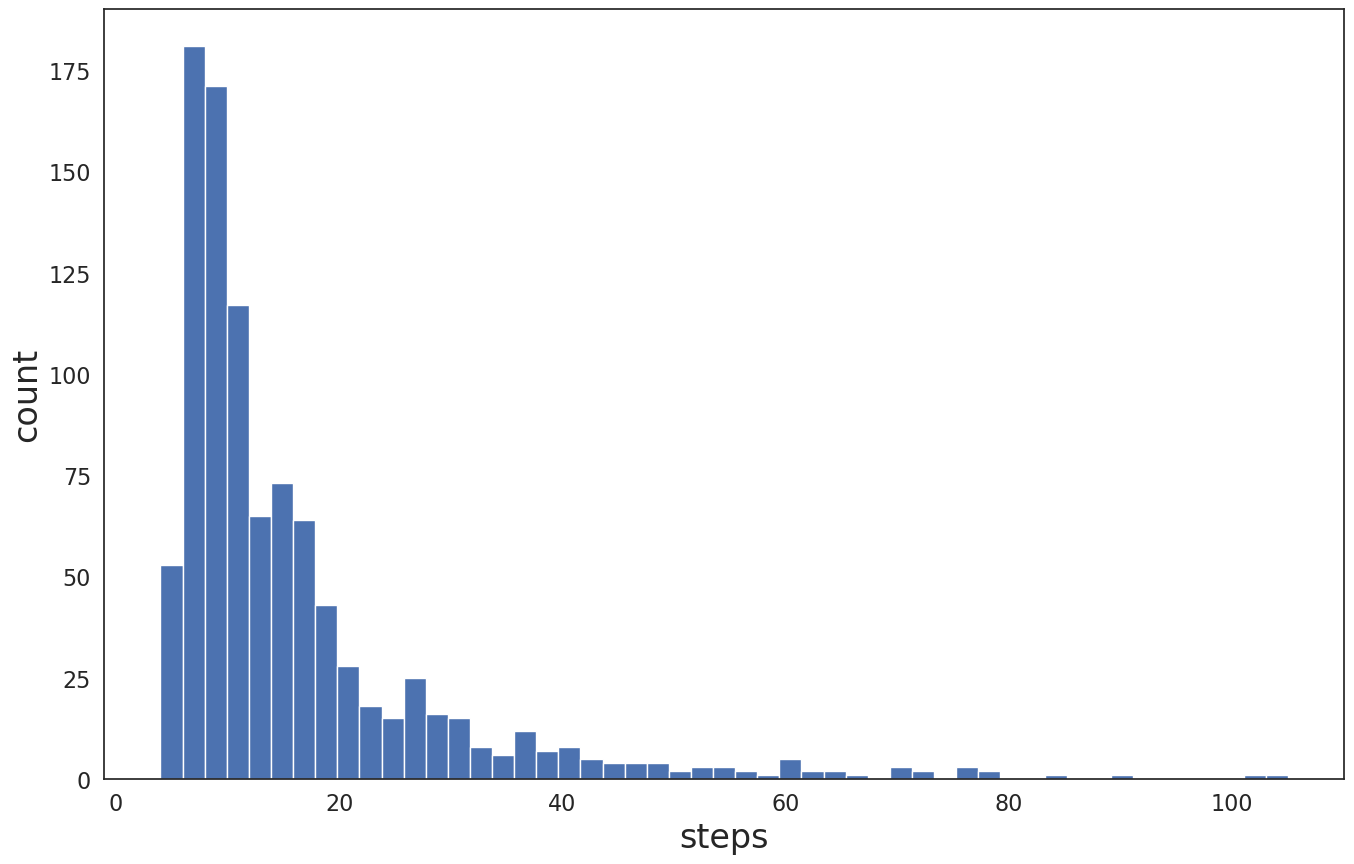

In [188]:
fig = plt.figure()
plt.hist(potential_good['pm7_steps'].values, bins='auto')
ax = plt.gca()
ax.set_xlabel('steps')
ax.set_ylabel('count')
# fig.savefig("image/pm7_step_count.png",format = "png",dpi=1200,bbox_inches='tight')

In [190]:
def calc_time_hr(x):
    
    day, hr, minute, sec = x
    time_sec = sec + minute*60 + hr*60*60 + day*24*60*60
    time_hr = time_sec / (3600)
    
    return time_hr

In [191]:
dft_time = np.array([calc_time_hr(x) for x in potential_good['dft_cpu'].values])

In [193]:
sum(dft_time)

28541.615888888904

In [194]:
xtb_time = np.array([calc_time_hr(x) for x in potential_good['xtb_cpu'].values])

In [195]:
sum(xtb_time)

1359.3233611111116

In [196]:
pm7_time = np.array([calc_time_hr(x) for x in potential_good['pm7_cpu'].values])

In [197]:
sum(pm7_time)

604.5816666666668

In [198]:
am1_time = np.array([calc_time_hr(x) for x in potential_good['am1_cpu'].values])

In [199]:
sum(am1_time)

1220.5099166666682

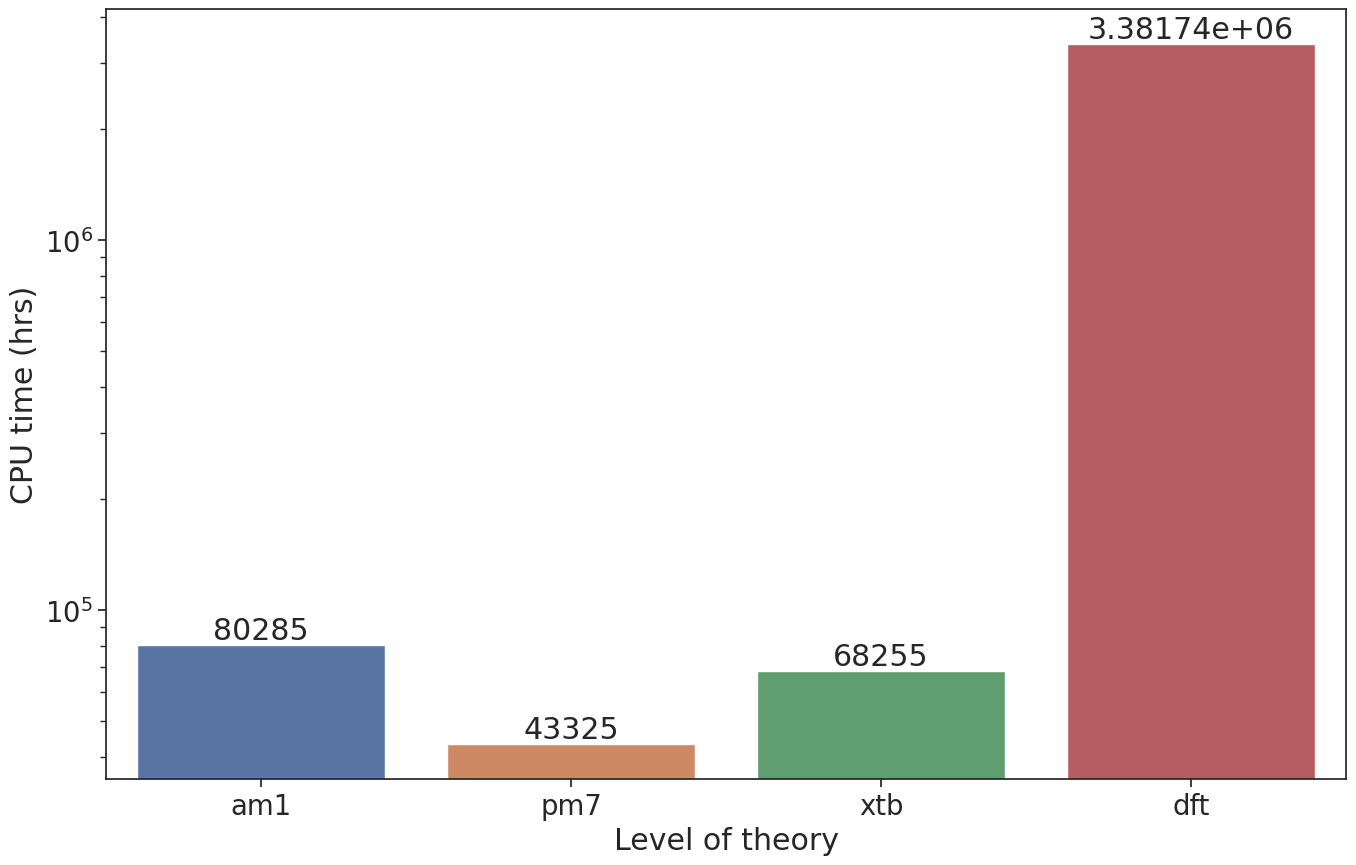

In [201]:
fig = plt.figure()
sns.set(rc = {'figure.figsize':(16,10)})
sns.set(font_scale=1.8)
sns.set_style("ticks")
ax = sns.barplot(y = [80285, 43325, 68255, 3381736], x = ['am1', 'pm7', 'xtb', 'dft'])
ax.bar_label(ax.containers[0])
ax.set_xlabel('Level of theory')
ax.set_ylabel('CPU time (hrs)')
ax.set_yscale('log')
# fig.savefig("image/cpu_time.png",format = "png",dpi=1200,bbox_inches='tight')

In [202]:
dft_time = np.array([calc_time_hr(x) for x in potential_good['dft_wall'].values])
sum(dft_time)

875.0265833333336

In [203]:
xtb_time = np.array([calc_time_hr(x) for x in potential_good['xtb_wall'].values])
sum(xtb_time)

36.35830555555558

In [204]:
am1_time = np.array([calc_time_hr(x) for x in potential_good['am1_wall'].values])
sum(am1_time)

32.81100000000002

In [205]:
pm7_time = np.array([calc_time_hr(x) for x in potential_good['pm7_wall'].values])
sum(pm7_time)

16.167972222222225

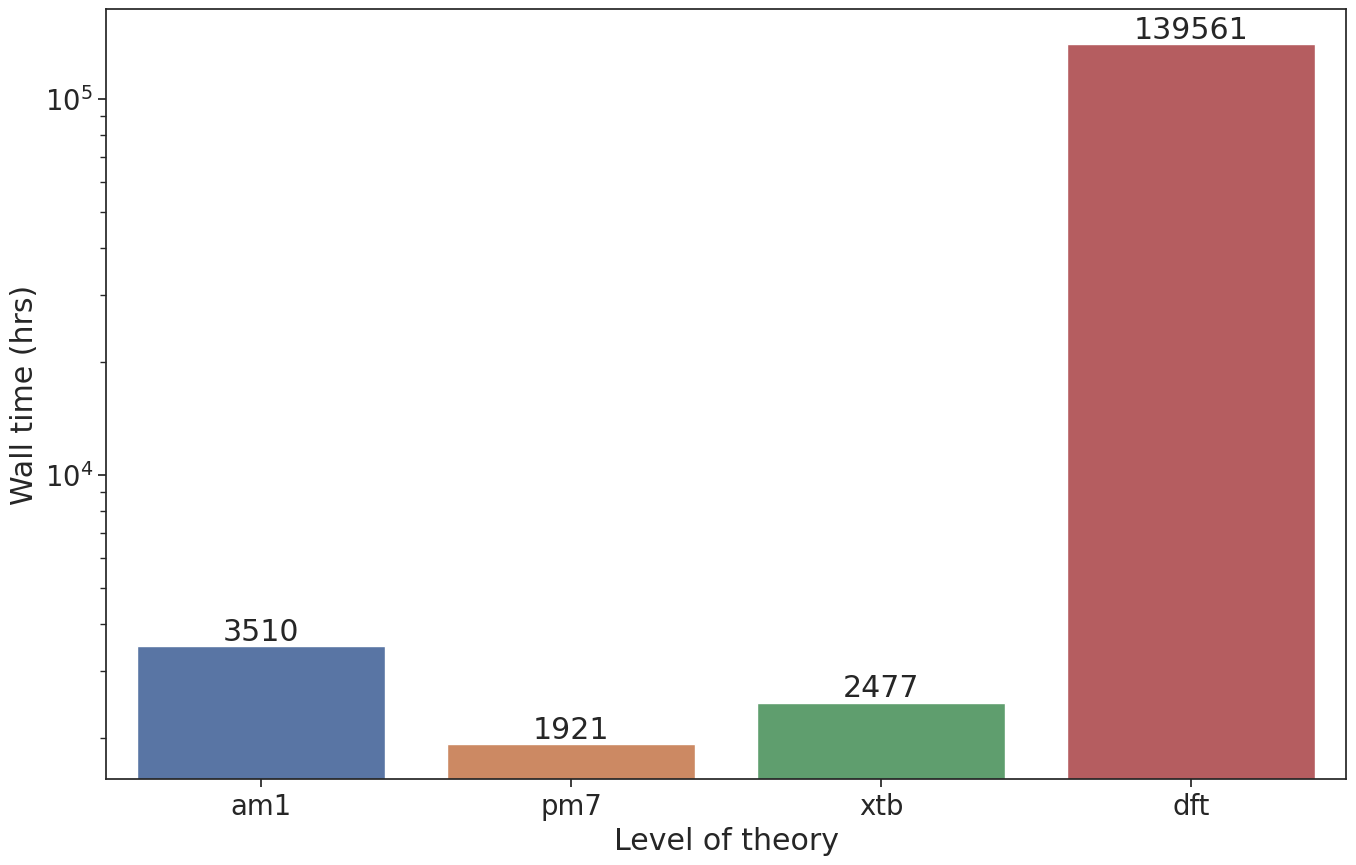

In [206]:
fig = plt.figure()
sns.set(rc = {'figure.figsize':(16,10)})
sns.set(font_scale=1.8)
sns.set_style("ticks")
ax = sns.barplot(y = [3510, 1921, 2477, 139561], x = ['am1', 'pm7', 'xtb', 'dft'])
ax.bar_label(ax.containers[0])
ax.set_xlabel('Level of theory')
ax.set_ylabel('Wall time (hrs)')
ax.set_yscale('log')
# fig.savefig("image/wall_time.png",format = "png",dpi=1200,bbox_inches='tight')